In [1]:
library(ggplot2)
library(FSA) # for the vbStart function to find good parameters for the von Bertalanffy function
library(minpack.lm) # a more robust version of nls for non-linear curve fitting to avoid problems with e.g. very small sample sizes
library(rstan)

custom_theme <- function() {
  theme_minimal() +
    theme(
      panel.background = element_rect(fill = "white"),
      panel.grid.major = element_line(color = alpha("black", 0.5), linetype = "dotted", linewidth = 0.5),
      panel.grid.minor = element_blank(),
      axis.text = element_text(size = 12),  # Adjust the font size of axis labels
      axis.title = element_text(size = 16),  # Adjust the font size of axis titles
      plot.title = element_text(size = 20, hjust = 0.5),  # Adjust the font size and center the plot title
      plot.subtitle = element_text(size = 16, hjust = 0.5)  # Adjust the font size and center the plot subtitle
    )
}
options(repr.plot.width=15, repr.plot.height=8)

# rstan options
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

## FSA v0.9.5. See citation('FSA') if used in publication.
## Run fishR() for related website and fishR('IFAR') for related book.

Loading required package: StanHeaders


rstan version 2.32.3 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




## Plan
- [x] Verify that we can recover alligator parameters
- [x] Verify that we can detect different levels of dimorphism (use correct sex)
- [x] Verify that that still works when we use the different sex assignment method
- [x] Figure out some reasonable priors
- [x] Go through the dinosaur analysis
    - [x] For each, figure out reasonable priors
    - [x] Fit the curve
    - [x] Get the results

# Bayesian Analysis

Plan is to rerun the analyses in Saitta et al (2020), but with we fit the curves using a Bayesian analysis. I think it makes sense to only do this at the end, when we're figuring out the curves for the specific sexes. So, the basic plan for each population will be:

1. Fit a curve to the whole population
1. Use the residuals to predict the sex
1. Use a Bayesian analysis to find posterior predictions for the different parameters for the different sexes. Maybe use as a prior the values for the population as a whole?
1. Calculate the distribution of the difference in the asymptotic size parameters to get the distribution for the level of dimorphism!

## Demonstration - Alligator Analysis

To test this method out, let's run the analysis on the same alligator population we're been using this whole time. As a reminder, we are modelling them using a von Bertalanffy curve

$$
\begin{align*}
C &= &= L_\infty \left(1 - A e^{-KP}\right) \\
\end{align*}
$$

And specifically, we are using the values
$$
\begin{align*}
L_m &= 3.79 * (1 - 0.94 e^{-0.0695t}) \\
\sigma_{L_m} &= 0.0589 \log L_m + 0.0816 \\
L_f &= 2.78 * (1 - 0.91 e^{-0.0926t}) \\
\sigma_{L_f} &= 0.0332 \log L_f + 0.046 \\
\end{align*}
$$

In [2]:
actual_male_params <- list(
    L = 3.79,
    A = 0.94,
    K = 0.0695
)
actual_female_params <- list(
    L = 2.78,
    A = 0.91,
    K = 0.0926
)

generalized_von_bertalanffy <- function(age, L, A, K) {
    # print(paste("L", L))
    # print(paste("A", A))
    # print(paste("K", K))
    L * (1 - A * exp(-K * age))
}

generate_initial_vb_params <- function(df, debug = FALSE) {
    initial_params_raw <- tryCatch({vbStarts(df$length ~ df$age)},
        error = function(e) {
            if (debug) {
                cat("Error getting initial von Bertalanffy parameters for data", conditionMessage(e))
            }
            NULL
        }
    )

    if (is.null(initial_params_raw)) return(NULL)

    # now convert to my parameterization
    # I use y = Linf * (1 - A e ^ (-Kt) )
    # they use y = Linf * (1 - e^(-K (t - t0)))
    # -> A = e^K t0
    initial_params <- list(
        L = initial_params_raw$Linf,
        K = initial_params_raw$K,
        A = exp(initial_params_raw$K * initial_params_raw$t0)
    )
    initial_params
}

generate_male_alligator_mean_lengths <- function(t) {
    3.79 * (1 - 0.94 * exp(-0.0695 * t))
}

generate_male_alligator_sigma <- function(lengths) {
    0.0589 * log(lengths) + 0.0816
}

generate_female_alligator_mean_lengths <- function(t) {
    2.78 * (1 - 0.91 * exp(-0.0926 * t))
}

generate_female_alligator_sigma <- function(lengths) {
    0.0332 * log(lengths) + 0.046
}

generate_alligator_samples <- function(t, sex) {
    if (sex == "M") {
        length_function <- generate_male_alligator_mean_lengths
        sigma_function <- generate_male_alligator_sigma
    } else if (sex == "F") {
        length_function <- generate_female_alligator_mean_lengths
        sigma_function <- generate_female_alligator_sigma
    }
    lengths <- length_function(t)
    sigmas <- sigma_function(lengths)
    rnorm(length(t), mean = lengths, sd = sigmas)
}

ALLIGATOR_MAX_LIFESPAN <- 50

To start, let's simplify this model down to just a single set of parameters (the male ones) and then a fixed $\sigma$. This'll allow us to test the method before increasing the complexity.

In [3]:
NUM_SAMPLES <- 1e3
test_ages <- runif(NUM_SAMPLES, 1, ALLIGATOR_MAX_LIFESPAN)
mean_length <- generalized_von_bertalanffy(test_ages, L = actual_male_params[['L']], A = actual_male_params[['A']], K = actual_male_params[['K']])
sigma <- 0.25
noisy_length <- rnorm(NUM_SAMPLES, mean = mean_length, sd = sigma)

combined_data <- data.frame(age = test_ages, length = noisy_length)
combined_data <- subset(combined_data, combined_data$length > 0)

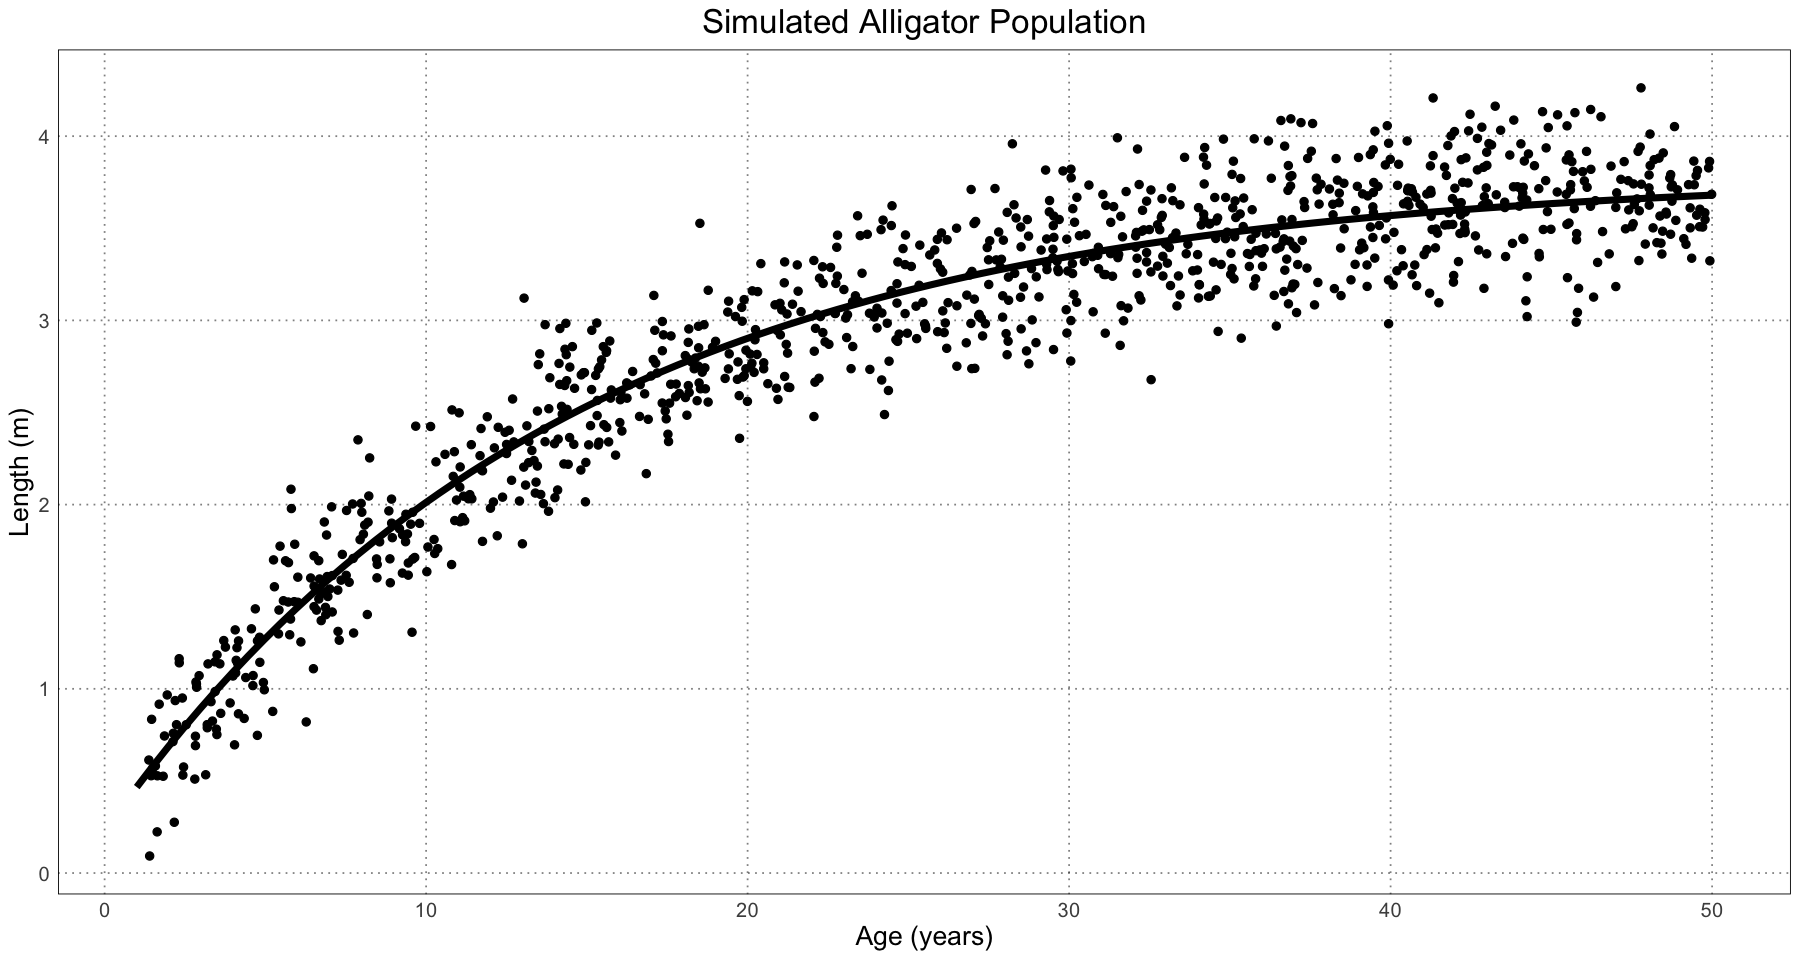

In [4]:
curve_age <- seq(1, ALLIGATOR_MAX_LIFESPAN, length.out = 100)
curve_length <- generalized_von_bertalanffy(curve_age, L = actual_male_params[['L']], A = actual_male_params[['A']], K = actual_male_params[['K']])
curve_data <- data.frame(age = curve_age, length = curve_length)

ggplot(combined_data, aes(age, length)) +
    geom_point(size = 2) +
    geom_line(data = curve_data, mapping = aes(age, length), linewidth = 2) +
    labs(x = "Age (years)", y = "Length (m)", title = "Simulated Alligator Population") +
    custom_theme()

Great! So now let's build a model for this to ensure that we can recover our initial values.

In [5]:
actual_male_params

$L
[1] 3.79

$A
[1] 0.94

$K
[1] 0.0695

In [6]:
toy_model <- "
data {
    int<lower = 0> N; // number of samples
    vector[N] length; // a vector of the lengths
    vector[N] age; // vector of the ages; index correlates with length (so length[i] happened at age[i])
}

parameters {
    real<lower = 0> L;
    real<lower = 0> A;
    real<lower = 0> K;
    real<lower = 0> sigma_length;
}

model {
    vector[N] mean_length;

    L ~ normal(3.79, 1);
    K ~ normal(0.0695, 0.05);
    A ~ normal(0.94, 0.5);
    sigma_length ~ normal(0.25, 0.125);
    mean_length = L * (1 - A * exp(-K * age));
    length ~ normal(mean_length, sigma_length);
}

generated quantities {
    real prior_L = normal_rng(3.79, 1);
    real prior_K = normal_rng(0.0695, 0.05);
    real prior_A = normal_rng(0.94, 0.5);
    real prior_sigma_length = normal_rng(0.25, 0.125);
}
"

data <- list(
    N = nrow(combined_data),
    length = combined_data$length,
    age = combined_data$age
)
model.toy <- stan(model_code = toy_model, data = data)

One thing to note is that I've added the priors to the `generated quantities` section so that we can see how we change between the posterior and the prior.

In [7]:
model.toy

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff
L                    3.83    0.00 0.03   3.78   3.81   3.83   3.85   3.88  1684
A                    0.93    0.00 0.01   0.91   0.93   0.93   0.94   0.96  1783
K                    0.07    0.00 0.00   0.06   0.06   0.07   0.07   0.07  1455
sigma_length         0.25    0.00 0.01   0.24   0.25   0.25   0.25   0.26  2628
prior_L              3.80    0.02 1.00   1.85   3.13   3.83   4.47   5.75  3932
prior_K              0.07    0.00 0.05  -0.03   0.04   0.07   0.10   0.17  4028
prior_A              0.95    0.01 0.49  -0.01   0.60   0.96   1.29   1.91  3965
prior_sigma_length   0.25    0.00 0.13   0.00   0.16   0.25   0.33   0.49  3905
lp__               877.60    0.04 1.43 874.05 876.86 877.94 878.67 879.37  1515
                   Rhat
L                   

Looking at the rhat, it looks like we had good convergence. Now let's take a look at the distribution for the values of the parameters and compare them to the original ones.

In [8]:
samples <- extract(model.toy)
lapply(samples, head)

$L
[1] 3.813569 3.830327 3.834870 3.781391 3.789697 3.848697

$A
[1] 0.9433432 0.9267761 0.9514492 0.9502974 0.9416533 0.9446477

$K
[1] 0.06789619 0.06557714 0.06729944 0.06987950 0.06981998 0.06617439

$sigma_length
[1] 0.2559493 0.2531922 0.2517851 0.2430339 0.2448664 0.2592897

$prior_L
[1] 2.150395 4.582854 3.171879 4.654540 2.874162 4.766784

$prior_K
[1] 0.05855074 0.16690570 0.03440776 0.12693430 0.06633937 0.09561497

$prior_A
[1] 0.6048654 0.9677611 1.2071741 0.3055434 1.9106478 0.7883351

$prior_sigma_length
[1] 0.26106473 0.14234610 0.07599167 0.24219251 0.27338781 0.24899646

$lp__
[1] 878.8210 879.2081 877.5818 876.5681 876.2531 877.0579

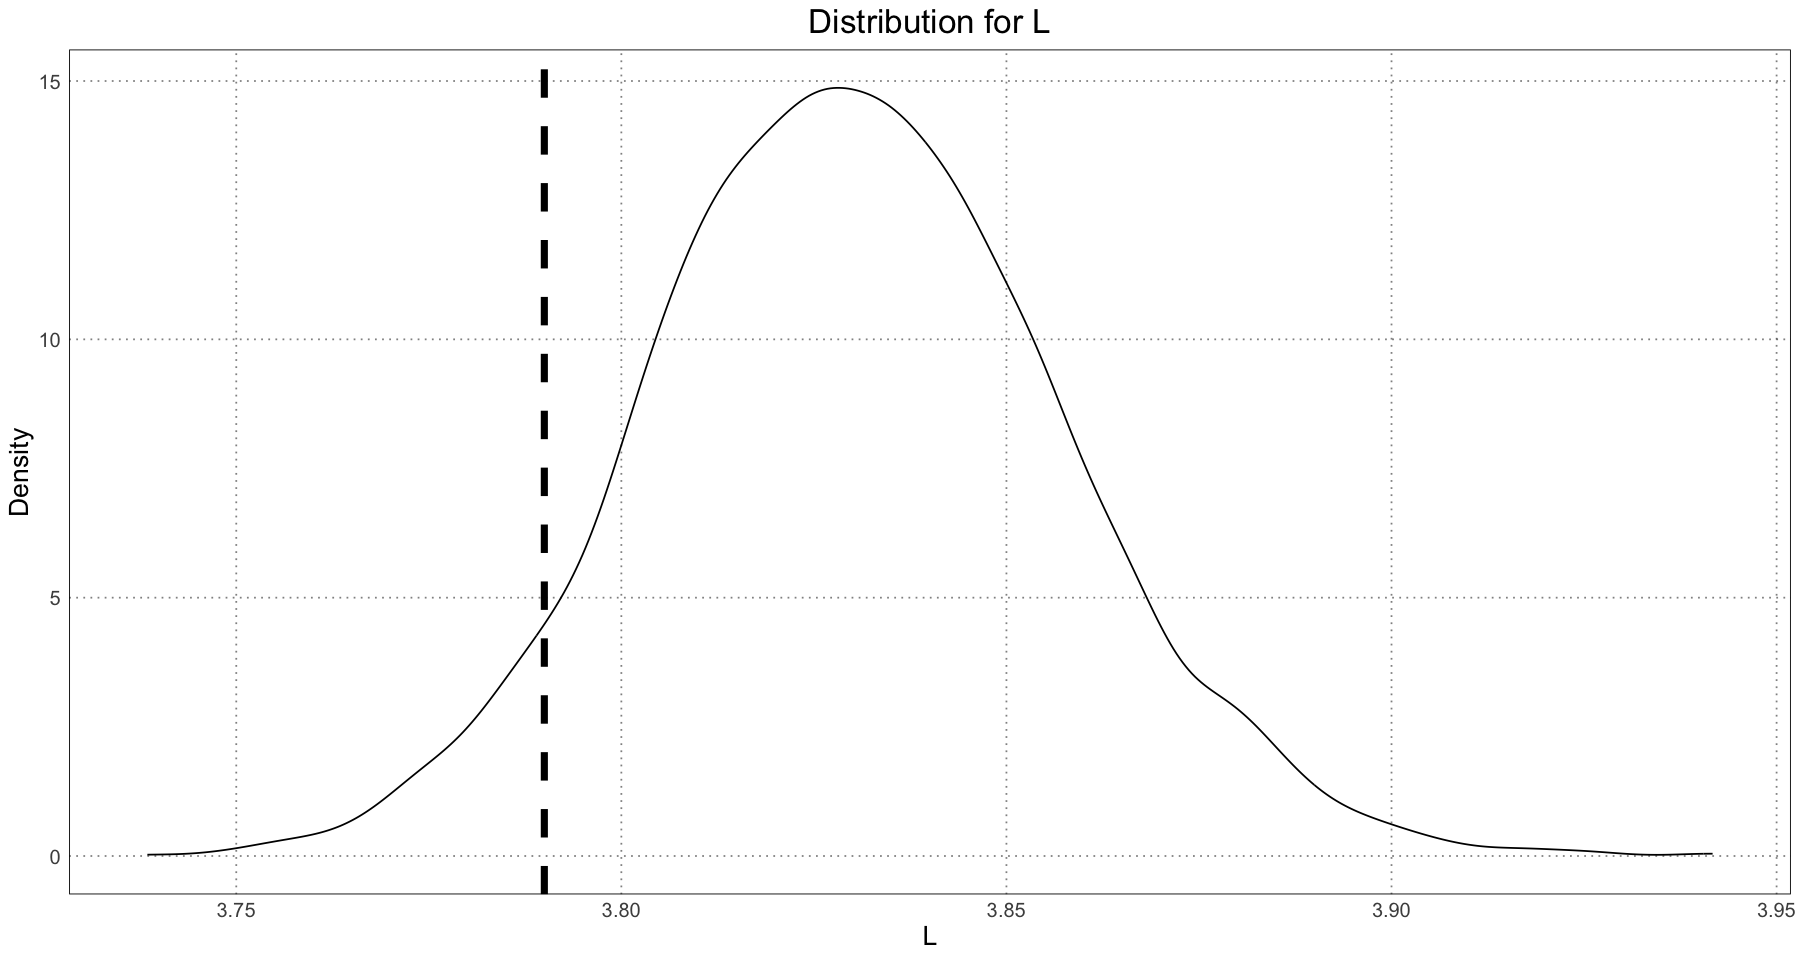

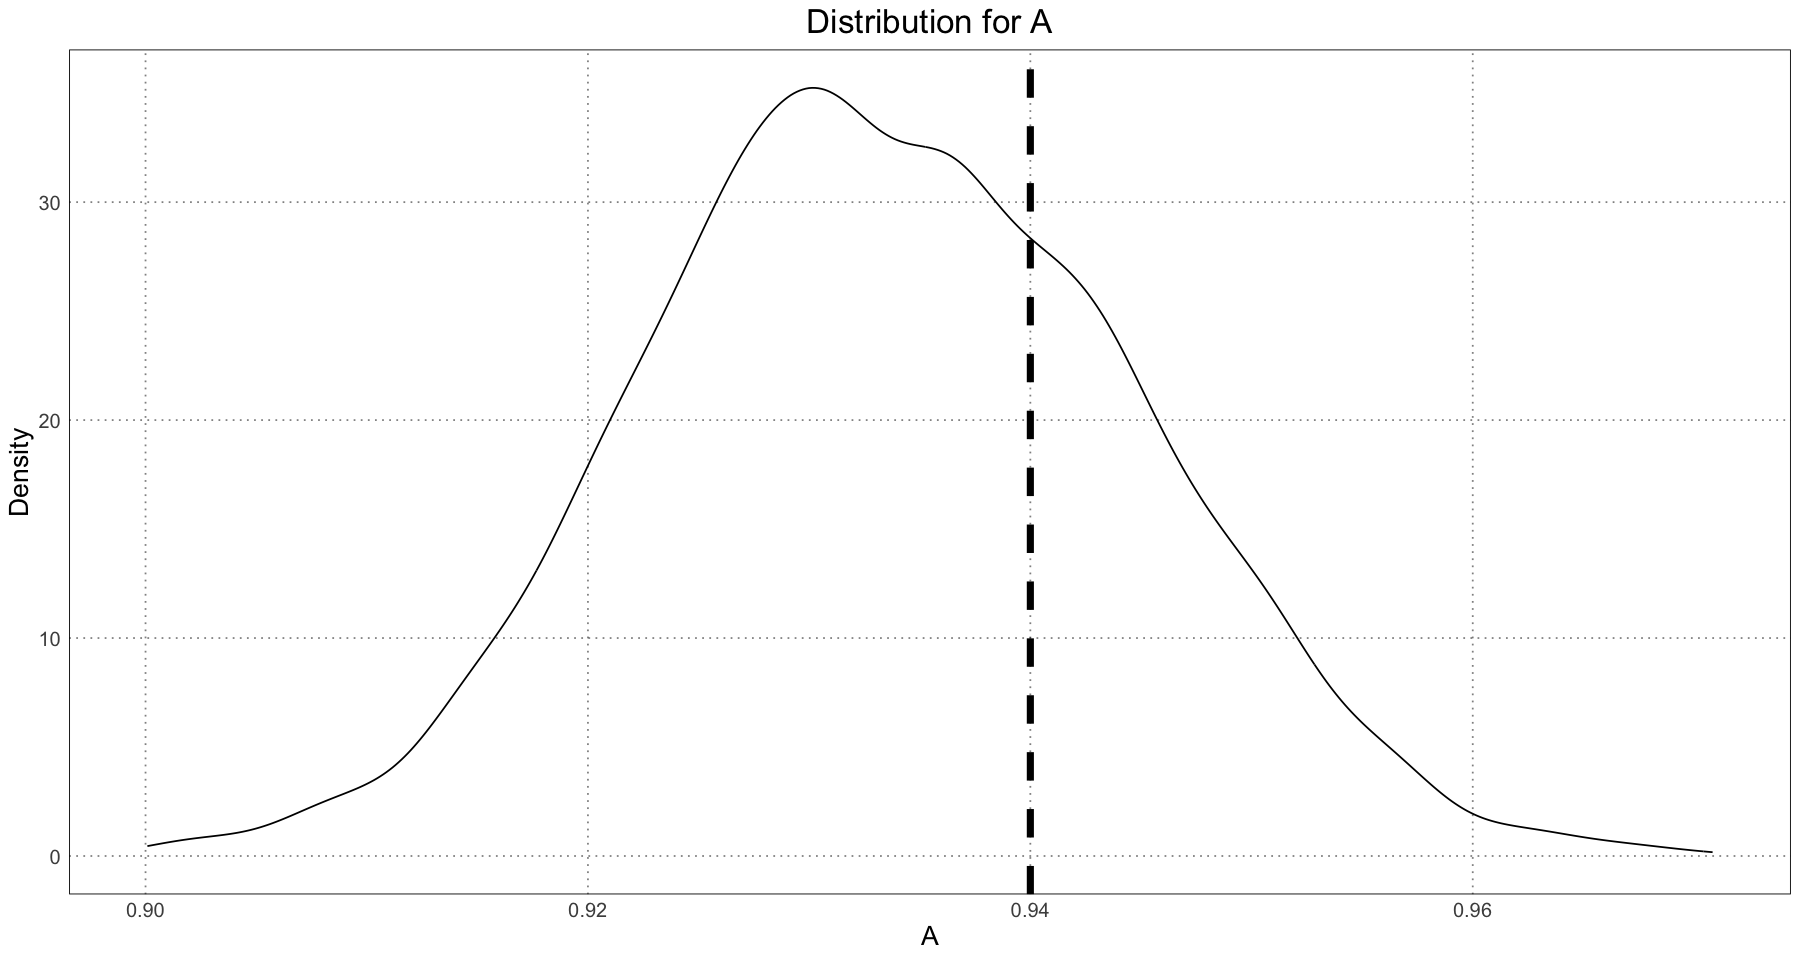

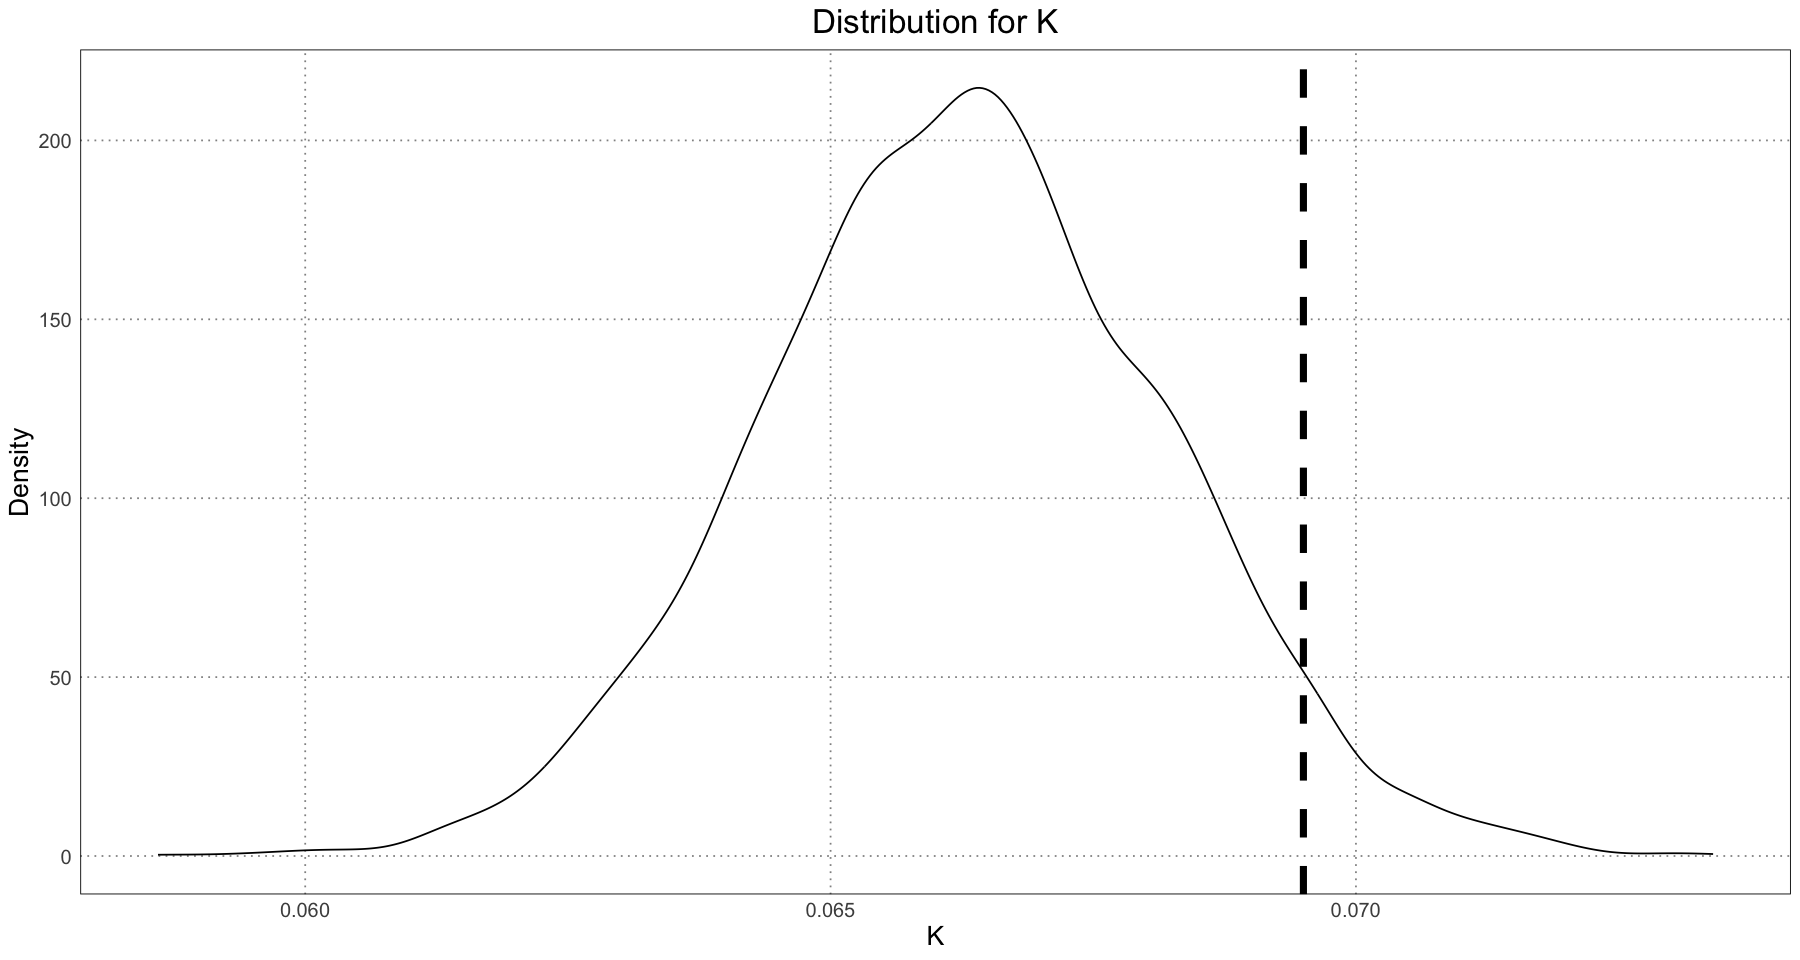

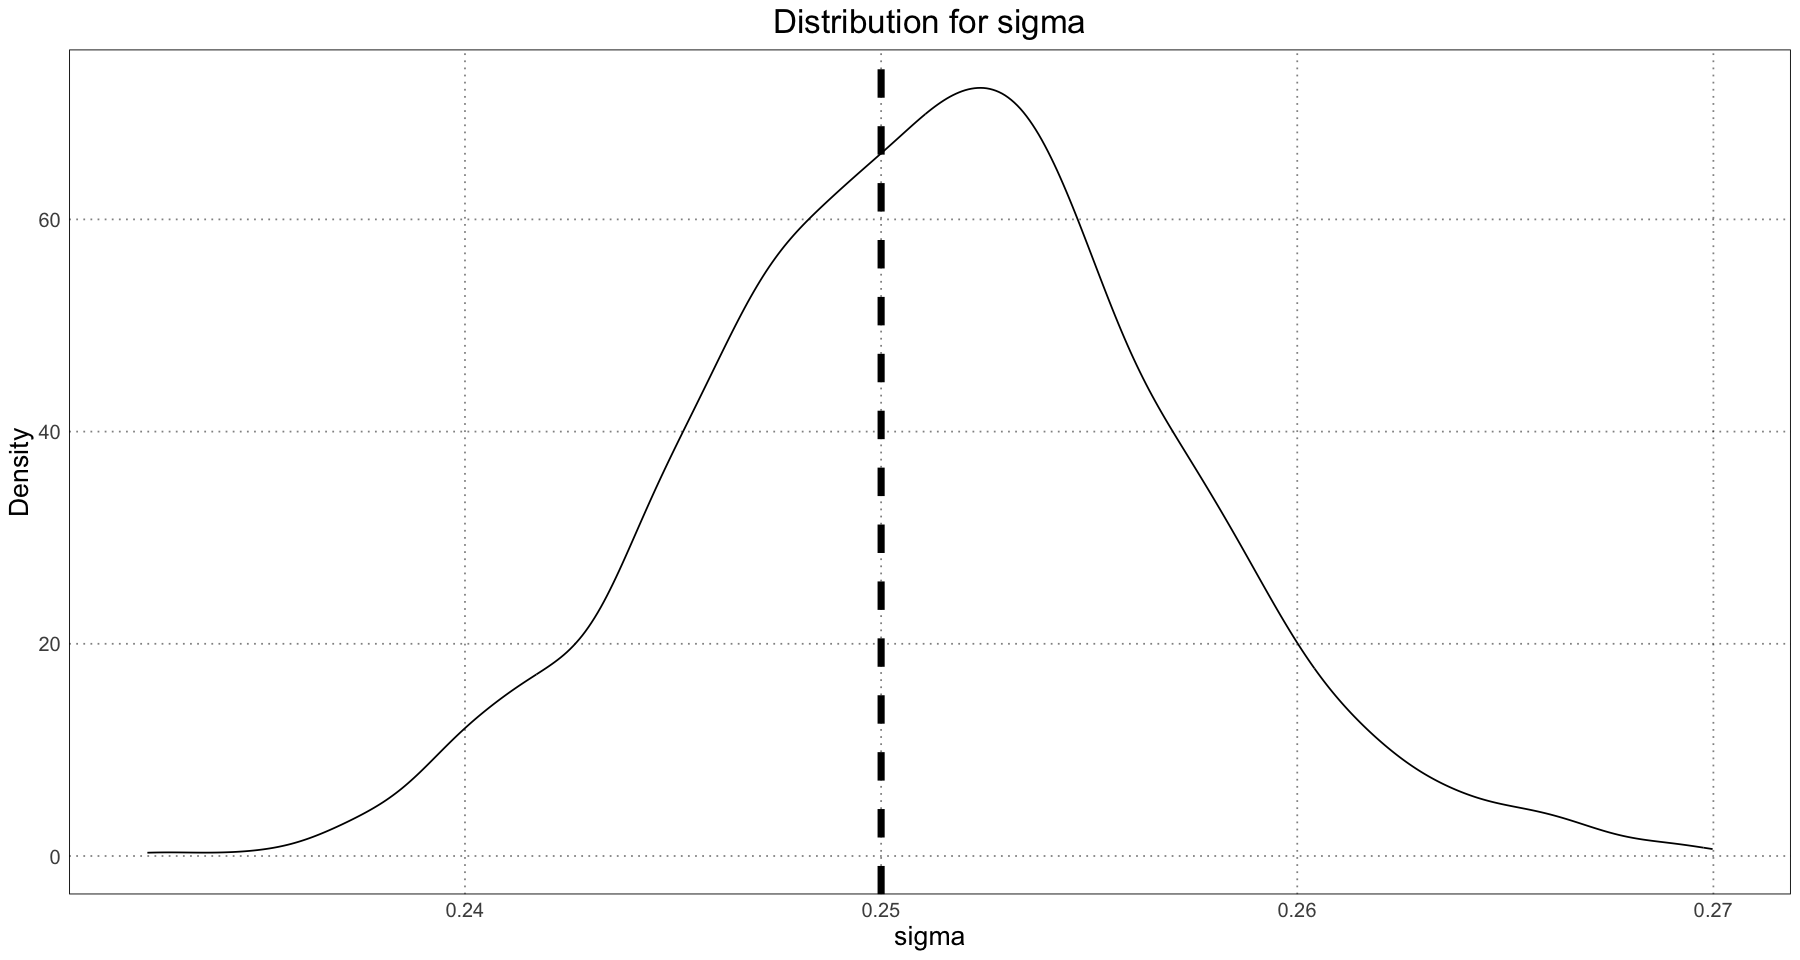

In [9]:
ggplot(data.frame(x = samples[['L']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    geom_vline(xintercept = actual_male_params[['L']], linewidth = 2, linetype = 'dashed') +
    labs(x = "L", y = "Density", title = "Distribution for L") +
    custom_theme()
ggplot(data.frame(x = samples[['A']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    geom_vline(xintercept = actual_male_params[['A']], linewidth = 2, linetype = 'dashed') +
    labs(x = "A", y = "Density", title = "Distribution for A") +
    custom_theme()
ggplot(data.frame(x = samples[['K']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    geom_vline(xintercept = actual_male_params[['K']], linewidth = 2, linetype = 'dashed') +
    labs(x = "K", y = "Density", title = "Distribution for K") +
    custom_theme()
ggplot(data.frame(x = samples[['sigma_length']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    geom_vline(xintercept = sigma, linewidth = 2, linetype = 'dashed') +
    labs(x = "sigma", y = "Density", title = "Distribution for sigma") +
    custom_theme()

Now the priors:

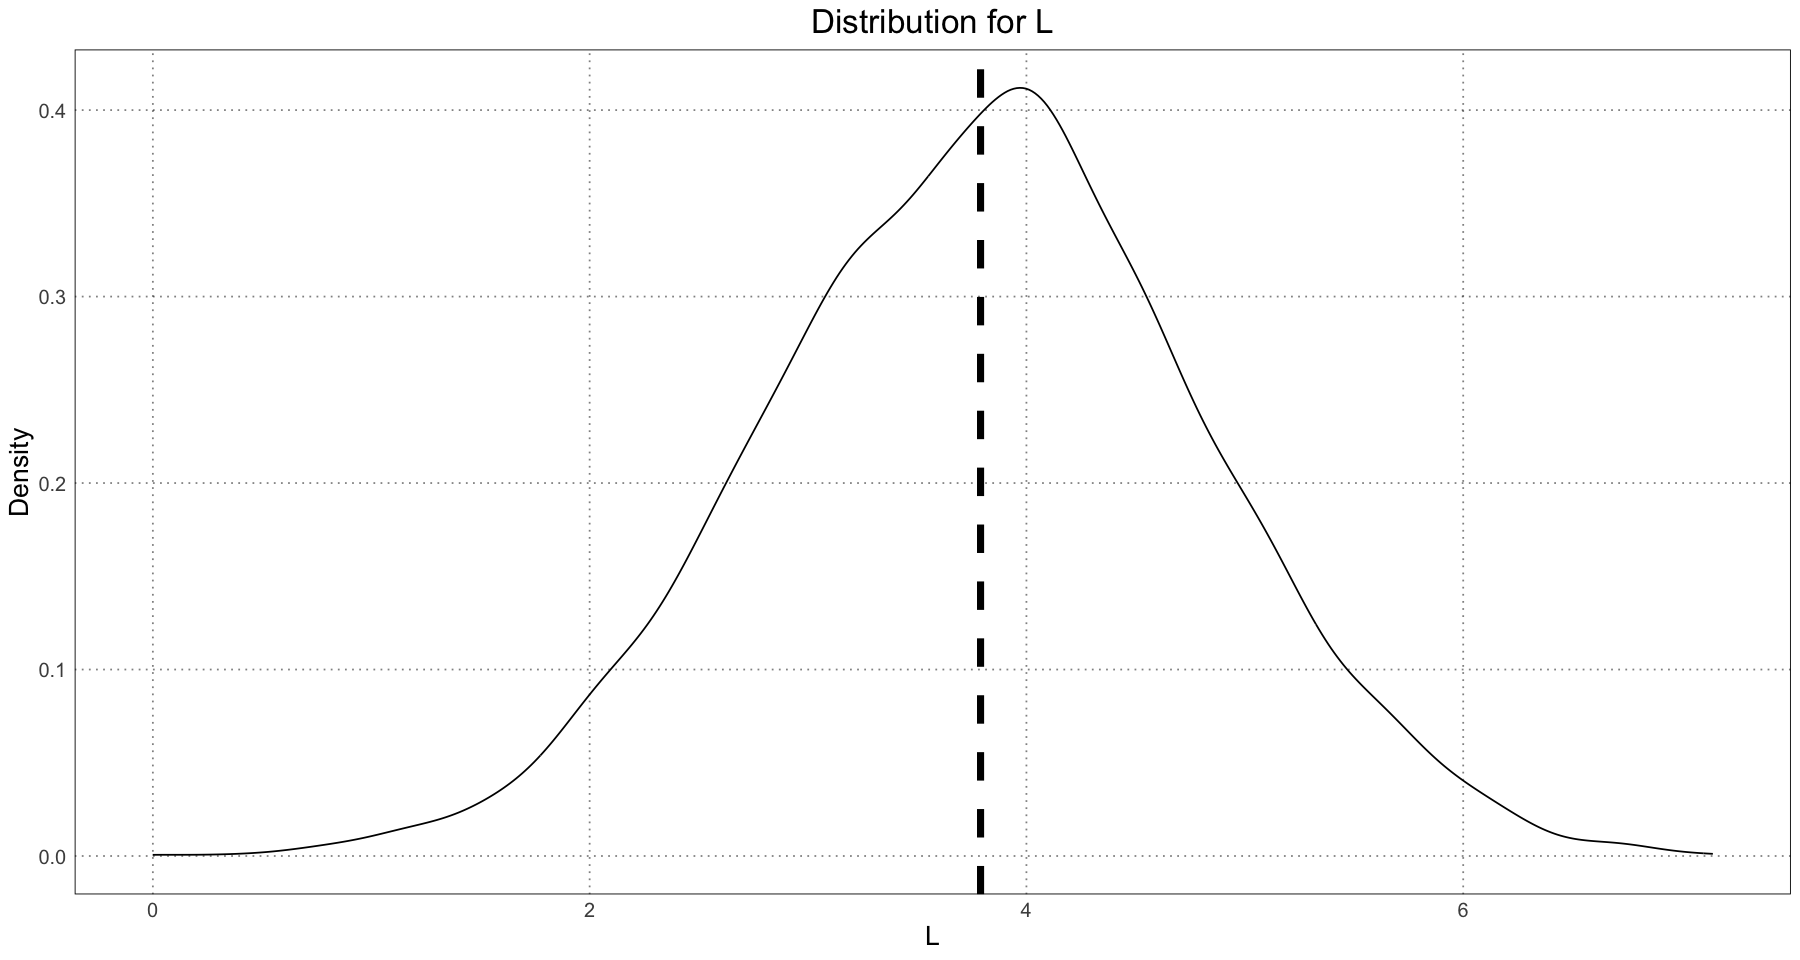

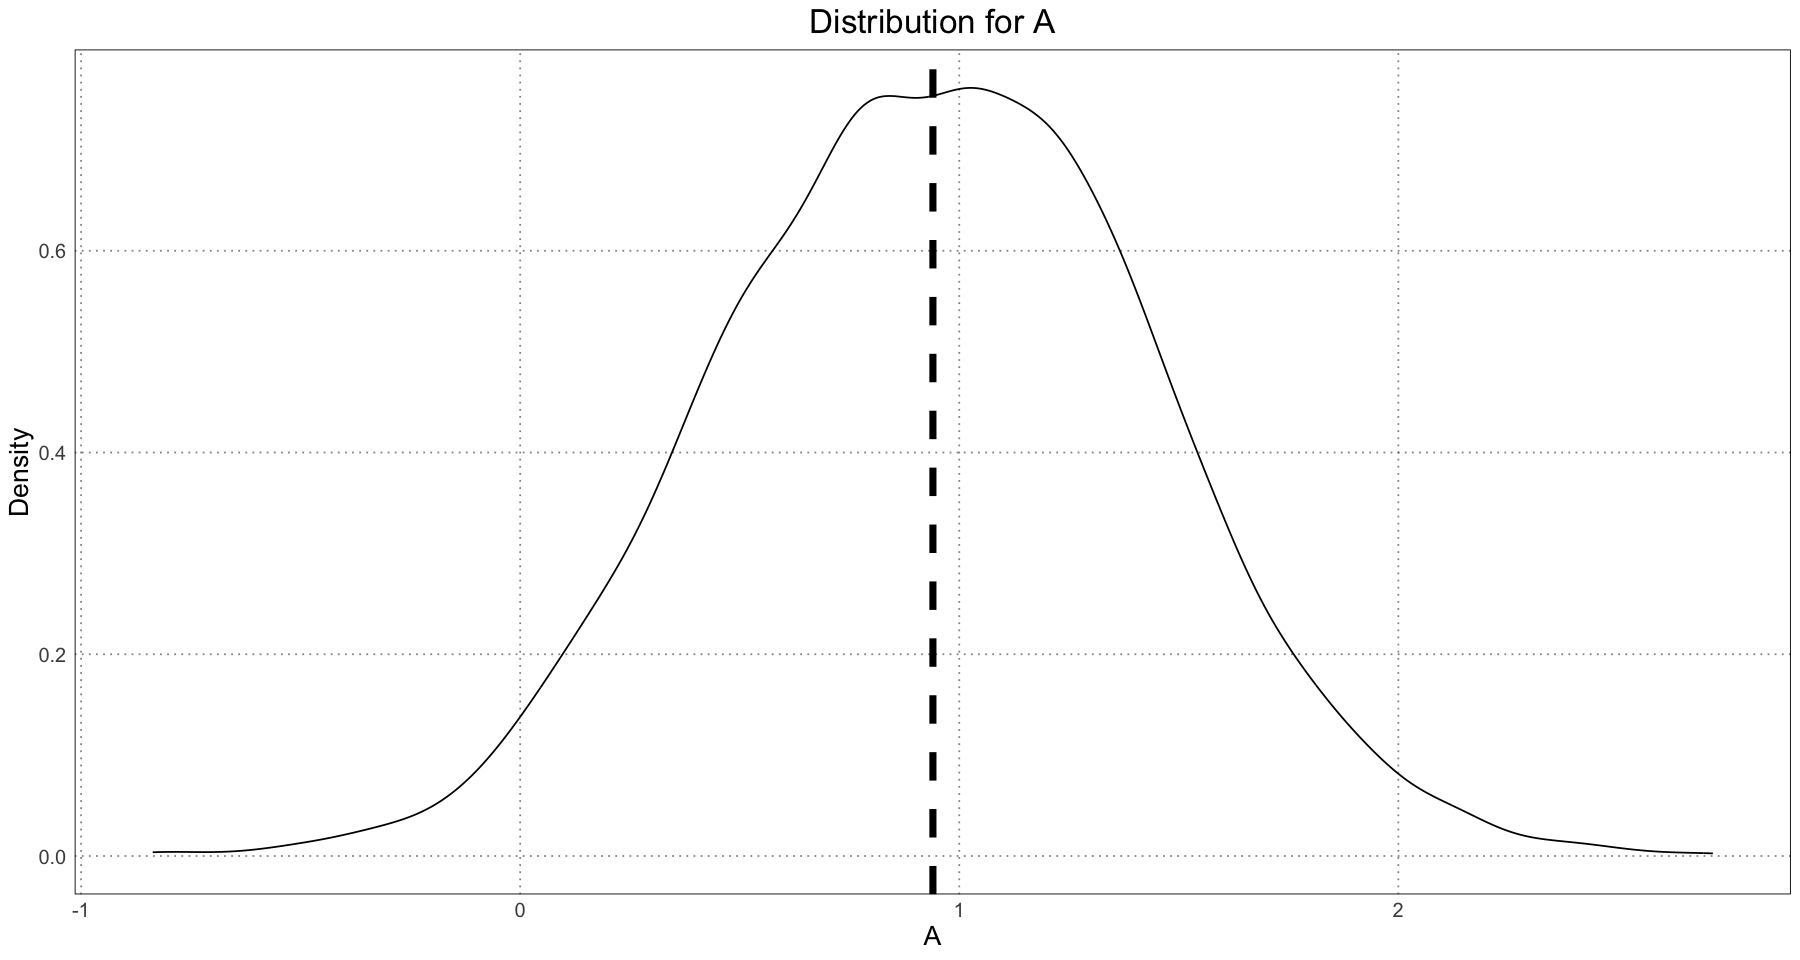

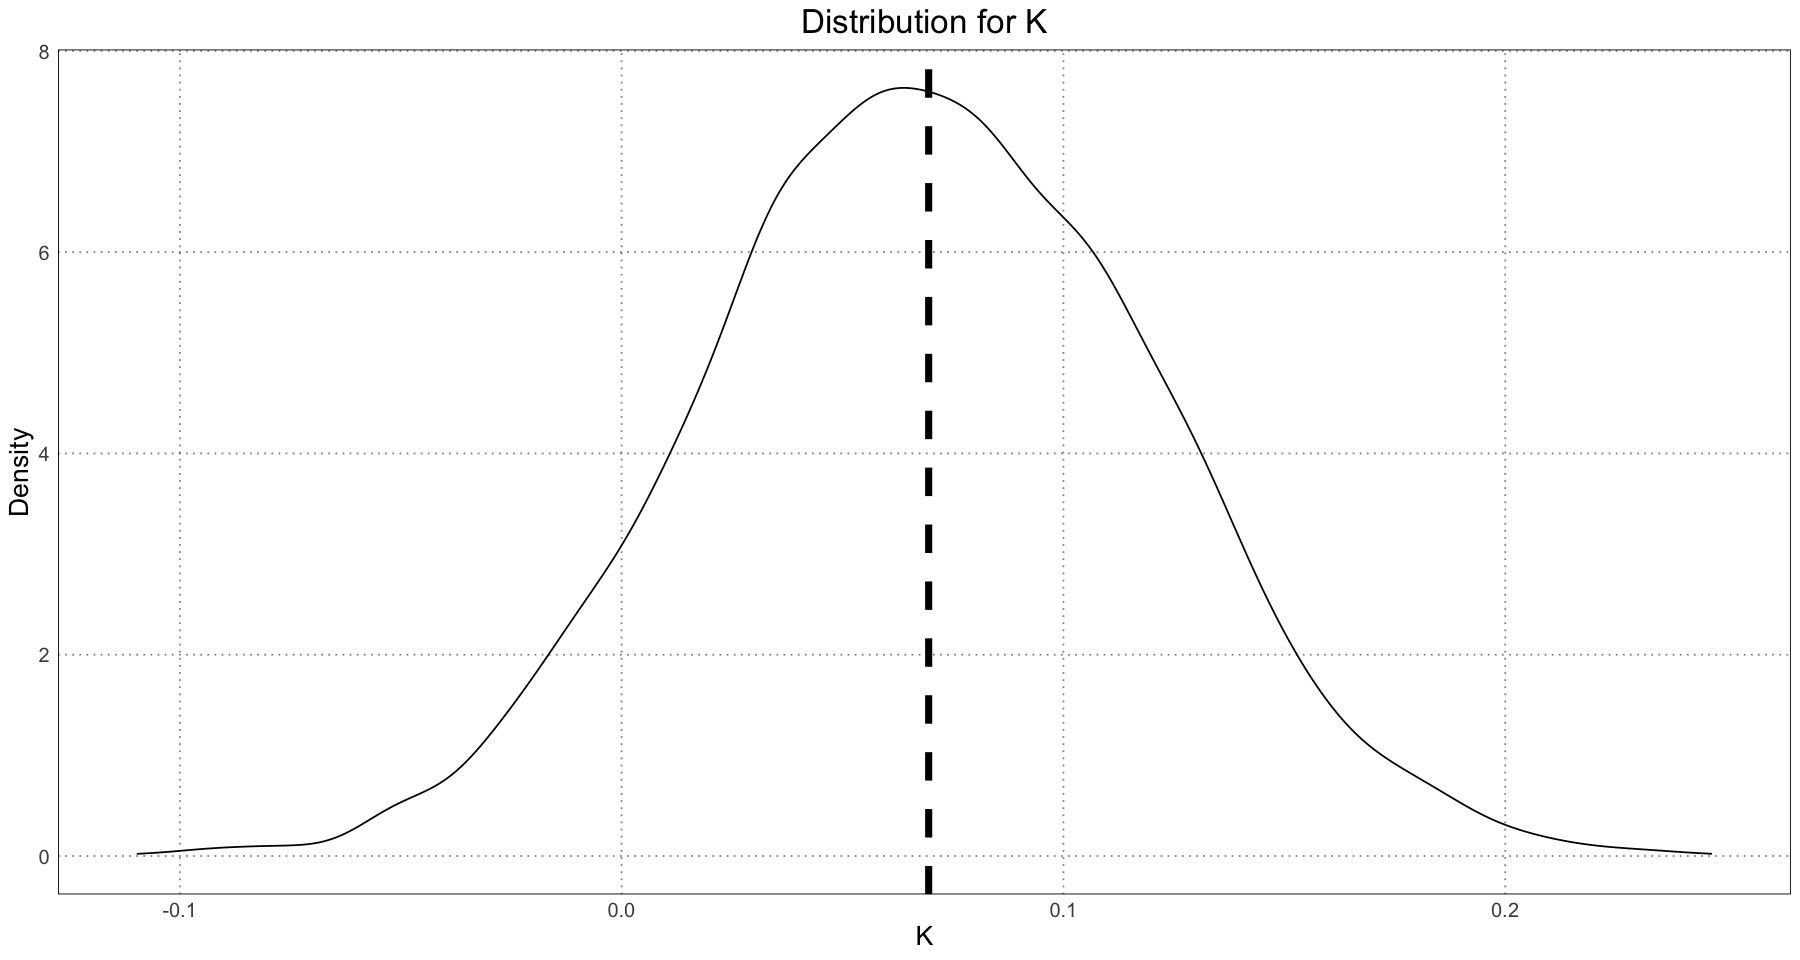

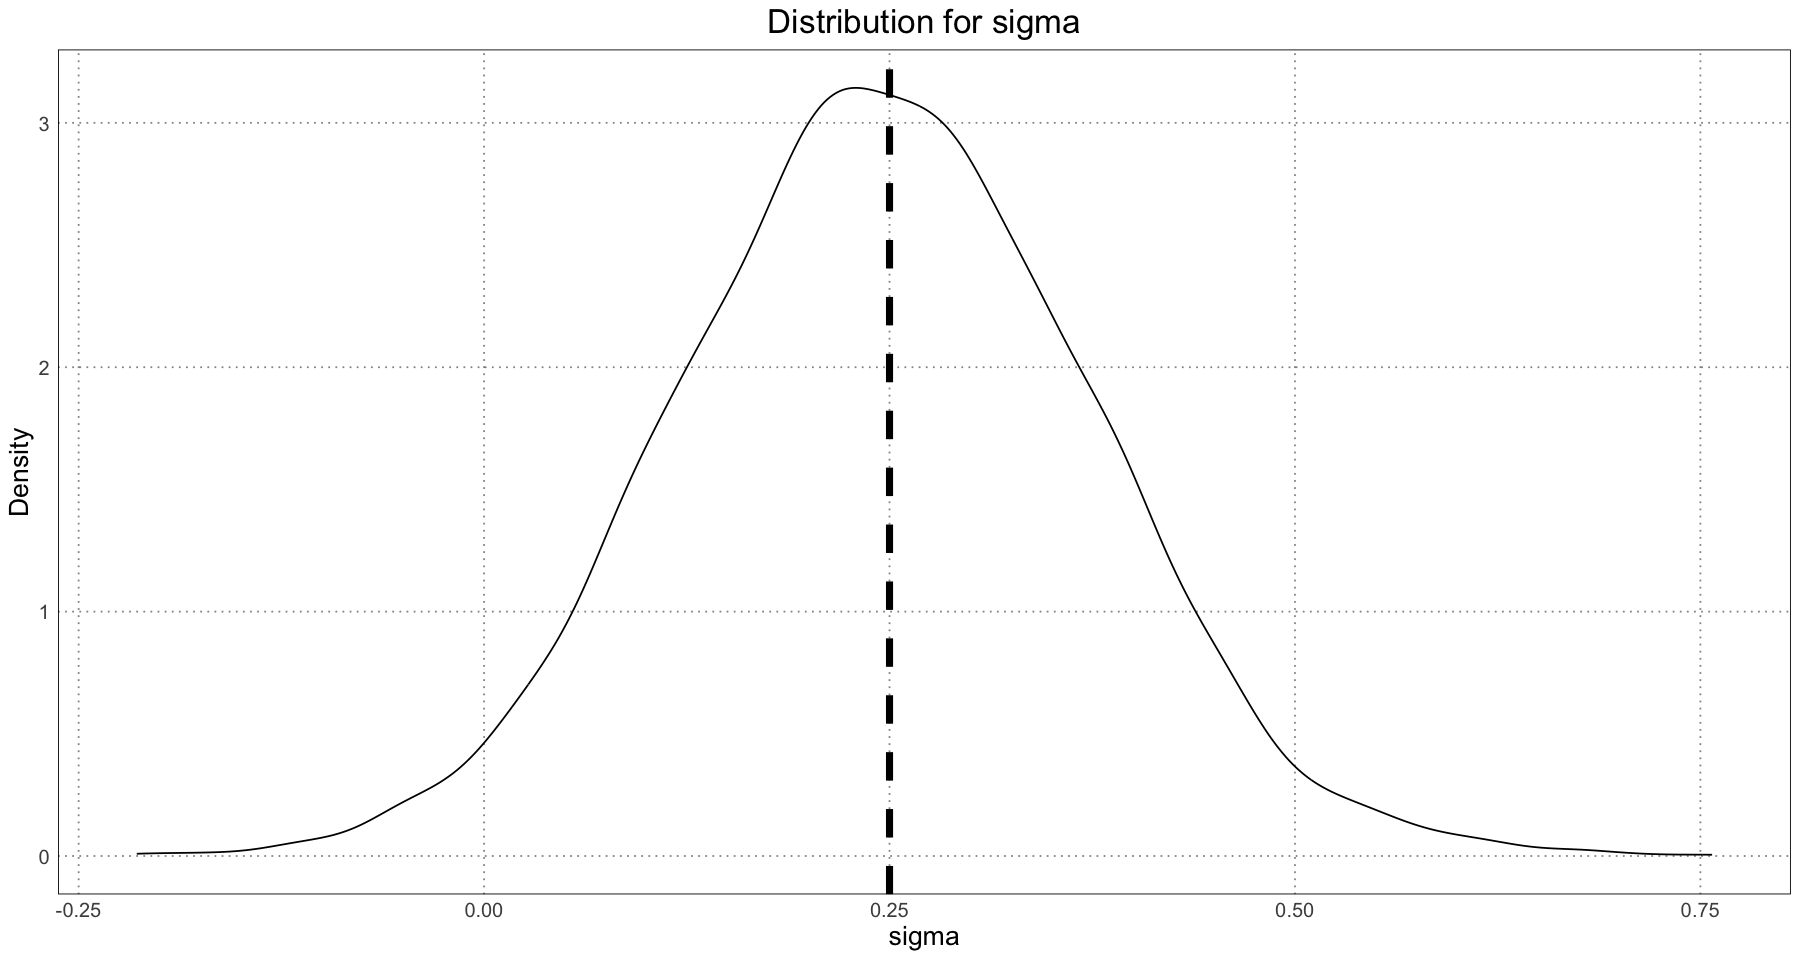

In [10]:
ggplot(data.frame(x = samples[['prior_L']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    geom_vline(xintercept = actual_male_params[['L']], linewidth = 2, linetype = 'dashed') +
    labs(x = "L", y = "Density", title = "Distribution for L") +
    custom_theme()
ggplot(data.frame(x = samples[['prior_A']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    geom_vline(xintercept = actual_male_params[['A']], linewidth = 2, linetype = 'dashed') +
    labs(x = "A", y = "Density", title = "Distribution for A") +
    custom_theme()
ggplot(data.frame(x = samples[['prior_K']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    geom_vline(xintercept = actual_male_params[['K']], linewidth = 2, linetype = 'dashed') +
    labs(x = "K", y = "Density", title = "Distribution for K") +
    custom_theme()
ggplot(data.frame(x = samples[['prior_sigma_length']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    geom_vline(xintercept = sigma, linewidth = 2, linetype = 'dashed') +
    labs(x = "sigma", y = "Density", title = "Distribution for sigma") +
    custom_theme()

Posterior and prior:

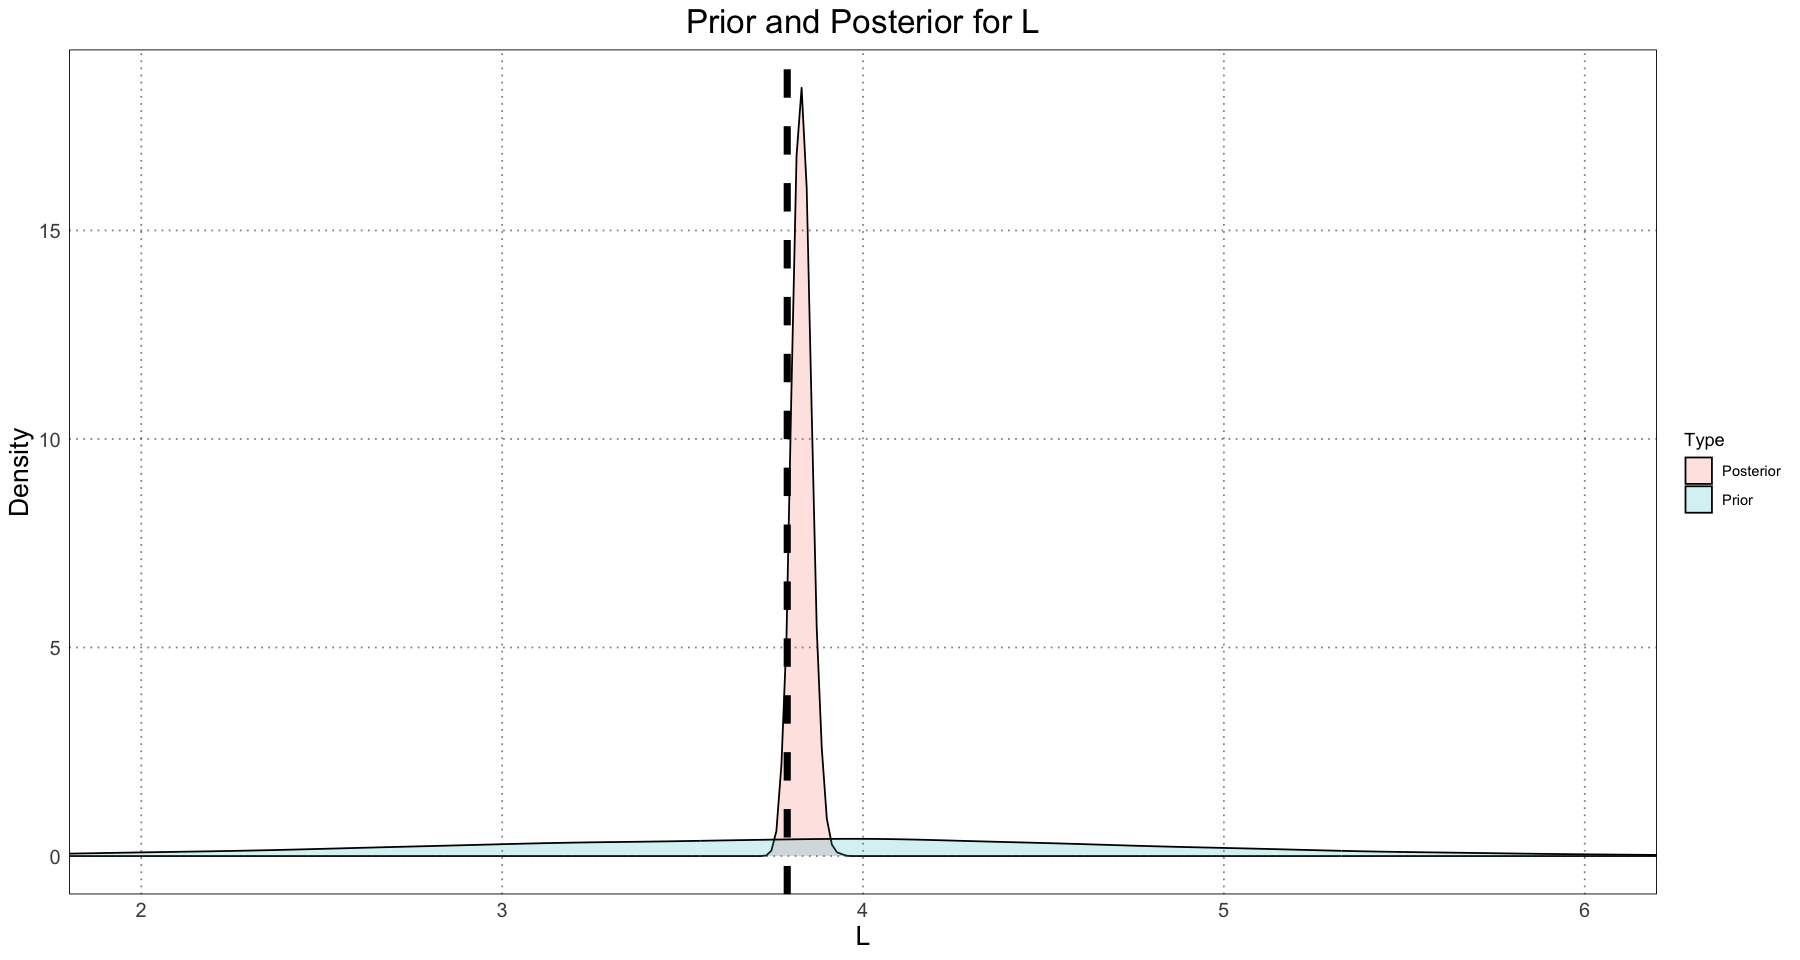

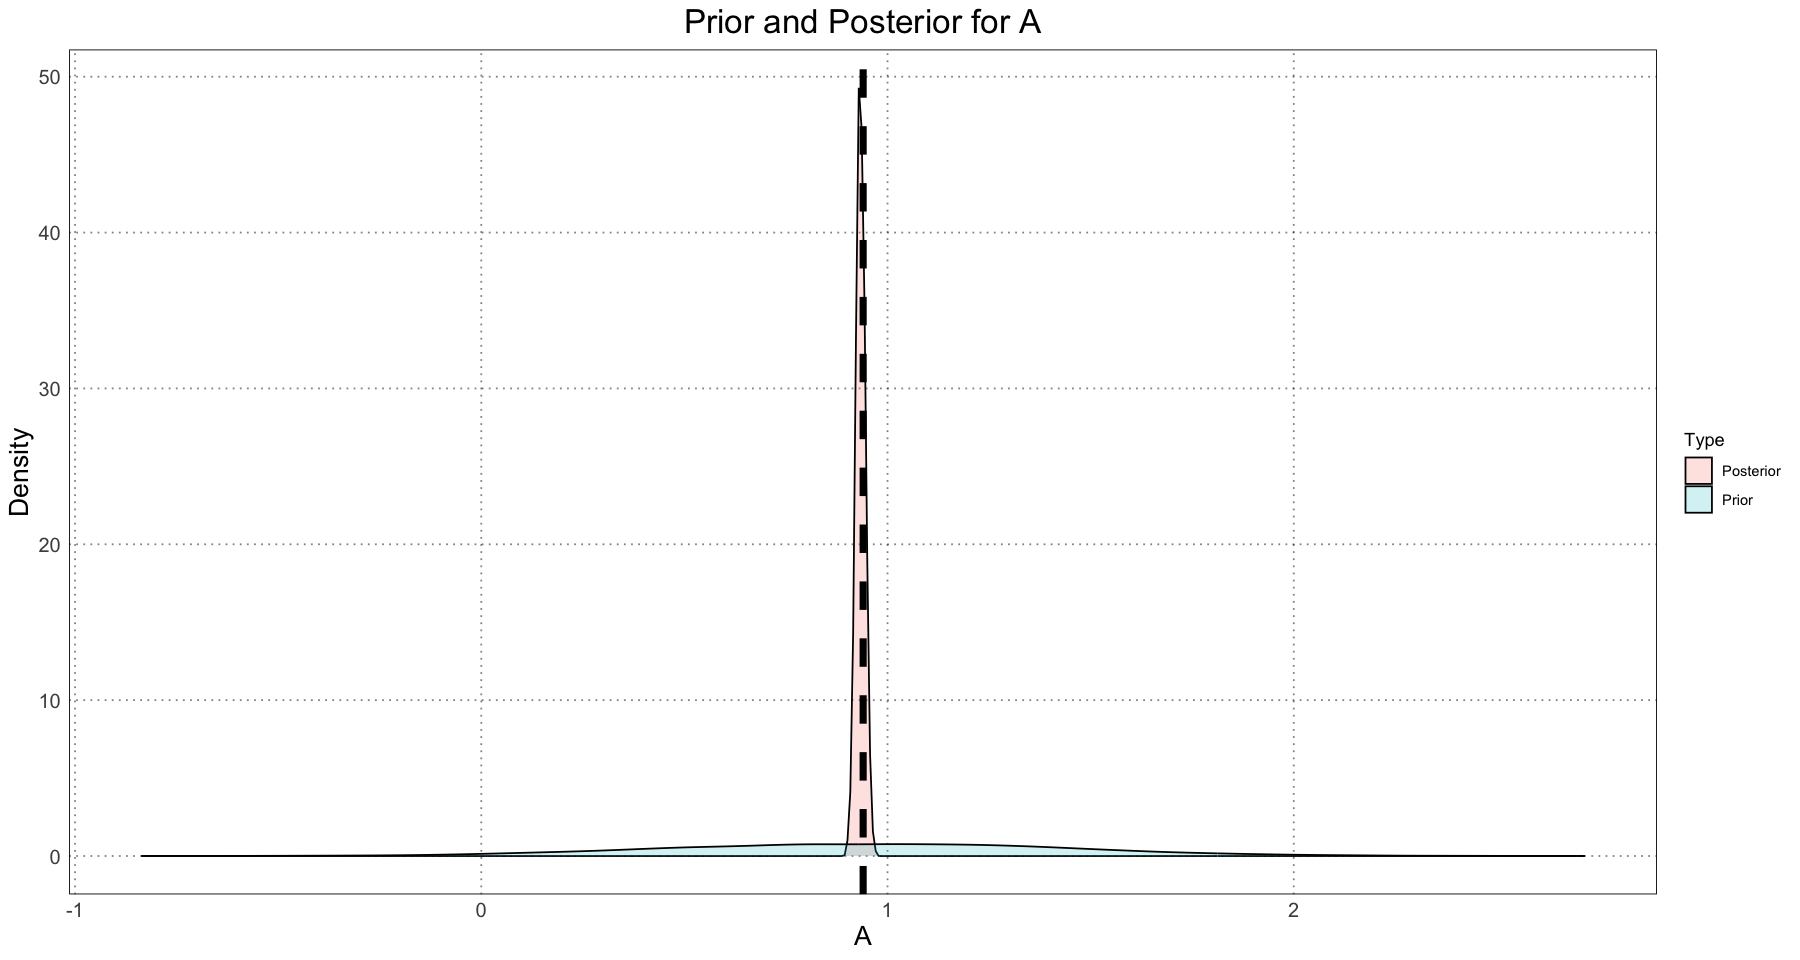

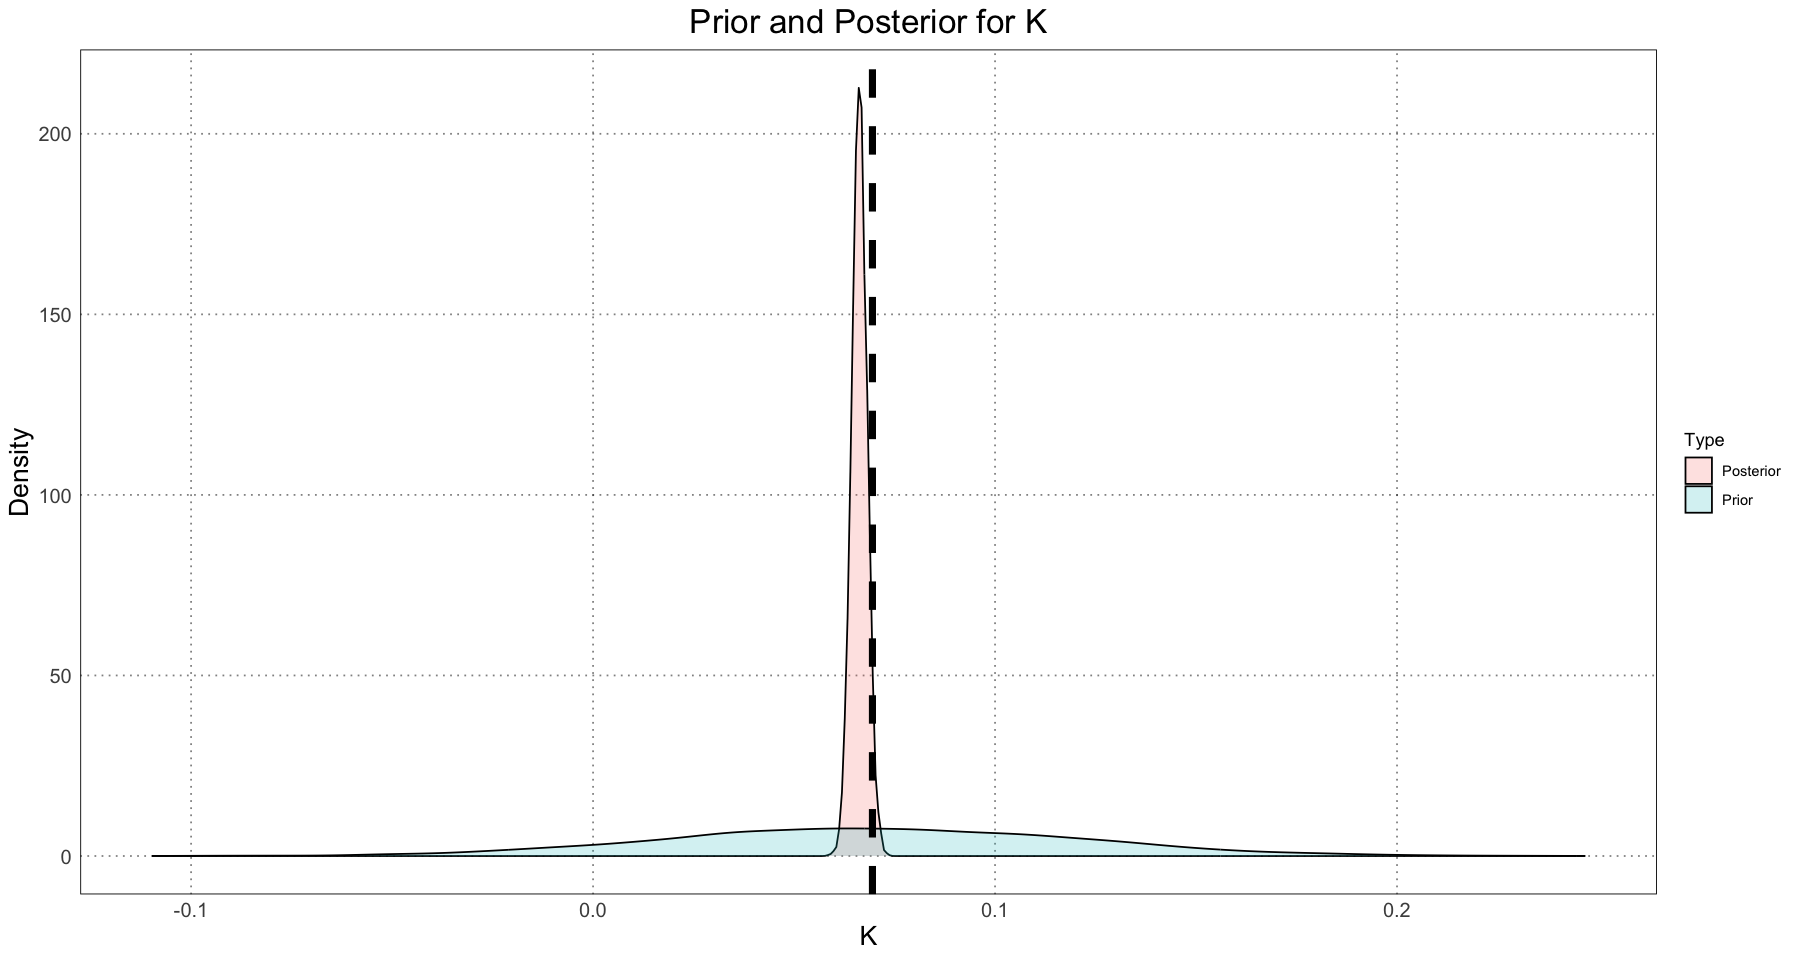

In [11]:
prior_and_posterior <- rbind(
    data.frame(x = samples[['L']], type="Posterior"),
    data.frame(x = samples[['prior_L']], type="Prior")
)
ggplot(prior_and_posterior, aes(x, group = type, fill = type)) +
    geom_density(aes(y = after_stat(density)), alpha = 0.2) +
    labs(x = "L", y = "Density", title = "Prior and Posterior for L", fill = "Type") +
    geom_vline(xintercept = actual_male_params[['L']], linewidth = 2, linetype = 'dashed') +
    coord_cartesian(xlim = c(2, 6)) +
    custom_theme()

prior_and_posterior <- rbind(
    data.frame(x = samples[['A']], type="Posterior"),
    data.frame(x = samples[['prior_A']], type="Prior")
)
ggplot(prior_and_posterior, aes(x, group = type, fill = type)) +
    geom_density(aes(y = after_stat(density)), alpha = 0.2) +
    labs(x = "A", y = "Density", title = "Prior and Posterior for A", fill = "Type") +
    geom_vline(xintercept = actual_male_params[['A']], linewidth = 2, linetype = 'dashed') +
    custom_theme()

prior_and_posterior <- rbind(
    data.frame(x = samples[['K']], type="Posterior"),
    data.frame(x = samples[['prior_K']], type="Prior")
)
ggplot(prior_and_posterior, aes(x, group = type, fill = type)) +
    geom_density(aes(y = after_stat(density)), alpha = 0.2) +
    labs(x = "K", y = "Density", title = "Prior and Posterior for K", fill = "Type") +
    geom_vline(xintercept = actual_male_params[['K']], linewidth = 2, linetype = 'dashed') +
    custom_theme()

A few things are immediately clear:
1. Our posterior estimate is pretty good
1. Our priors were ridiculously wide

In fact, the priors are so wide the they almost don't make sense. For instance, let's plot the actual curve against a selection of curves drawn from the prior distribution.

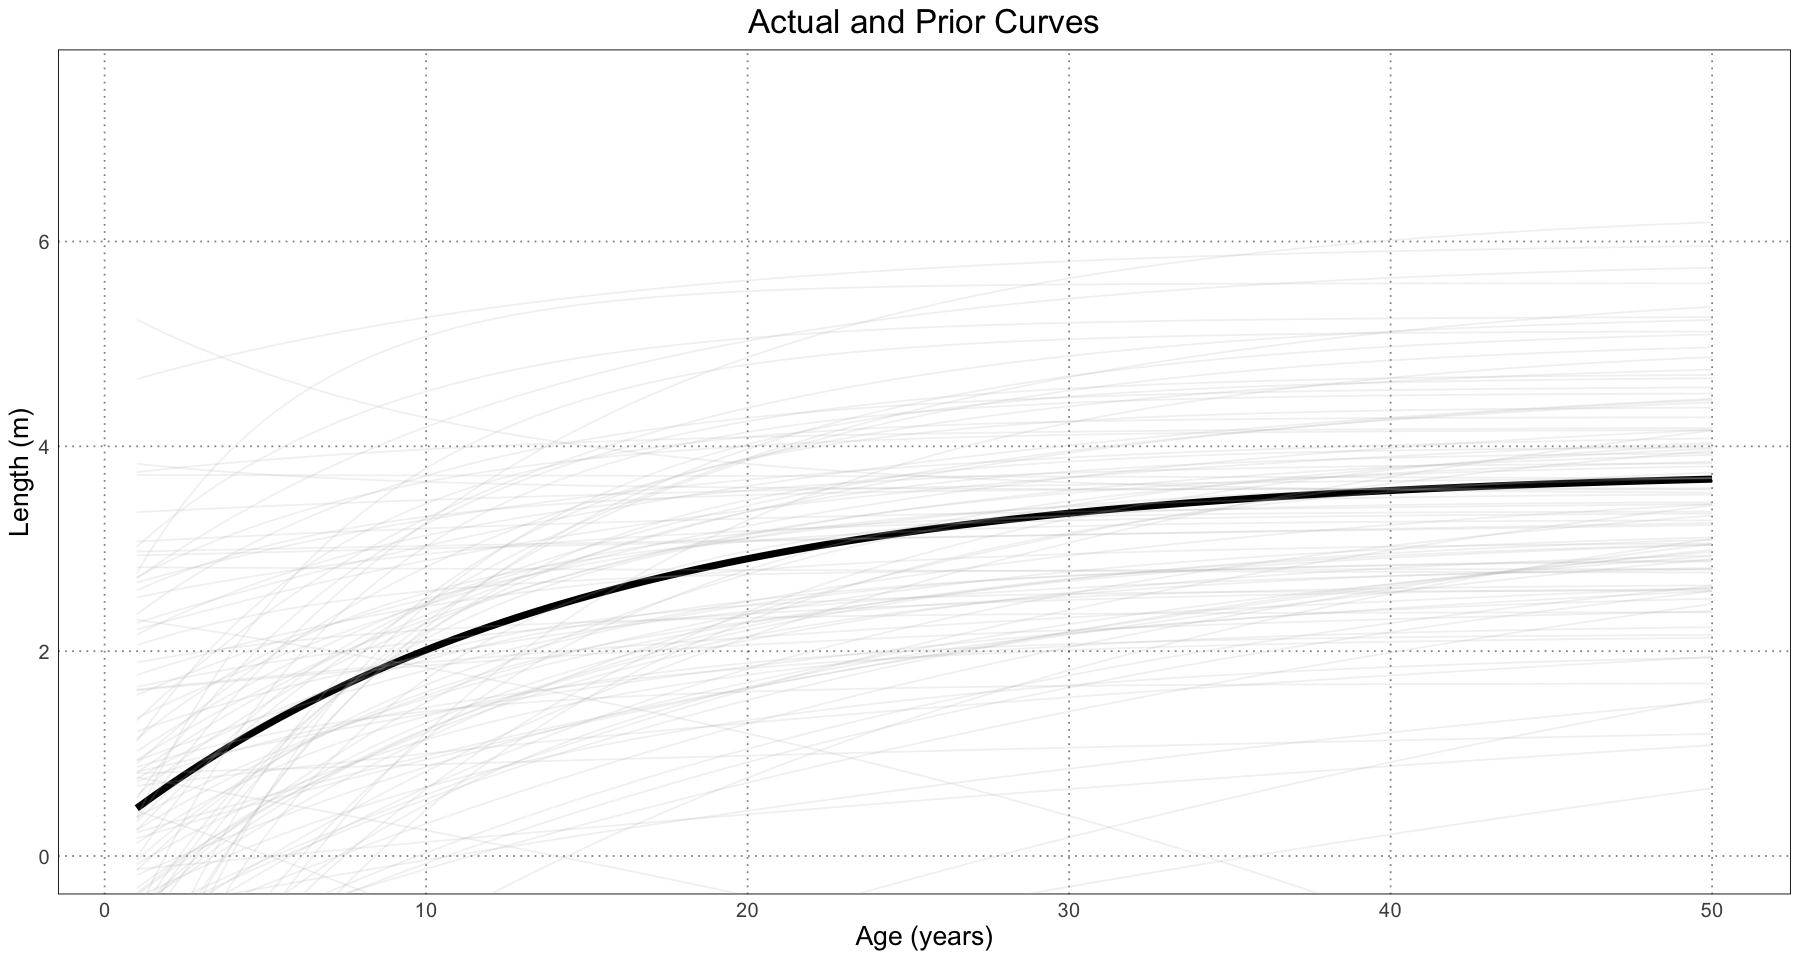

In [12]:
curve_ages <- seq(1, ALLIGATOR_MAX_LIFESPAN, length.out = 100)
actual_curve_lengths <- generalized_von_bertalanffy(curve_ages,L = actual_male_params[['L']], A = actual_male_params[['A']], K = actual_male_params[['K']])

curve_data <- data.frame(age = curve_ages, length = actual_curve_lengths)

p <- ggplot(curve_data, aes(age, length)) +
    geom_line(linewidth = 2) +
    labs(x = "Age (years)", y = "Length (m)", title = "Actual and Prior Curves") +
    coord_cartesian(ylim = c(0, 7.5)) +
    custom_theme()

for (i in 1:100) {
    sample_index <- sample(1:length(samples[['L']]), 1)
    L <- samples[['prior_L']][sample_index]
    A <- samples[['prior_A']][sample_index]
    K <- samples[['prior_K']][sample_index]
    prior_curve_length <- generalized_von_bertalanffy(curve_ages, L = L, A = A, K = K)
    prior_data <- data.frame(age = curve_age, length = prior_curve_length)
    p <- p + 
        geom_line(data = prior_data, mapping = aes(age, length), colour = 'grey', alpha = 0.2)
}
print(p)

As you can see, we are basically saying that we have very little idea how alligators grow.

By contrast, let's see how the posterior distributions look in the same graph.

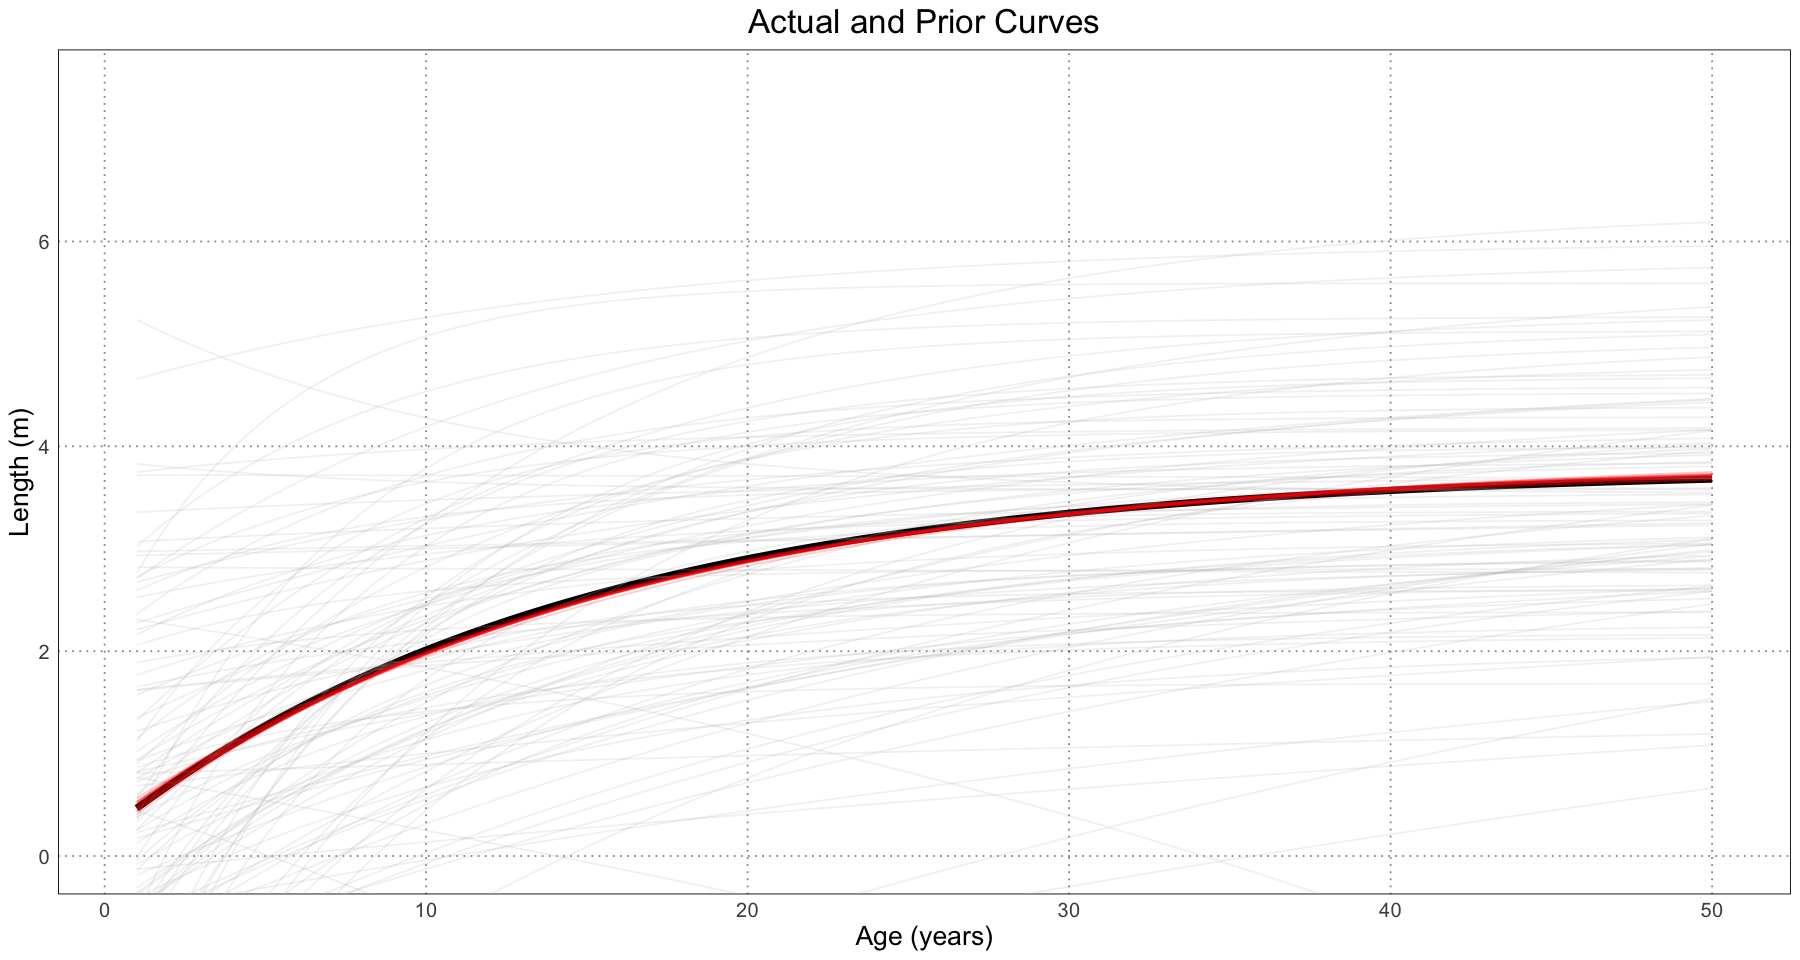

In [13]:
for (i in 1:20) {
    sample_index <- sample(1:length(samples[['L']]), 1)
    L <- samples[['L']][sample_index]
    A <- samples[['A']][sample_index]
    K <- samples[['K']][sample_index]
    prior_curve_length <- generalized_von_bertalanffy(curve_ages, L = L, A = A, K = K)
    prior_data <- data.frame(age = curve_age, length = prior_curve_length)
    p <- p + 
        geom_line(data = prior_data, mapping = aes(age, length), colour = 'red', alpha = 0.2)
}
print(p)

As you see, the posteriors are all tightly clstered around the actual curve, as we expect.

For now we're going to ignore the issue of the priors. We are certainly going to have to reexamine them later, once we start looking at cases where there are fewer pieces of data. That's because the influence of the priors in this case (with lots of samples) is quite minimal, whereas with fewer pieces of data the influce will increase.

Next, let's see if we can extract the distribution of the posterior level of sexual dimorphism, $L_m - L_f$. For this, we're going to have to fit separate curves to the male and female alligators and then look at the distribution of the differences in this parameter. Again, to keep things slightly simpler I'm going to ignore the dependence of the standard deviation $\sigma$ on the mean length,just keeping it as a constant for now.

In [14]:
num_samples <- 1e3
test_ages <- runif(num_samples, 1, ALLIGATOR_MAX_LIFESPAN)
sigma <- 0.25

female_lengths_mean <- generalized_von_bertalanffy(test_ages, L = actual_female_params[['L']], A = actual_female_params[['A']], K = actual_female_params[['K']])
female_lengths <- rnorm(num_samples, mean = female_lengths_mean, sd = sigma)

male_lengths_mean <- generalized_von_bertalanffy(test_ages, L = actual_male_params[['L']], A = actual_male_params[['A']], K = actual_male_params[['K']])
male_lengths <- rnorm(num_samples, mean = male_lengths_mean, sd = sigma)

# fit a curve to the whole population to use as a prior
population_data <- data.frame(
    age = rep(test_ages, 2),
    length = c(female_lengths, male_lengths),
    sex = rep(c("F", "M"), each = length(test_ages))
)
fit.population <- nlsLM(length ~ generalized_von_bertalanffy(age, L, A, K), data = population_data, start = generate_initial_vb_params(population_data))
fit.population

Nonlinear regression model
  model: length ~ generalized_von_bertalanffy(age, L, A, K)
   data: population_data
     L      K      A 
3.2495 0.0819 0.9404 
 residual sum-of-squares: 328.7

Number of iterations to convergence: 4 
Achieved convergence tolerance: 1.49e-08

In [15]:
coef(fit.population)

L          K          A 
3.24953606 0.08189986 0.94042359

We're now going to build a model where the prior is a loose cluster around the population values and apply that to the male and female samples. Then we'll look at the distribution of the difference in their $L$ parameters. Note that these values are taken from one particular run / sample - they will be slightly different for each one.

In [16]:
population_prior_model <- "
data {
    int<lower = 0> N; // number of samples
    vector[N] length; // a vector of the lengths
    vector[N] age; // vector of the ages; index correlates with length (so length[i] happened at age[i])
}

parameters {
    real<lower = 0> L;
    real<lower = 0> A;
    real<lower = 0> K;
    real<lower = 0> sigma_length;
}

model {
    vector[N] mean_length;

    L ~ normal(3.280, 0.5);
    K ~ normal(0.0779, 0.025);
    A ~ normal(0.92, 0.25);
    sigma_length ~ normal(0.25, 0.0625);
    mean_length = L * (1 - A * exp(-K * age));
    length ~ normal(mean_length, sigma_length);
}

generated quantities {
    real prior_L = normal_rng(3.280, 0.5);
    real prior_K = normal_rng(0.0779, 0.025);
    real prior_A = normal_rng(0.92, 0.25);
    real prior_sigma_length = normal_rng(0.25, 0.0625);
}
"

male_information <- population_data[population_data$sex == "M", ]
male_data <- list(
    N = nrow(male_information),
    age = male_information$age,
    length = male_information$length
)
model.male <- stan(model_code = population_prior_model, data = male_data)
model.male

female_information <- population_data[population_data$sex == "F", ]
female_data <- list(
    N = nrow(female_information),
    age = female_information$age,
    length = female_information$length
)
model.female <- stan(model_code = population_prior_model, data = female_data)
model.female

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff
L                    3.75    0.00 0.02   3.70   3.73   3.75   3.76   3.79  1619
A                    0.97    0.00 0.01   0.95   0.96   0.97   0.98   0.99  1895
K                    0.07    0.00 0.00   0.07   0.07   0.07   0.08   0.08  1540
sigma_length         0.25    0.00 0.01   0.24   0.24   0.25   0.25   0.26  2413
prior_L              3.27    0.01 0.49   2.30   2.94   3.27   3.61   4.25  4141
prior_K              0.08    0.00 0.03   0.03   0.06   0.08   0.10   0.13  3705
prior_A              0.92    0.00 0.25   0.42   0.75   0.92   1.09   1.41  3867
prior_sigma_length   0.25    0.00 0.06   0.13   0.21   0.25   0.30   0.37  3932
lp__               891.81    0.04 1.38 888.41 891.10 892.10 892.84 893.56  1479
                   Rhat
L                   

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff
L                    2.77    0.00 0.02   2.73   2.76   2.77   2.78   2.80  1857
A                    0.91    0.00 0.02   0.88   0.90   0.91   0.92   0.94  1884
K                    0.09    0.00 0.00   0.09   0.09   0.09   0.10   0.10  1581
sigma_length         0.25    0.00 0.01   0.24   0.25   0.25   0.26   0.26  2716
prior_L              3.27    0.01 0.50   2.29   2.93   3.26   3.61   4.29  4084
prior_K              0.08    0.00 0.02   0.03   0.06   0.08   0.09   0.13  4168
prior_A              0.93    0.00 0.25   0.44   0.76   0.93   1.10   1.42  4242
prior_sigma_length   0.25    0.00 0.06   0.13   0.21   0.25   0.29   0.37  3994
lp__               873.32    0.04 1.44 869.68 872.58 873.68 874.38 875.09  1575
                   Rhat
L                   

For each of them, we can see that the generated values are in agreement with the function we used to generate the actual curves; we are recovering the original values. Now let's take a look at the difference in the $L$ parameters. For this, we will use a bootstrap method where we sample (with replacement) from the samples and then take their differences.

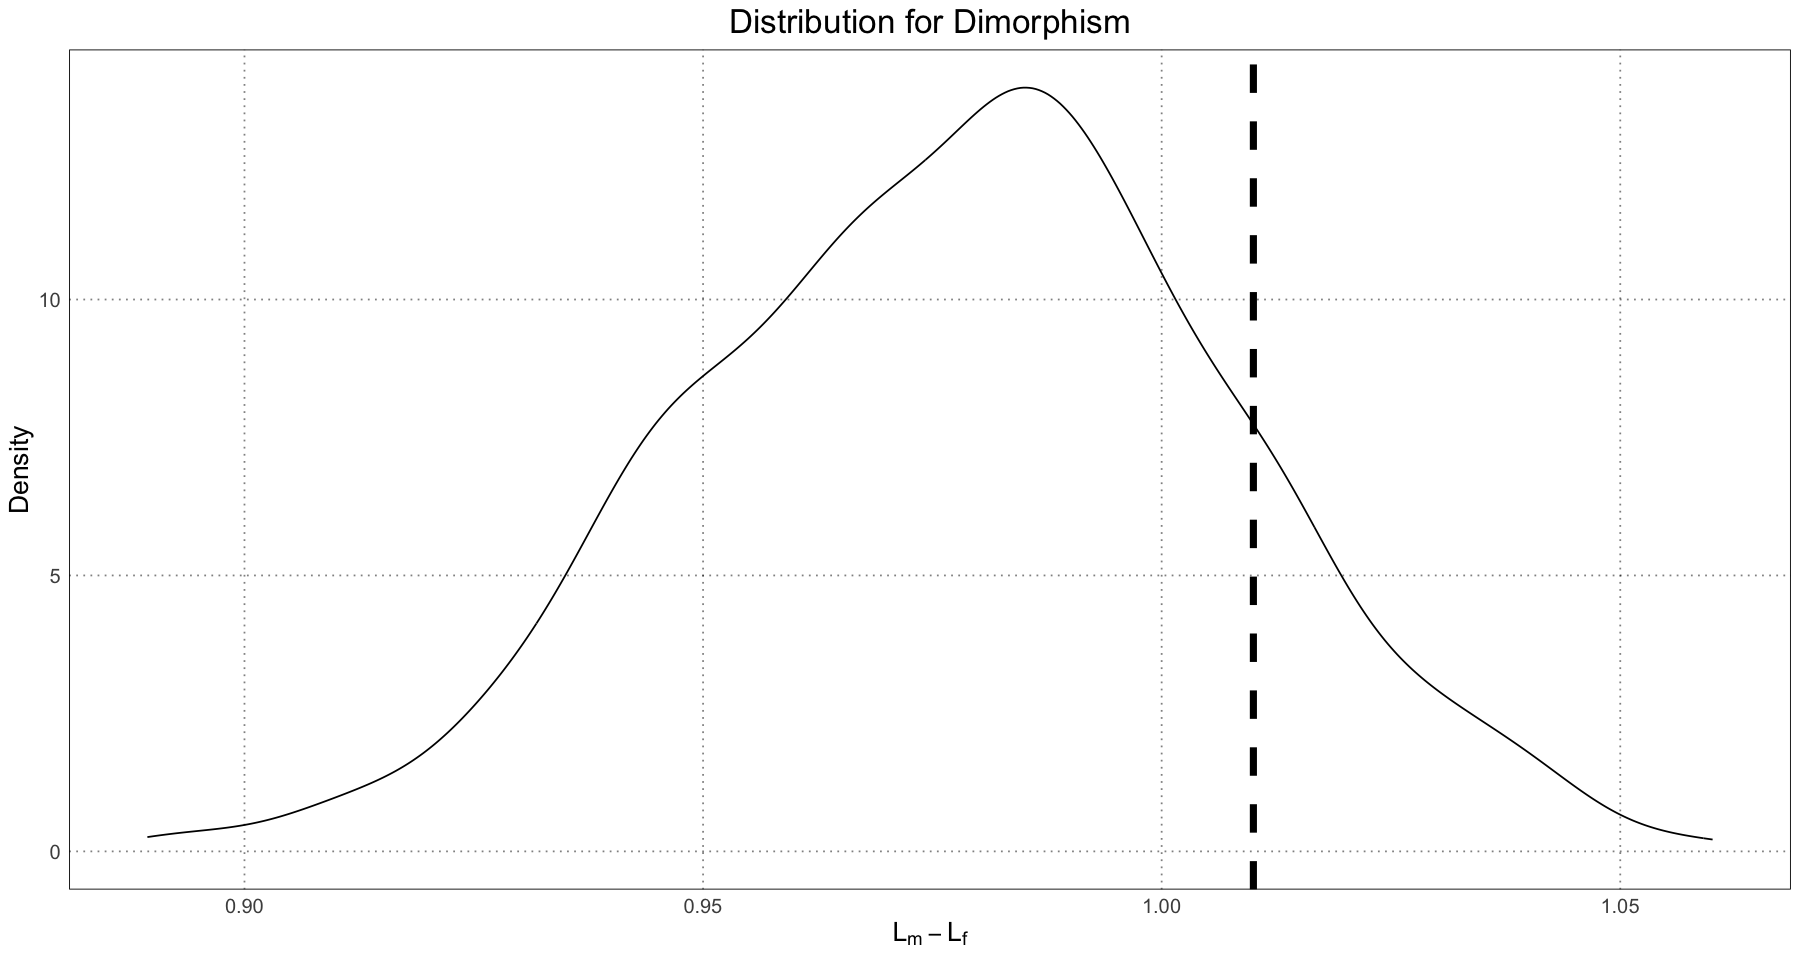

In [17]:
num_bootstrap_samples <- 1e3
female_sample <- extract(model.female)
male_sample <- extract(model.male)

female_bootstrap_L <- sample(female_sample[['L']], num_bootstrap_samples, replace = TRUE)
male_bootstrap_L <- sample(male_sample[['L']], num_bootstrap_samples, replace = TRUE)
bootstrap_diff <- male_bootstrap_L - female_bootstrap_L

ggplot(data.frame(x = bootstrap_diff), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    geom_vline(xintercept = actual_male_params[['L']] - actual_female_params[['L']], linewidth = 2, linetype = 'dashed') +
    labs(x = expression(L[m] - L[f]), y = "Density", title = "Distribution for Dimorphism") +
    custom_theme()

Great! So our value for the expected level of dimorphism is right where we expect it to be.

Now let's see what happens when we change the sample size. After all, 1000 samples of each sex would be extremely unusual when looking at extinct creatures. For now, we'll focus on just the $L$ parameter and see what happens as we vary the sample size.

In [18]:
sample_sizes <- c(2, 5, 10, 15, 20, 30, 50, 100)
L_param_data <- data.frame(
    sample_size = numeric(),
    lower = numeric(),
    mu = numeric(),
    upper = numeric()
)
for (sample_size in sample_sizes) {
    sample_ages <- runif(sample_size, 1, ALLIGATOR_MAX_LIFESPAN)
    sample_lengths <- rnorm(sample_size, mean = generalized_von_bertalanffy(sample_ages, L = actual_male_params[['L']], A = actual_male_params[['A']], K = actual_male_params[['K']]), sd = sigma)
    male_data <- list(
        N = sample_size,
        age = c(sample_ages),
        length = c(sample_lengths)
    )
    model.male <- stan(model_code = population_prior_model, data = male_data, iter = 16000)
    male_sample <- extract(model.male)
    L_sample <- male_sample[['L']]
    instance_data <- data.frame(
        sample_size = sample_size,
        lower = quantile(L_sample, 0.025),
        mu = mean(L_sample),
        upper = quantile(L_sample, 0.975)
    )
    L_param_data <- rbind(L_param_data, instance_data)
}
L_param_data

Warning message:
“There were 72 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“There were 9 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


sample_size lower    mu       upper   
2.5%    2         3.037831 3.515795 4.030077
2.5%1   5         2.836837 3.219092 3.747080
2.5%2  10         3.468205 3.802380 4.214011
2.5%3  15         3.617036 3.969573 4.394463
2.5%4  20         3.719971 3.970321 4.281229
2.5%5  30         3.554558 3.760760 4.017668
2.5%6  50         3.563787 3.751056 3.972094
2.5%7 100         3.574040 3.689357 3.817322

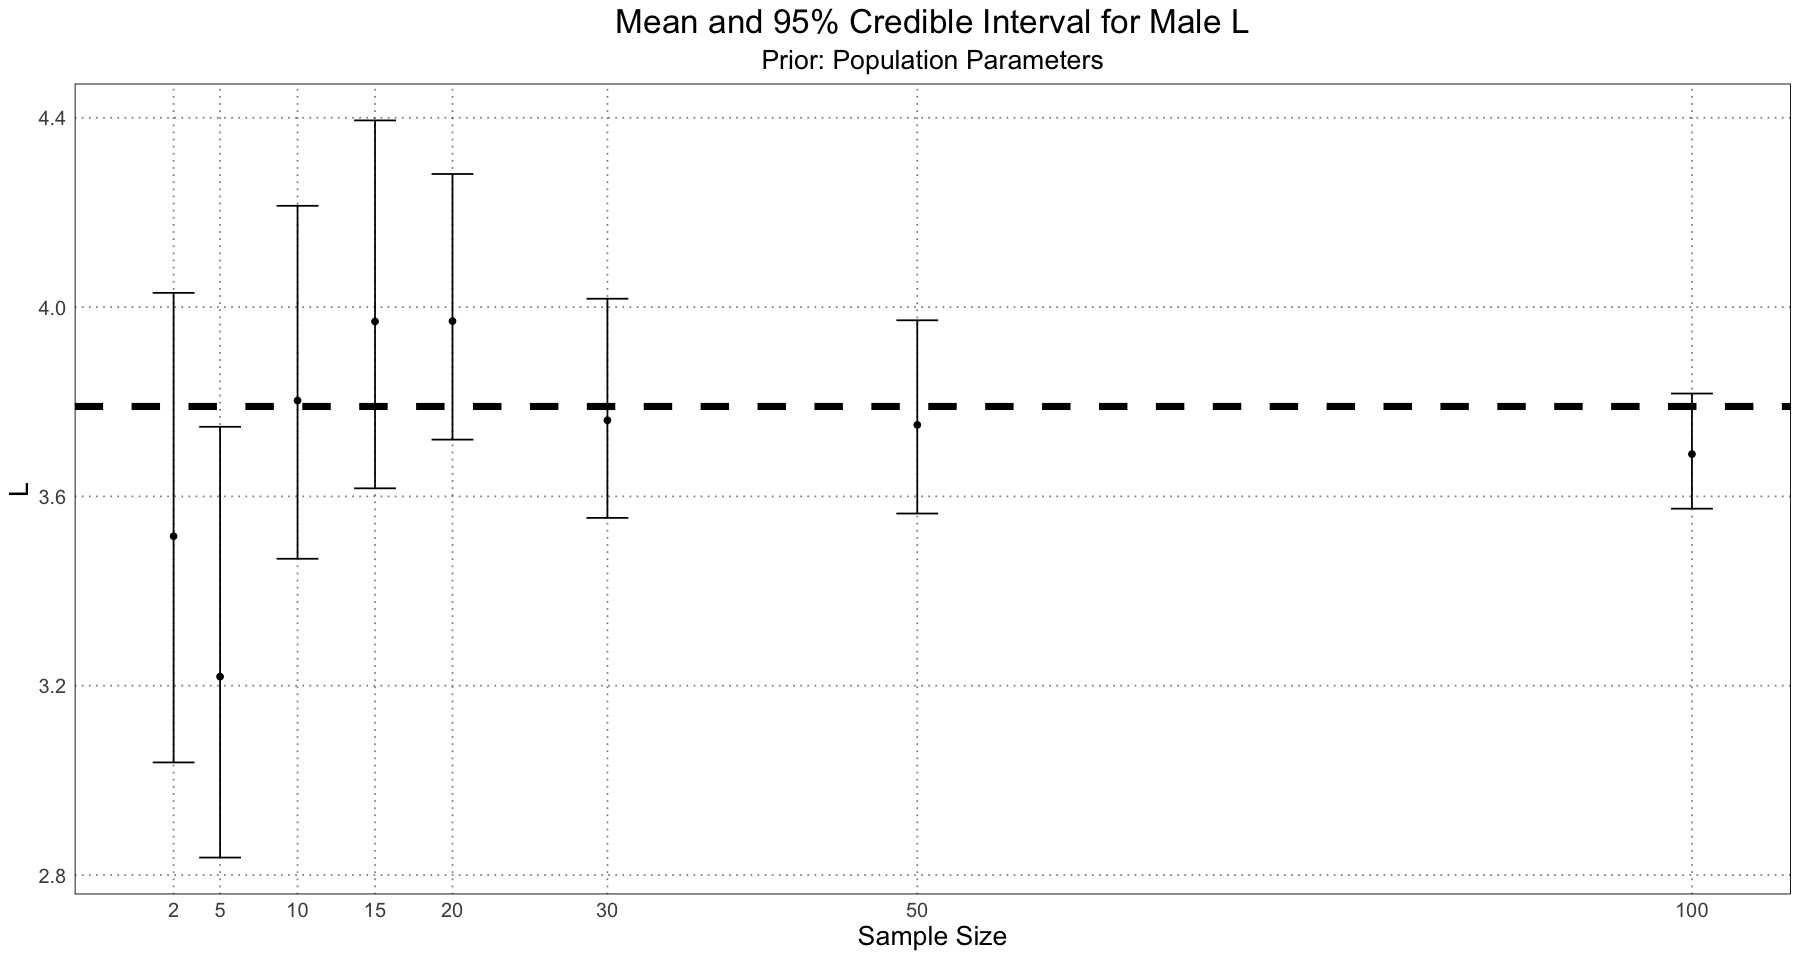

In [19]:

ggplot(L_param_data, aes(sample_size)) +
    geom_point(aes(y = mu)) +
    geom_errorbar(aes(ymin = lower, ymax = upper)) +
    geom_hline(yintercept = actual_male_params[['L']], linewidth = 2, linetype = 'dashed') +
    labs(x = "Sample Size", y = "L", title = "Mean and 95% Credible Interval for Male L", subtitle = "Prior: Population Parameters") +
    scale_x_continuous(breaks = sample_sizes, labels = sample_sizes) +
    custom_theme()

As expected, we see that generally we are getting closer to our true value and with tighter bounds on the credible interval as the number of samples increases.

Of course, that is assuming that our sex assignment is perfectly accurate. Let's take a look at what happens when we use our naive classifier for predicting the sex. For this case we'll actually need to modify the model to take into account both the male and female populations (we'll calculate them both all in one go) as well as to vary the priors to be equal to the population priors. We'll just change the prior means, not the standard deviations.

In [20]:
generate_alligator_ages <- function(num) {
    runif(num, 1, ALLIGATOR_MAX_LIFESPAN)
}

generate_actual_female_sample <- function(ages) {
    means <- generalized_von_bertalanffy(ages, L = actual_female_params[['L']], A = actual_female_params[['A']], K = actual_female_params[['K']])
    rnorm(length(ages), mean = means, sd = 0.5)
}

generate_actual_male_sample <- function(ages) {
    means <- generalized_von_bertalanffy(ages, L = actual_male_params[['L']], A = actual_male_params[['A']], K = actual_male_params[['K']])
    rnorm(length(ages), mean = means, sd = 0.5)
}

generate_curve_fit <- function(data) {
    start <- generate_initial_vb_params(data)
    fit <- nlsLM(length ~ generalized_von_bertalanffy(age, L, A, K), data = data, start = start)
    fit
}

In [21]:
    population_prior_model <- "
    data {
        int<lower = 0> N; // number of samples
        vector[N] length; // a vector of the lengths
        vector[N] age; // vector of the ages; index correlates with length (so length[i] happened at age[i])
        
        // prior means for the parameters
        real prior_L_mean;
        real prior_A_mean;
        real prior_K_mean;
    }

    parameters {
        real<lower = 0> L;
        real<lower = 0> A;
        real<lower = 0> K;
        real<lower = 0> sigma_length;
    }

    model {
        vector[N] mean_length;

        L ~ normal(prior_L_mean, 0.5);
        K ~ normal(prior_K_mean, 0.025);
        A ~ normal(prior_A_mean, 0.25);
        sigma_length ~ normal(0.25, 0.0625);
        mean_length = L * (1 - A * exp(-K * age));
        length ~ normal(mean_length, sigma_length);
    }
    "

In [26]:
L_param_data <- data.frame(
    sample_size = numeric(),
    lower = numeric(),
    mu = numeric(),
    upper = numeric()
)
sample_sizes <- c(5, 10, 15, 20, 30, 50, 100)
for (sample_size in sample_sizes) {
    male_ages <- generate_alligator_ages(sample_size)
    male_lengths <- generate_actual_male_sample(male_ages)
    female_ages <- generate_alligator_ages(sample_size)
    female_lengths <- generate_actual_female_sample(female_ages)
    combined_data <- data.frame(age = c(male_ages, female_ages), length = c(male_lengths, female_lengths), sex = rep(c("M", "F"), each = sample_size))

    # fit to the population
    fit.population <- generate_curve_fit(combined_data)
    coefficients.population <- coef(fit.population)

    # predict the sex using the population curve
    combined_data$residual <- resid(fit.population)
    combined_data$predicted_sex <- ifelse(combined_data$residual < 0, "F", "M")

    male_data <- subset(combined_data, combined_data$predicted_sex == "M")

    male_data <- list(
        N = nrow(male_data),
        age = male_data$age,
        length = male_data$length,
        prior_L_mean = coefficients.population[['L']],
        prior_A_mean = coefficients.population[['A']],
        prior_K_mean = coefficients.population[['K']]
    )
    model.male <- stan(model_code = population_prior_model, data = male_data, iter = 16000)
    male_sample <- extract(model.male)
    L_sample <- male_sample[['L']]
    instance_data <- data.frame(
        sample_size = sample_size,
        lower = quantile(L_sample, 0.025),
        mu = mean(L_sample),
        upper = quantile(L_sample, 0.975)
    )
    L_param_data <- rbind(L_param_data, instance_data)
}
L_param_data

         age   length sex
1  49.184727 4.134650   M
2  27.416650 2.958037   M
3  11.810059 2.402628   M
4   3.951619 1.108370   M
5  36.633694 4.373803   M
6   6.003769 2.441534   F
7   7.980663 1.566504   F
8  46.482392 2.233272   F
9  41.139133 1.936338   F
10 46.753593 3.684156   F
         age    length sex
1   9.578176 1.5105609   M
2  24.422866 3.2921089   M
3   2.327609 0.8228127   M
4  47.471529 3.8625322   M
5  41.538179 4.3033180   M
6  29.254816 3.6015795   M
7   1.943634 0.5921333   M
8  32.315549 3.3232904   M
9  37.389512 3.9783040   M
10 22.087457 3.0331715   M
11 36.146548 2.3637271   F
12 20.266334 2.7074225   F
13 48.510232 3.0531875   F
14 12.525179 2.0765274   F
15 11.717260 2.0722205   F
16 11.722162 2.0361501   F
17 34.023561 2.7222991   F
18 23.061624 1.9120960   F
19 29.000546 2.7846592   F
20 39.342253 2.0227004   F
         age     length sex
1  41.336682  3.5474648   M
2  20.138668  3.3570757   M
3  46.951656  3.4629919   M
4  48.666411  3.7034212   M
5  47.3

sample_size lower    mu       upper   
2.5%    5         3.701651 4.023989 4.334704
2.5%1  10         3.871211 4.323723 4.844382
2.5%2  15         3.547286 3.739733 3.947152
2.5%3  20         3.257604 3.472546 3.694665
2.5%4  30         3.664334 4.078921 4.616538
2.5%5  50         3.680437 3.891380 4.148474
2.5%6 100         3.618131 3.789845 4.008738

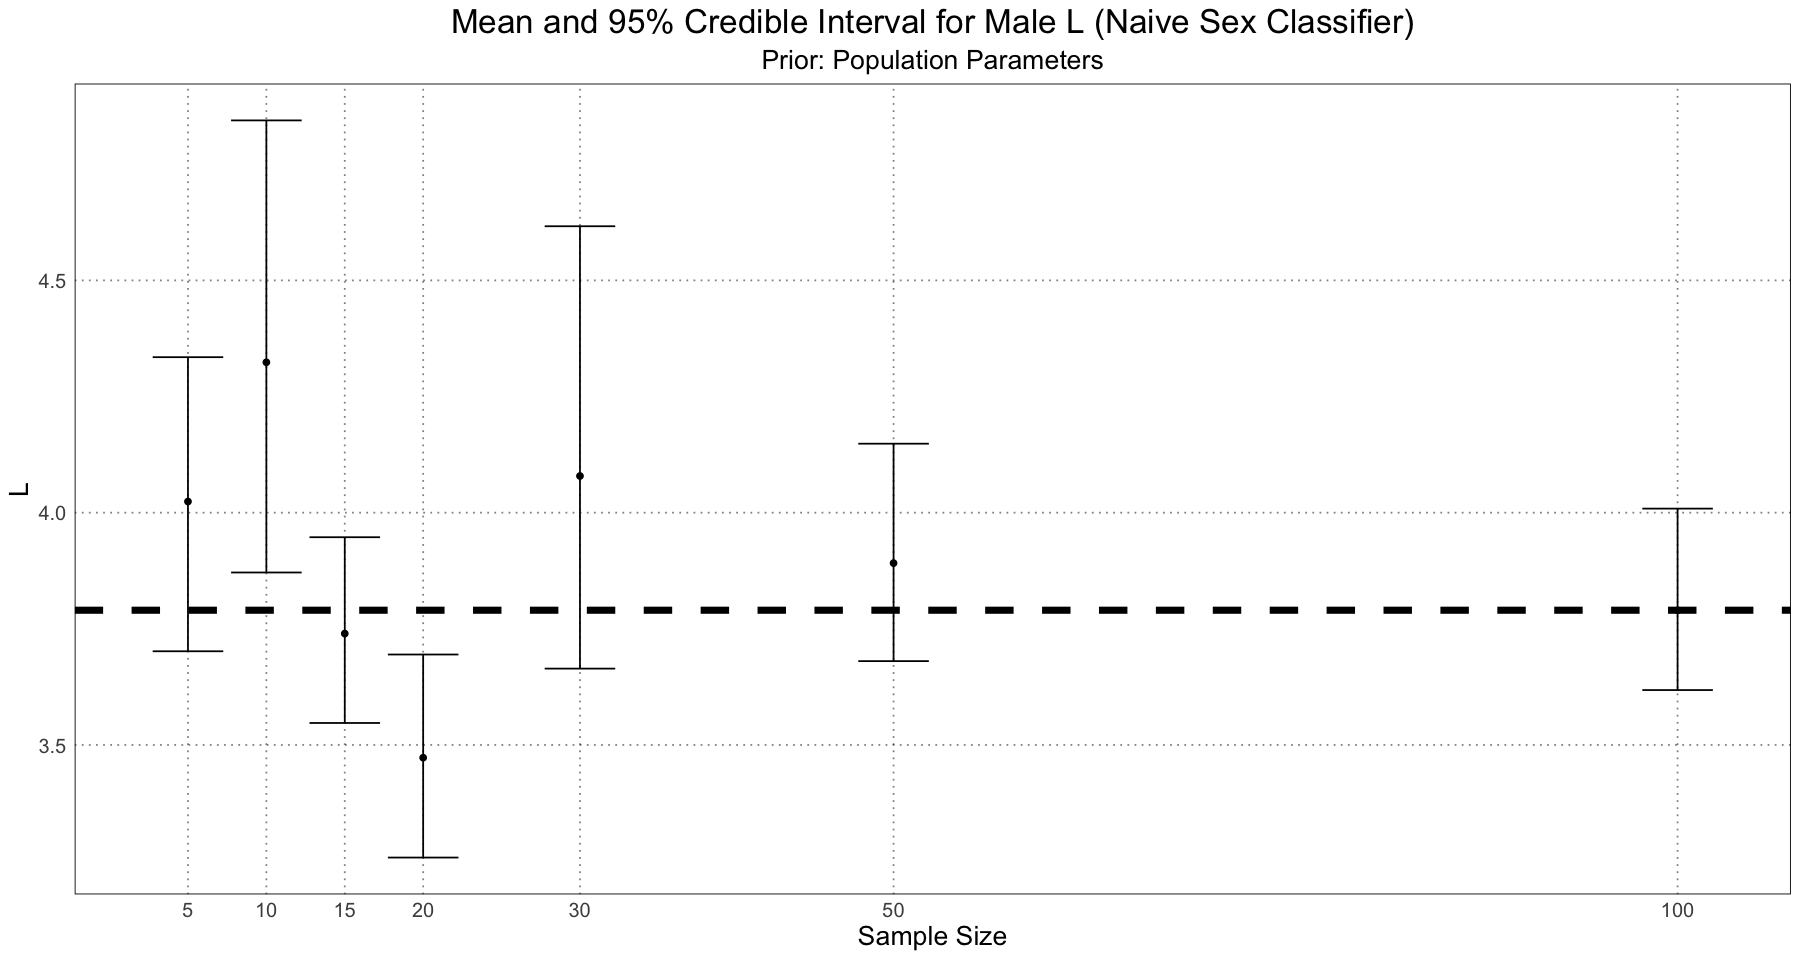

In [27]:
ggplot(L_param_data, aes(sample_size)) +
    geom_point(aes(y = mu)) +
    geom_errorbar(aes(ymin = lower, ymax = upper)) +
    geom_hline(yintercept = actual_male_params[['L']], linewidth = 2, linetype = 'dashed') +
    labs(x = "Sample Size", y = "L", title = "Mean and 95% Credible Interval for Male L (Naive Sex Classifier)", subtitle = "Prior: Population Parameters") +
    scale_x_continuous(breaks = sample_sizes, labels = sample_sizes) +
    custom_theme()

From this, it seems like the method still works using the naive classifier for sex, but there is definitely more error here than when we were using the actual sex. This is not unexpected; after all, we've just introduced a new source of error.

The next thing we should examine is how good we are at recovering the actual level of dimorphism. To do this, let's generate different samples from simulated male and female populations with true levels of dimorphism ranging from 0 to twice the actual amount seen in nature. Again, we're going to keep the standard deviation constant for simplicity.

In [32]:
generate_male_params_from_effect_size <- function(E) {
    list(
        L = actual_female_params[['L']] + E * (actual_male_params[['L']] - actual_female_params[['L']]),
        A = actual_female_params[['A']] + E * (actual_male_params[['A']] - actual_female_params[['A']]),
        K = actual_female_params[['K']] + E * (actual_male_params[['K']] - actual_female_params[['K']])
    )
}

generate_male_sample <- function(ages, E, sigma = 0.5) {
    params <- generate_male_params_from_effect_size(E)
    means <- generalized_von_bertalanffy(ages, L = params[['L']], A = params[['A']], K = params[['K']])
    rnorm(length(ages), mean = means, sd = sigma)
}


generate_difference <- function(sample1, sample2, sample_size) {
    bootstrap_sample1 <- sample(sample1, size = sample_size, replace = TRUE)
    bootstrap_sample2 <- sample(sample2, size = sample_size, replace = TRUE)
    bootstrap_sample1 - bootstrap_sample2
}

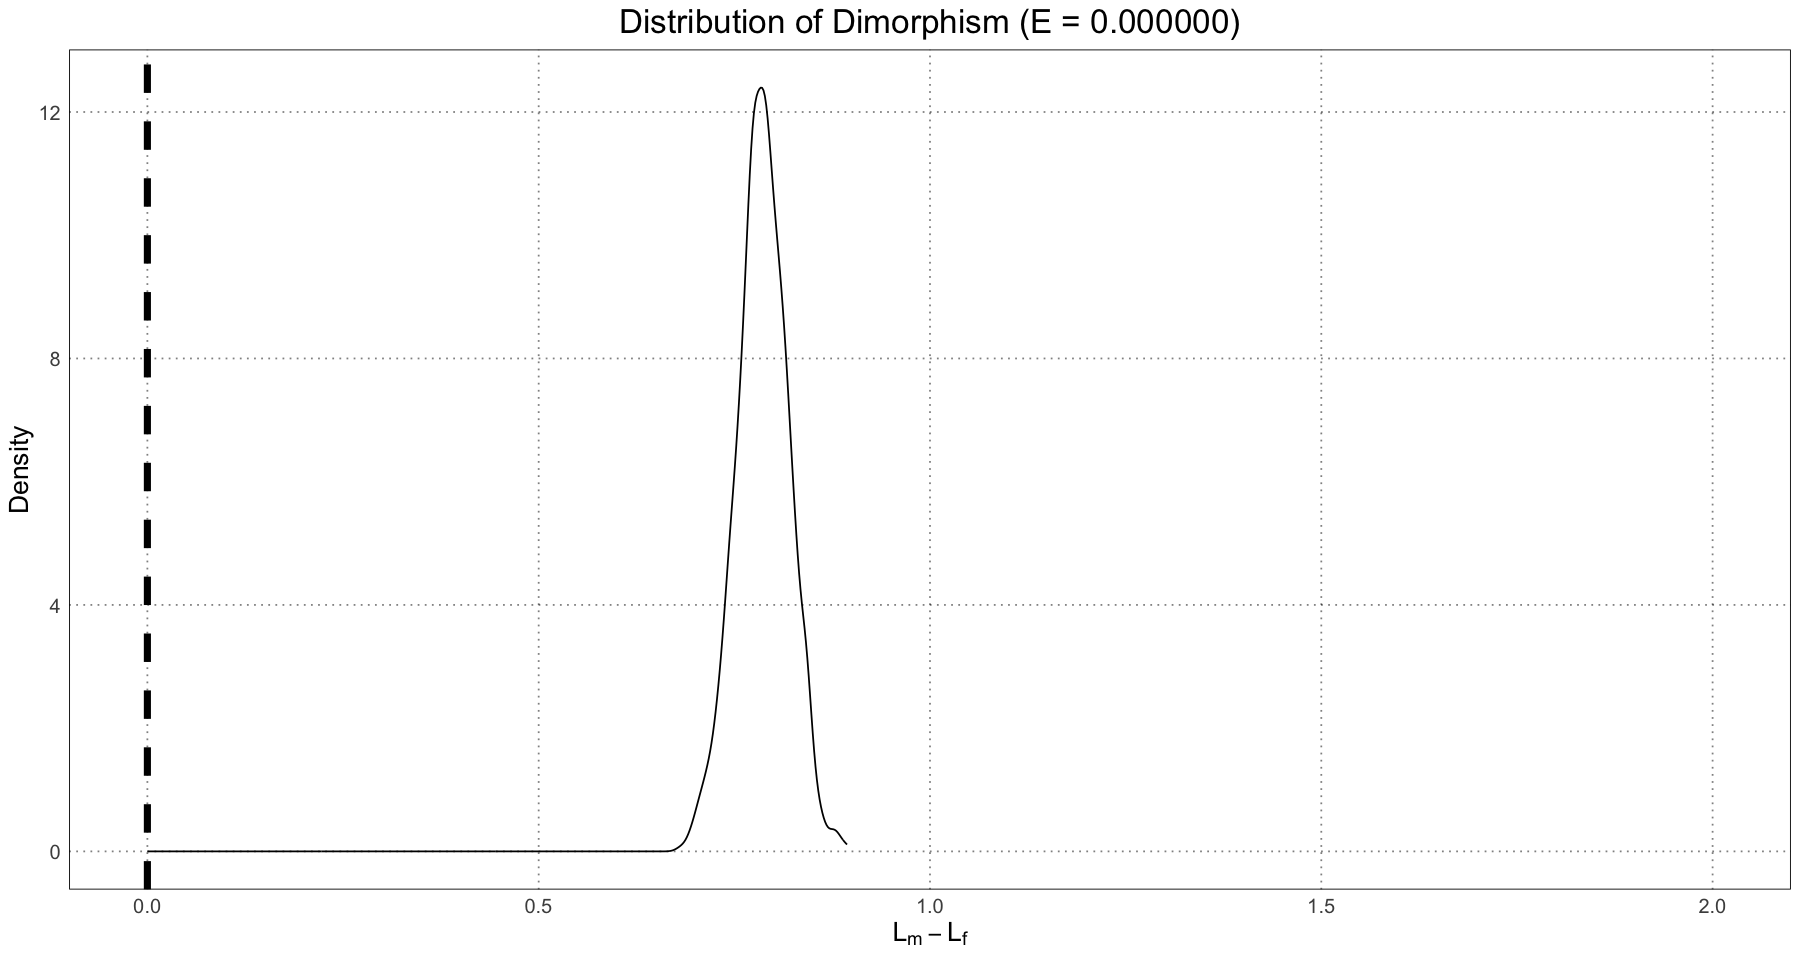

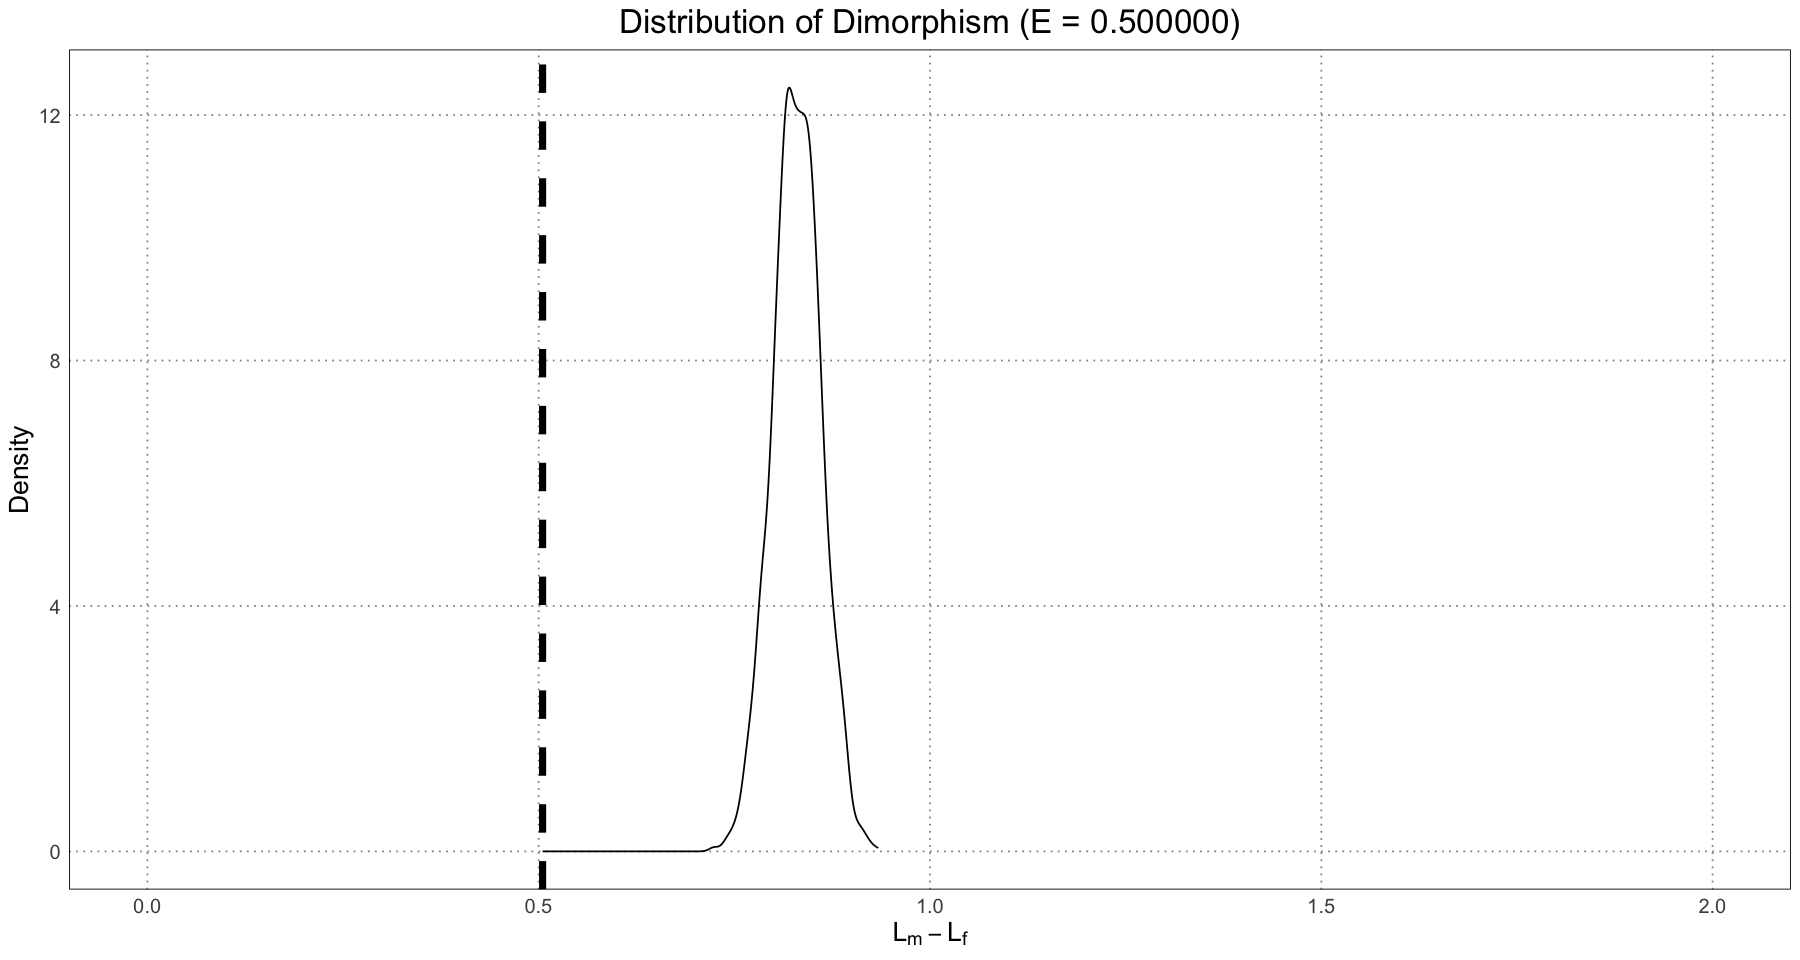

Warning message:
“Starting value for Linf is very different from the observed maximum
length, which suggests a model fitting problem. See a Walford or
Chapman plot to examine the problem. Consider either using the mean
length for several of the largest fish (i.e., use 'oldAge' in 
'methLinf=') or manually setting Linf in the starting value list
to the maximum observed length.
”


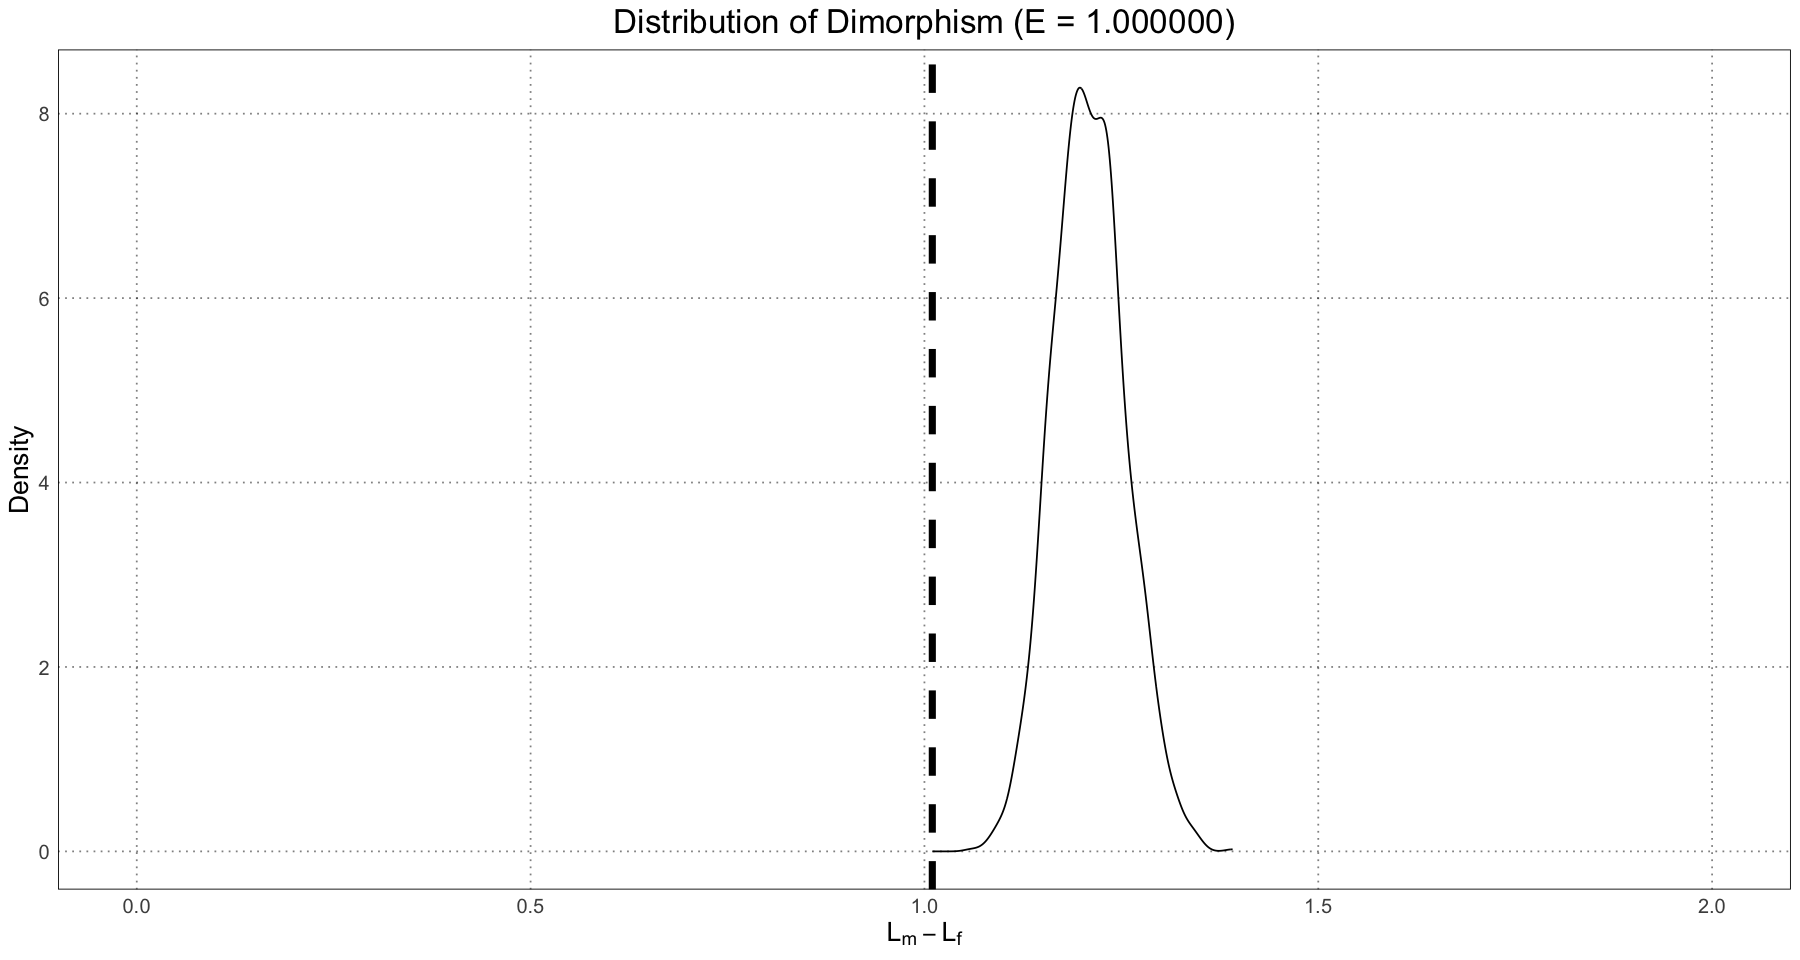

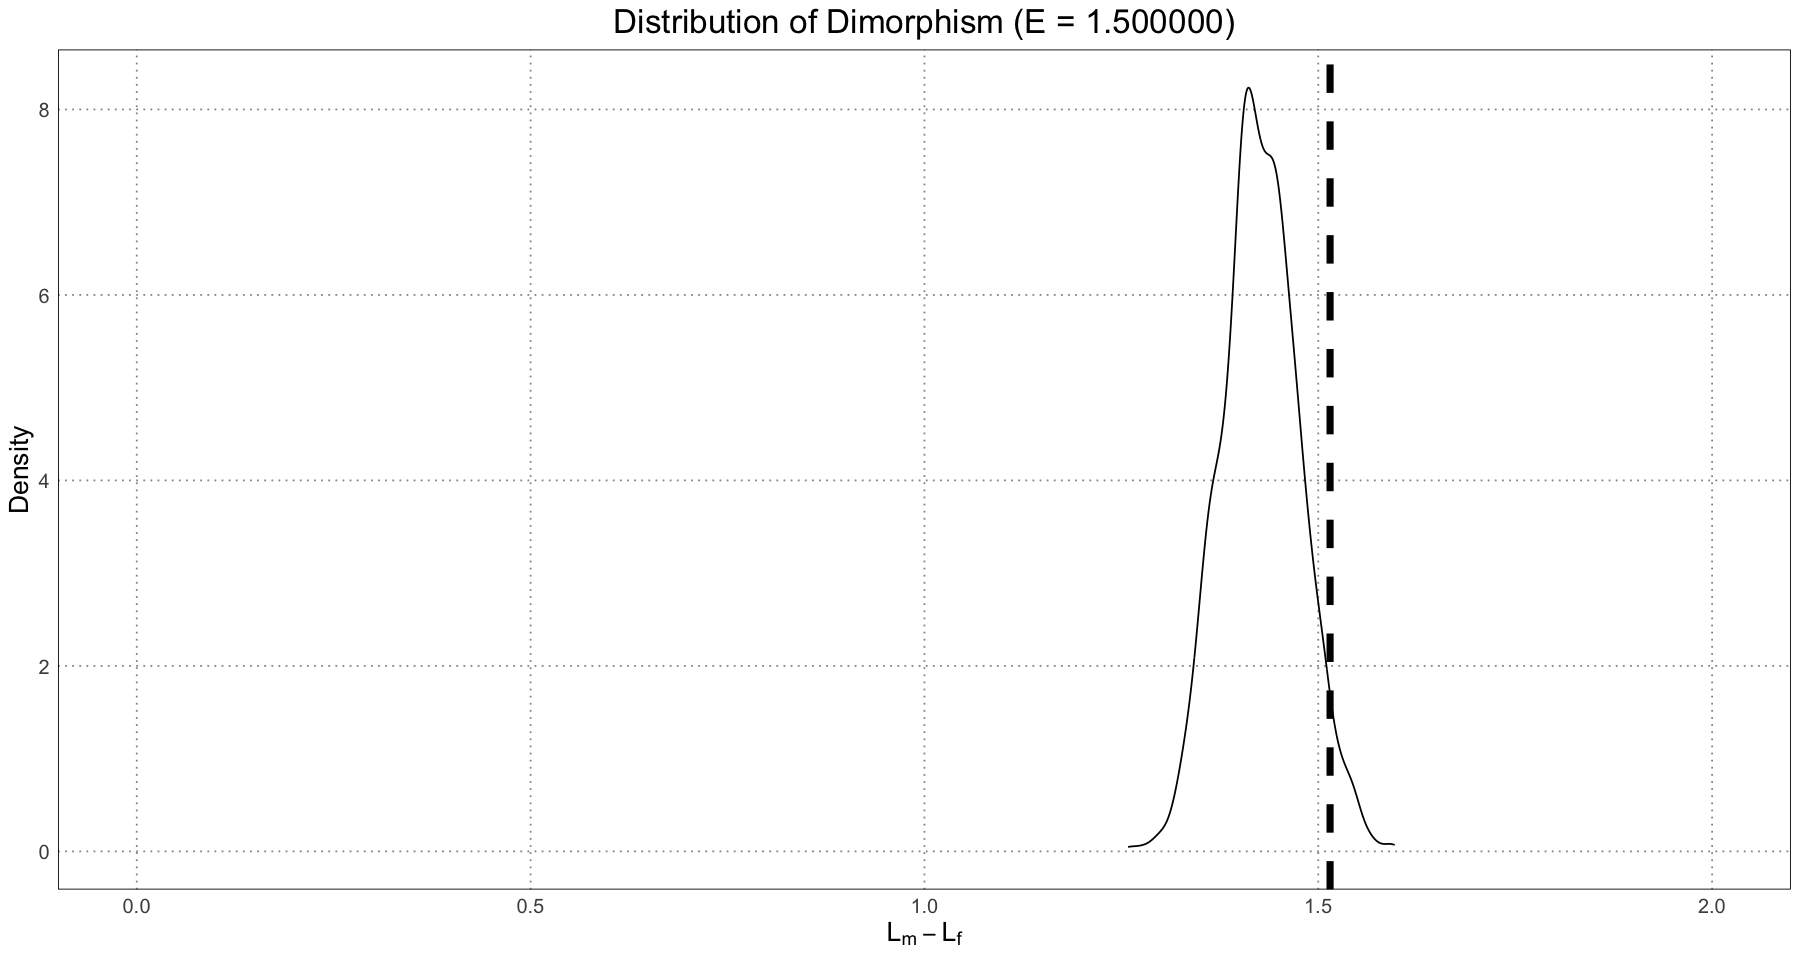

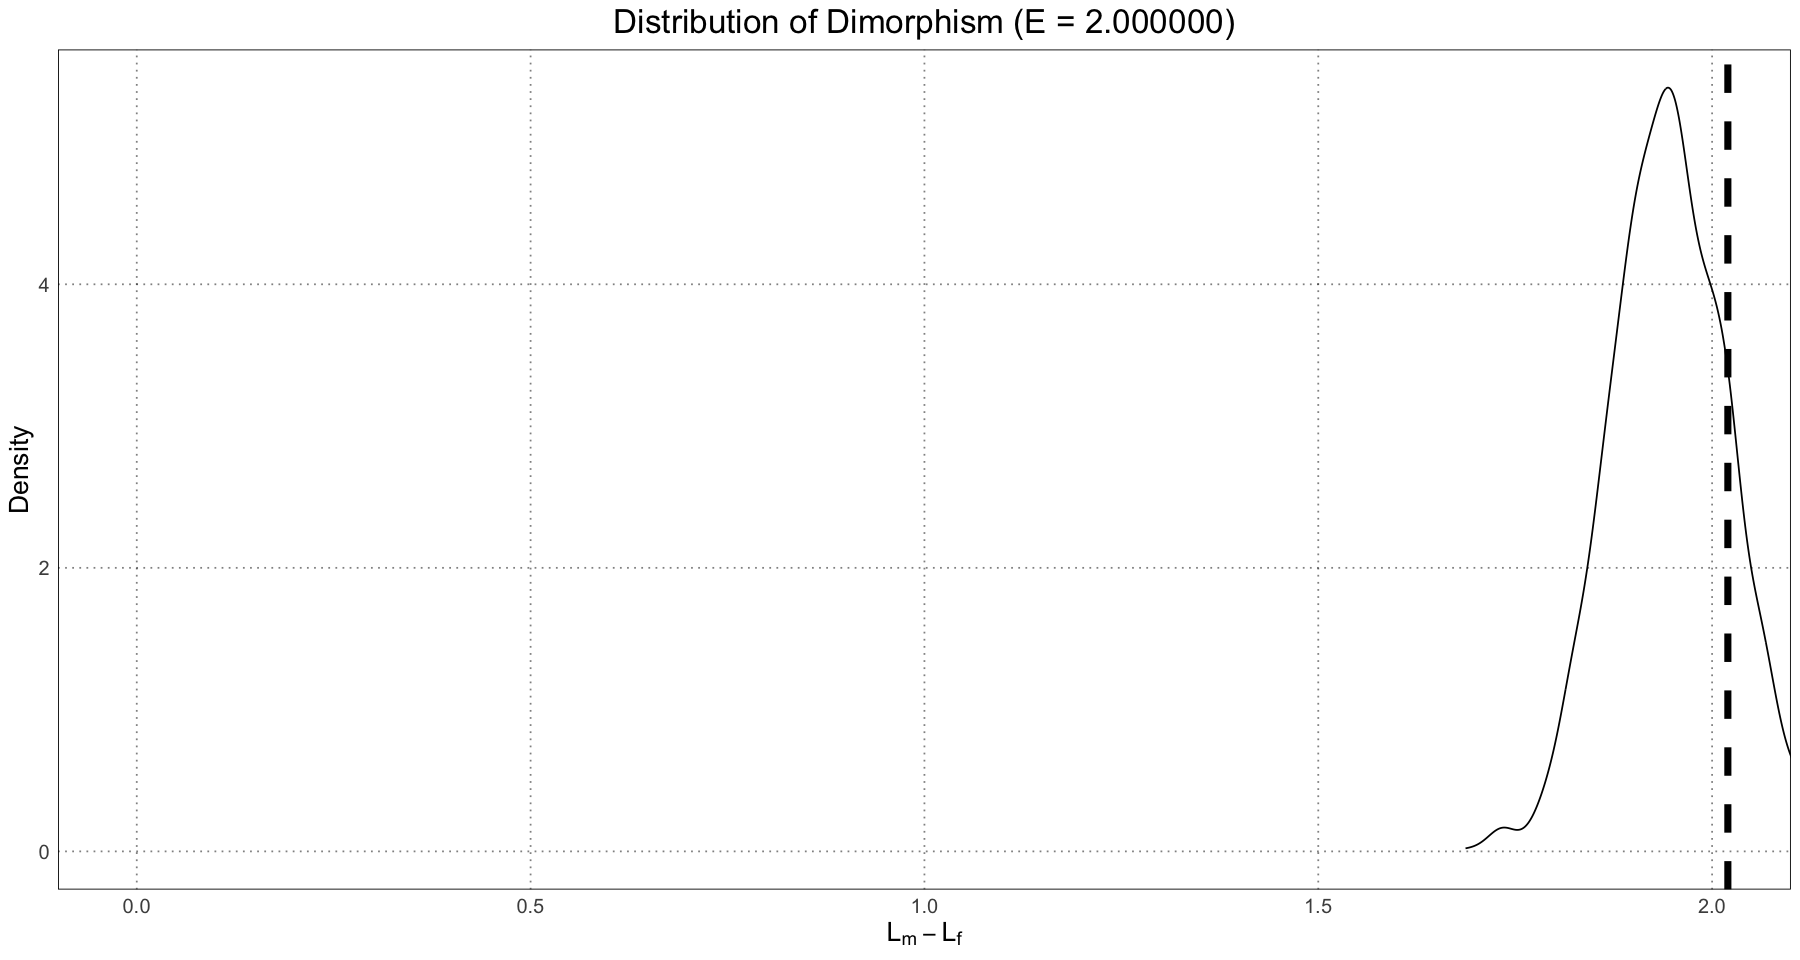

In [37]:
sample_size <- 1e3
# for (E in seq(0, 2, by = 0.1))
for (E in seq(0, 2, by = 0.5)) {
    male_ages <- generate_alligator_ages(sample_size)
    male_lengths <- generate_male_sample(male_ages, E)
    male_params <- generate_male_params_from_effect_size(E)
    female_ages <- generate_alligator_ages(sample_size)
    female_lengths <- generate_actual_female_sample(female_ages)

    combined_data <- data.frame(
        age = c(male_ages, female_ages),
        length = c(male_lengths, female_lengths)
    )
    population.fit <- generate_curve_fit(combined_data)
    combined_data$residual <- resid(population.fit)
    combined_data$predicted_sex <- ifelse(combined_data$residual < 0, "F", "M")

    male_data <- subset(combined_data, combined_data$predicted_sex == "M")
    female_data <- subset(combined_data, combined_data$predicted_sex == "F")

    male_model_input <- list(
        N = nrow(male_data),
        age = male_data$age,
        length = male_data$length,
        prior_L_mean = coefficients.population[['L']],
        prior_A_mean = coefficients.population[['A']],
        prior_K_mean = coefficients.population[['K']]
    )
    model.male <- stan(model_code = population_prior_model, data = male_model_input, iter = 16000)
    male_sample <- extract(model.male)
    male_L_sample <- male_sample[['L']]

    female_model_input <- list(
        N = nrow(female_data),
        age = female_data$age,
        length = female_data$length,
        prior_L_mean = coefficients.population[['L']],
        prior_A_mean = coefficients.population[['A']],
        prior_K_mean = coefficients.population[['K']]
    )
    model.female <- stan(model_code = population_prior_model, data = female_model_input, iter = 16000)
    female_sample <- extract(model.female)
    female_L_sample <- female_sample[['L']]

    difference <- generate_difference(male_L_sample, female_L_sample, sample_size = 2000)
    actual_difference <- male_params[['L']] - actual_female_params[['L']]

    p <- ggplot(data.frame(difference = difference), aes(difference)) +
        geom_density(aes(y = after_stat(density))) +
        geom_vline(xintercept = actual_difference, linewidth = 2, linetype = 'dashed') +
        labs(x = expression(L[m] - L[f]), y = "Density", title = sprintf("Distribution of Dimorphism (E = %f)", E)) +
        coord_cartesian(xlim = c(0, 2)) +
        custom_theme()
    print(p)
}

This is not looking great! It may be that the inaccuracy from the classifier is the cause of this; let's test by using the actual male and female values to see what happens.

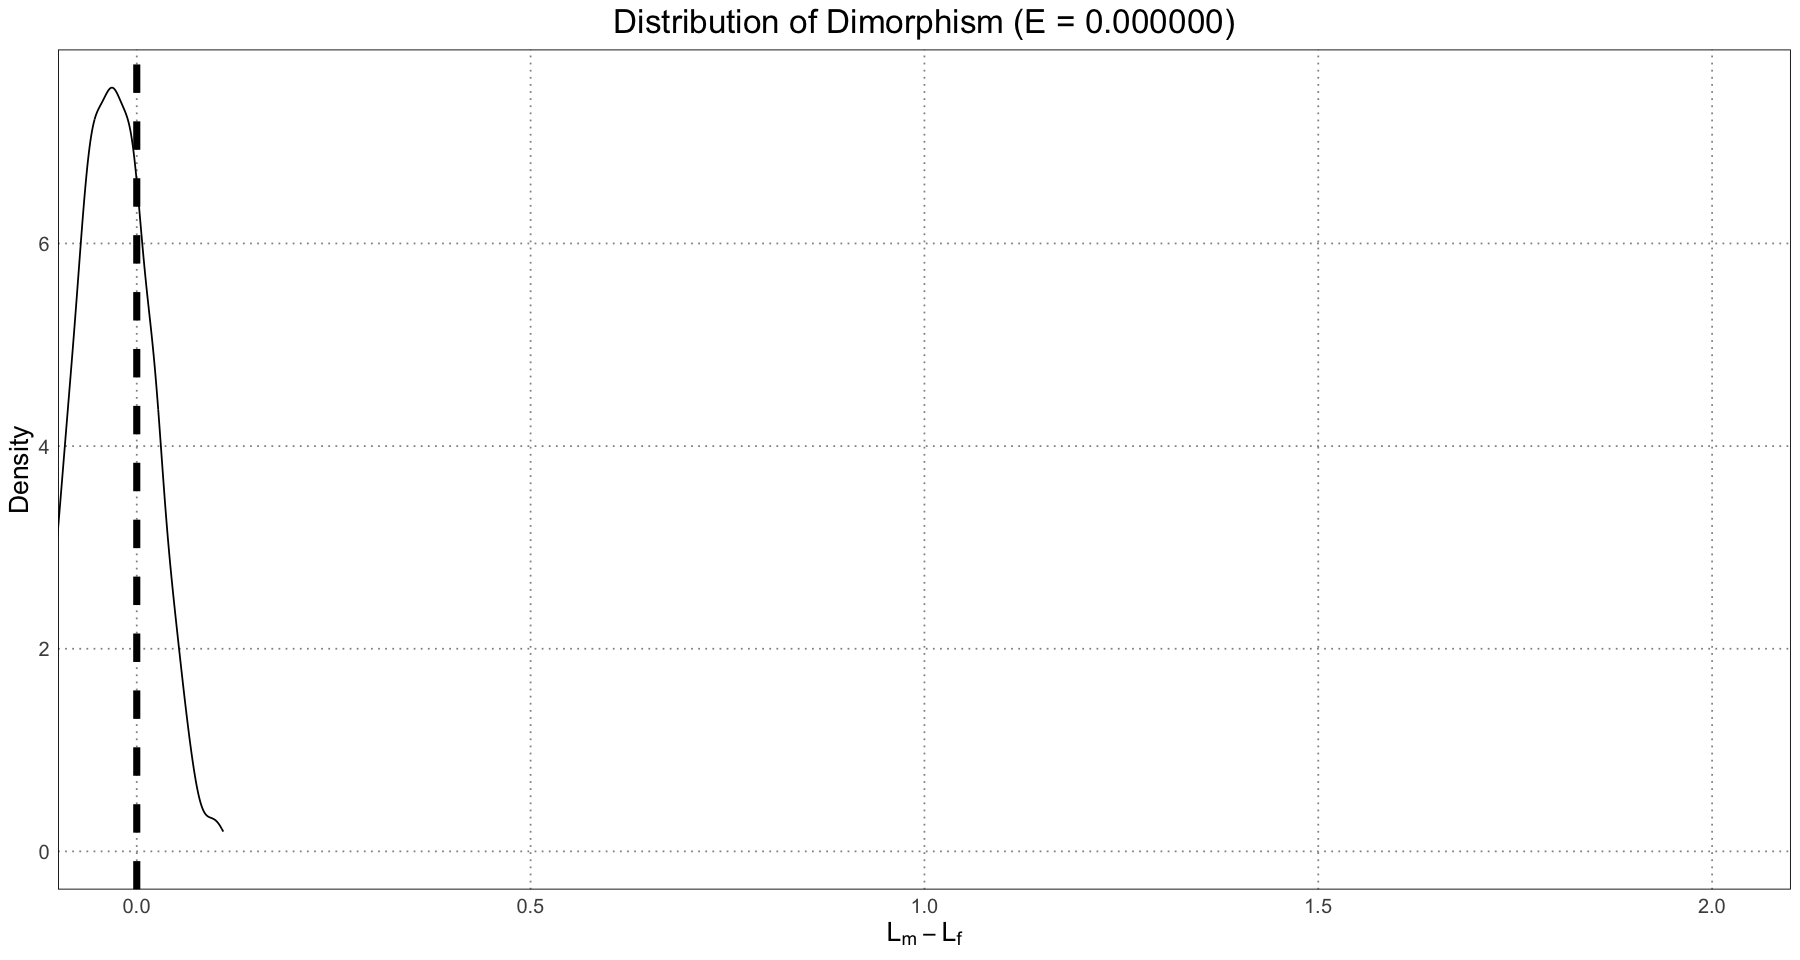

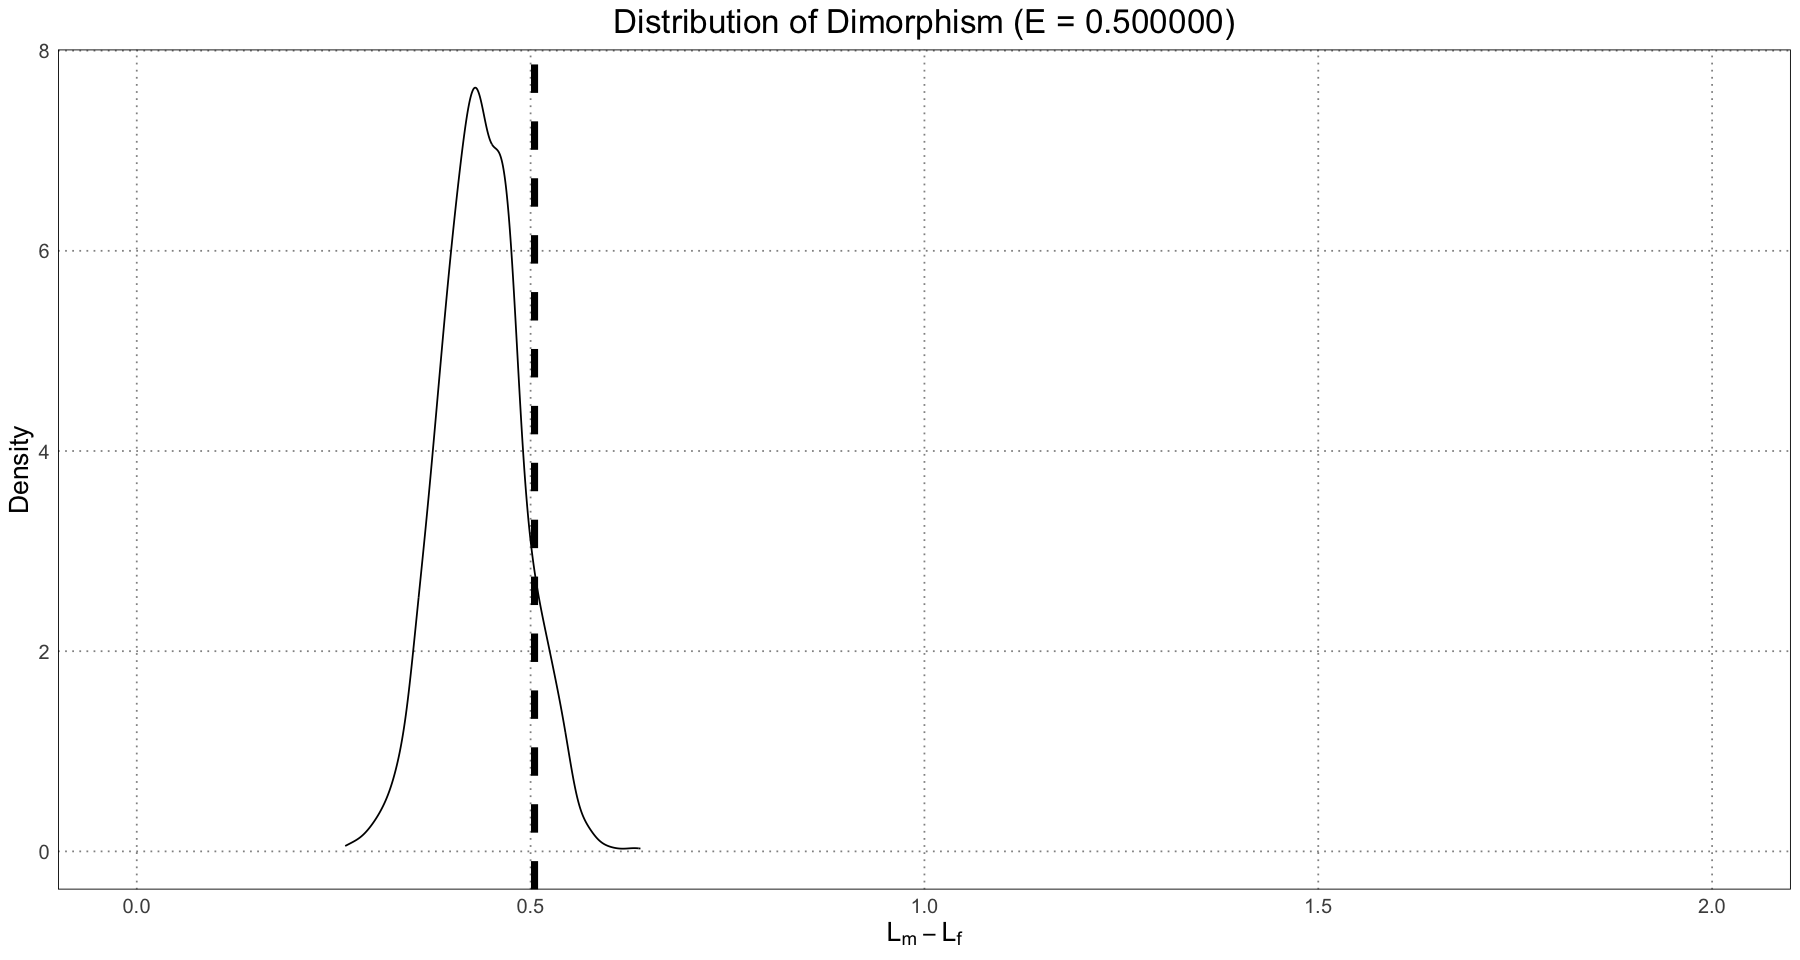

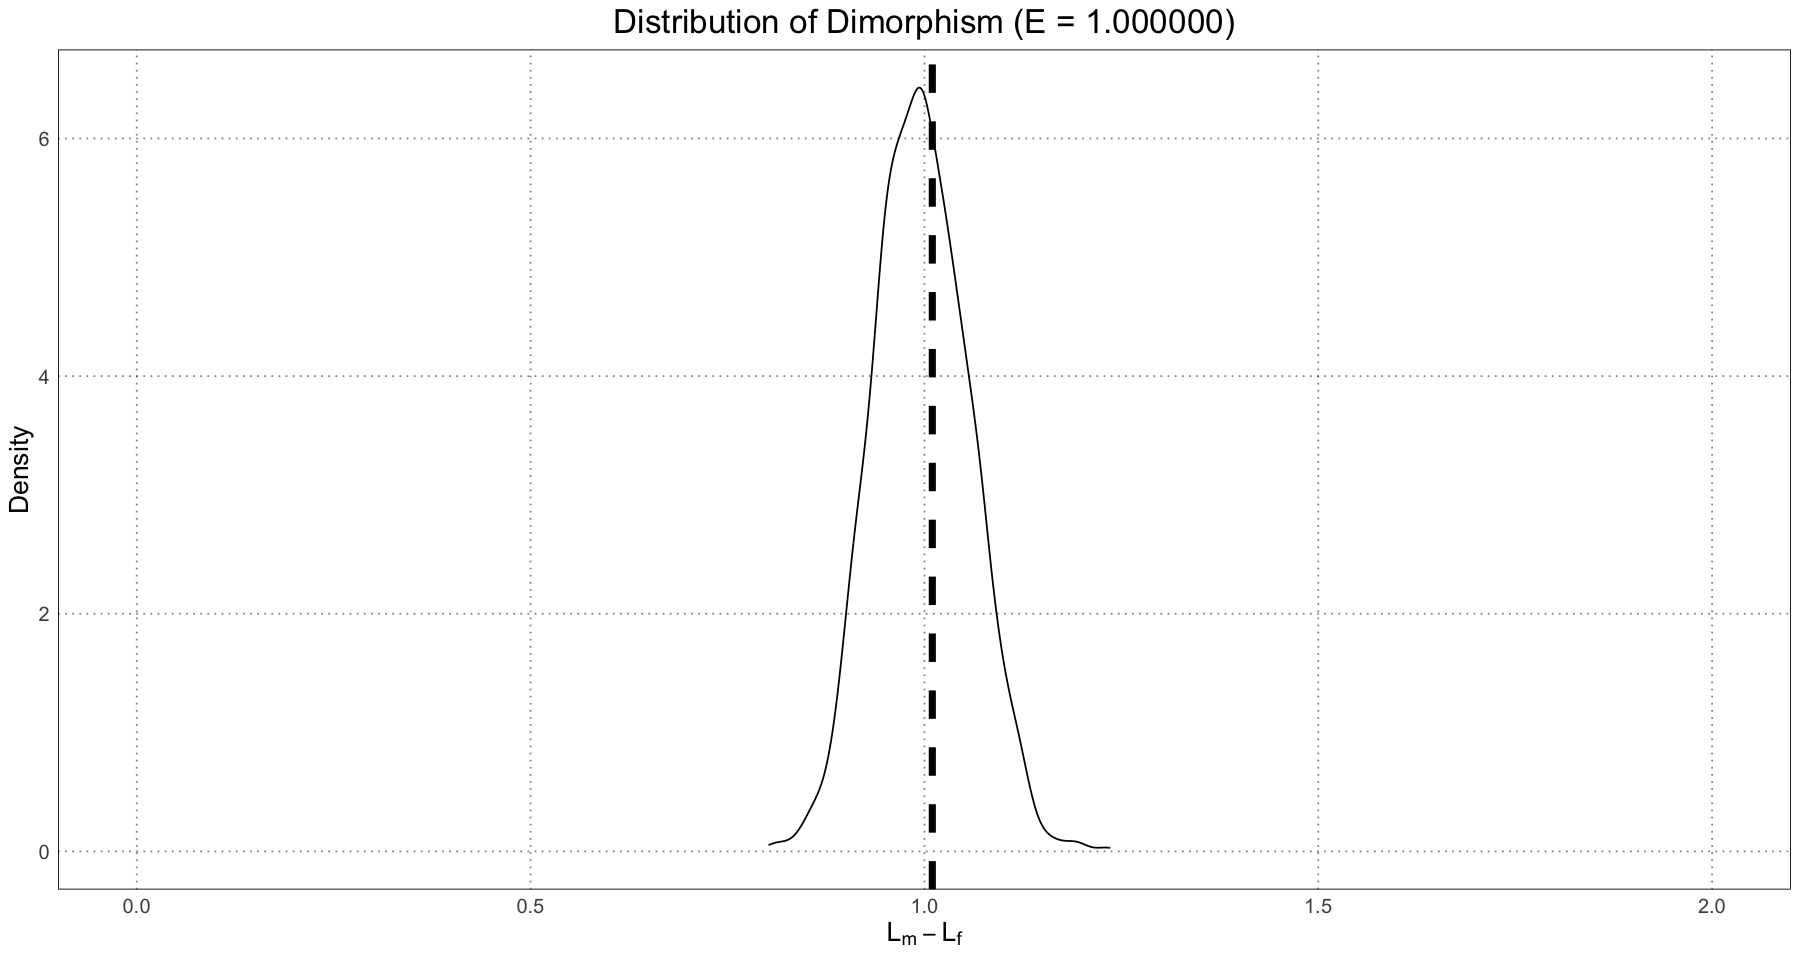

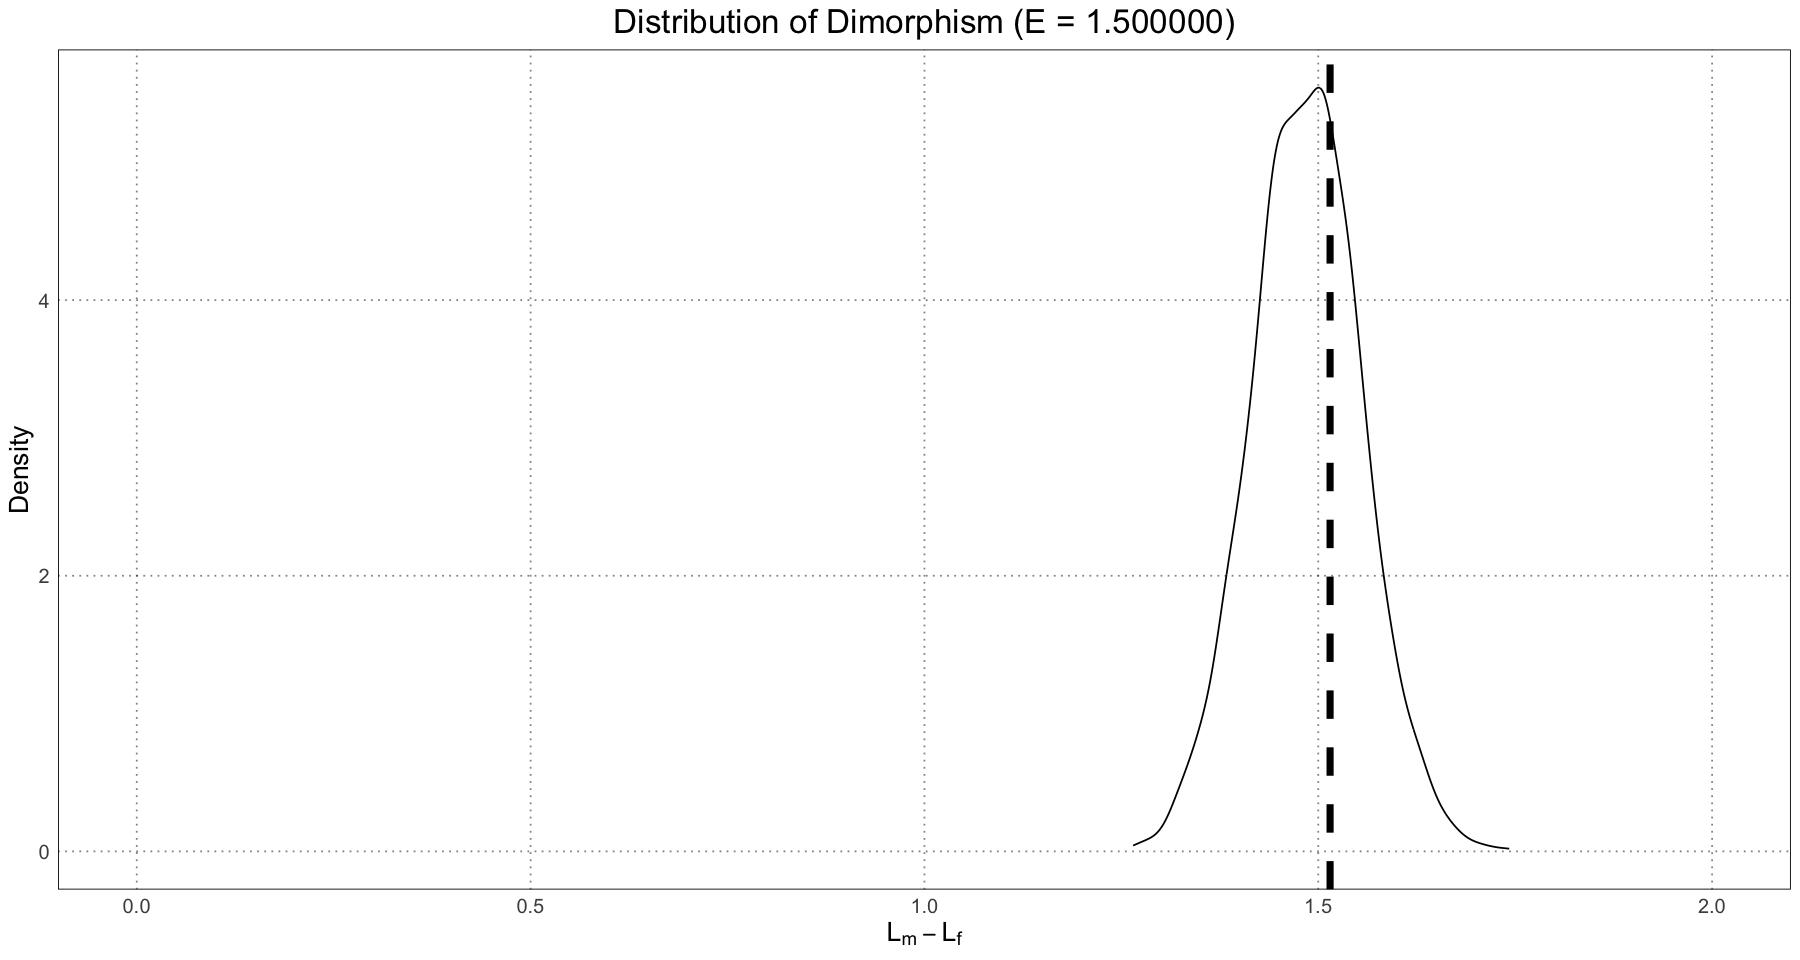

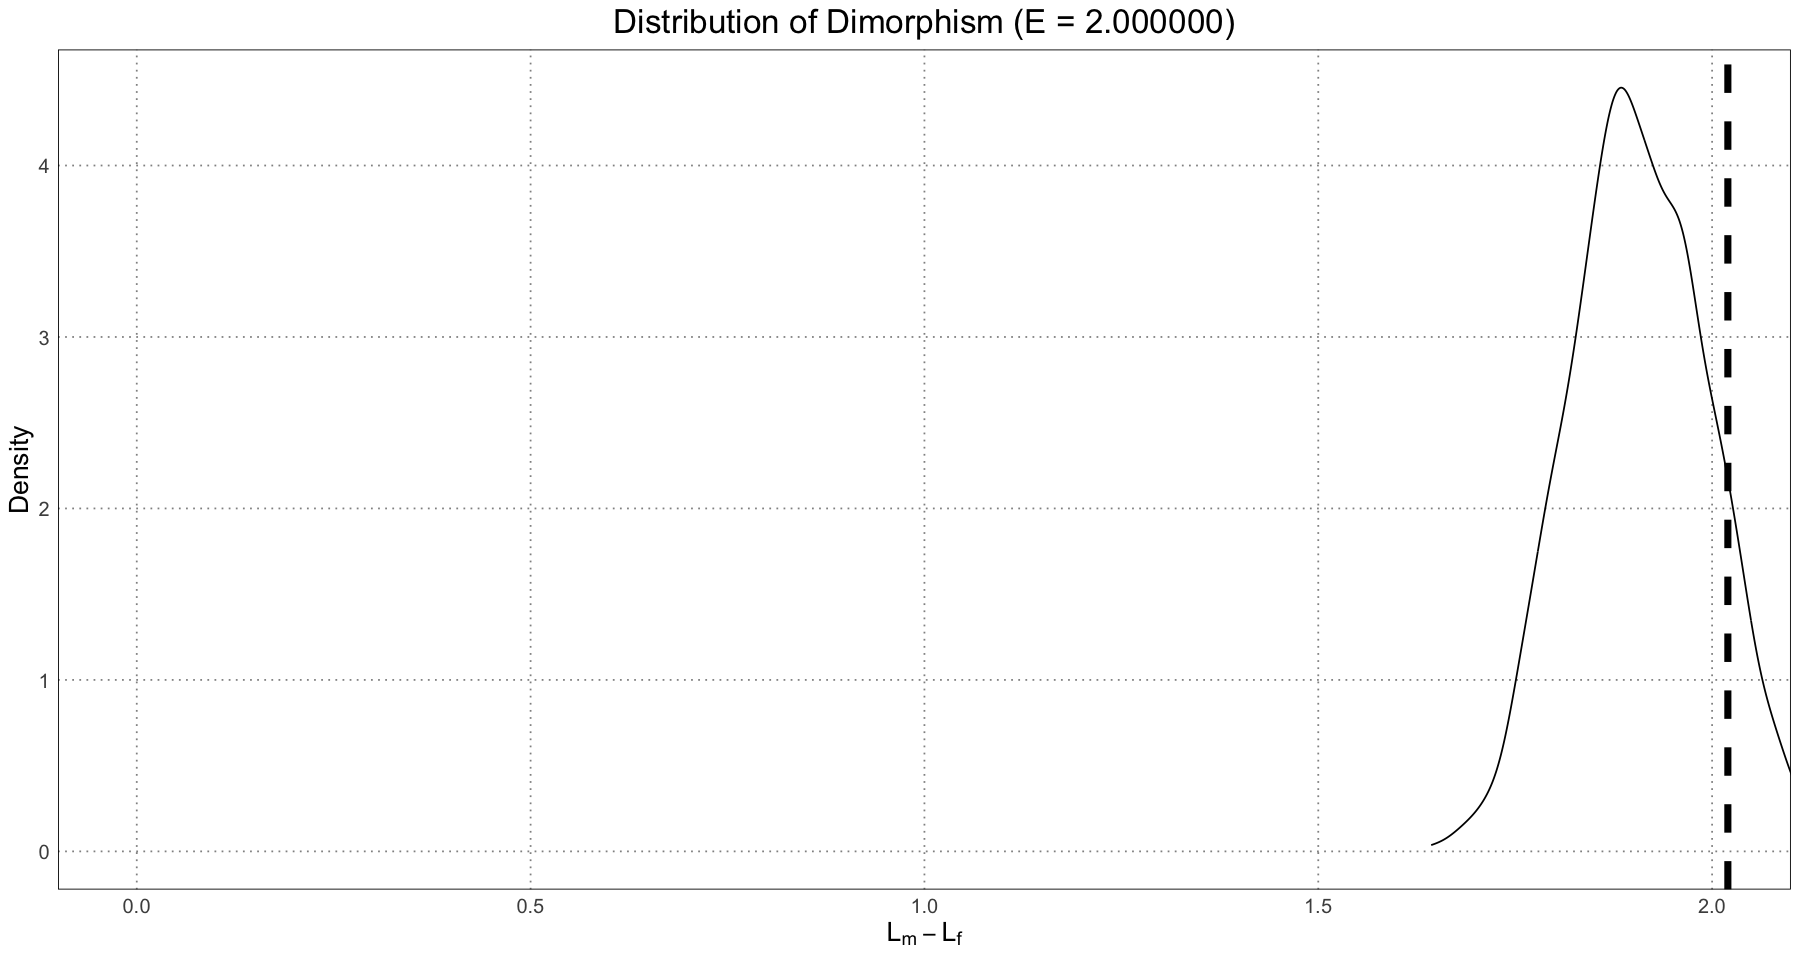

In [38]:
sample_size <- 1e3
# for (E in seq(0, 2, by = 0.1))
for (E in seq(0, 2, by = 0.5)) {
    male_ages <- generate_alligator_ages(sample_size)
    male_lengths <- generate_male_sample(male_ages, E)
    male_params <- generate_male_params_from_effect_size(E)
    female_ages <- generate_alligator_ages(sample_size)
    female_lengths <- generate_actual_female_sample(female_ages)

    combined_data <- data.frame(
        age = c(male_ages, female_ages),
        length = c(male_lengths, female_lengths),
        sex = rep(c("M", "F"), each = sample_size)
    )
    # population.fit <- generate_curve_fit(combined_data)
    # combined_data$residual <- resid(population.fit)
    # combined_data$predicted_sex <- ifelse(combined_data$residual < 0, "F", "M")

    # male_data <- subset(combined_data, combined_data$predicted_sex == "M")
    # female_data <- subset(combined_data, combined_data$predicted_sex == "F")

    male_model_input <- list(
        N = sample_size,
        age = male_ages,
        length = male_lengths,
        prior_L_mean = coefficients.population[['L']],
        prior_A_mean = coefficients.population[['A']],
        prior_K_mean = coefficients.population[['K']]
    )
    model.male <- stan(model_code = population_prior_model, data = male_model_input, iter = 16000)
    male_sample <- extract(model.male)
    male_L_sample <- male_sample[['L']]

    female_model_input <- list(
        N = sample_size,
        age = female_ages,
        length = female_lengths,
        prior_L_mean = coefficients.population[['L']],
        prior_A_mean = coefficients.population[['A']],
        prior_K_mean = coefficients.population[['K']]
    )
    model.female <- stan(model_code = population_prior_model, data = female_model_input, iter = 16000)
    female_sample <- extract(model.female)
    female_L_sample <- female_sample[['L']]

    difference <- generate_difference(male_L_sample, female_L_sample, sample_size = 2000)
    actual_difference <- male_params[['L']] - actual_female_params[['L']]

    p <- ggplot(data.frame(difference = difference), aes(difference)) +
        geom_density(aes(y = after_stat(density))) +
        geom_vline(xintercept = actual_difference, linewidth = 2, linetype = 'dashed') +
        labs(x = expression(L[m] - L[f]), y = "Density", title = sprintf("Distribution of Dimorphism (E = %f)", E)) +
        coord_cartesian(xlim = c(0, 2)) +
        custom_theme()
    print(p)
}

Yup! It's almost surely the inaccuracy of the sex prediction that is causing this to not be great, particularly at low levels of dimorphism where the sex prediction is particularly bad.

## Priors

So far we've been using pretty garbage priors. Let's constrain these to be more reasonable. This really should have been the first thing that we did. Luckily we know the actual values and we have a way of generating the values.

Let's start by just recreating the female parameters.

In [40]:
actual_female_params

$L
[1] 2.78

$A
[1] 0.91

$K
[1] 0.0926

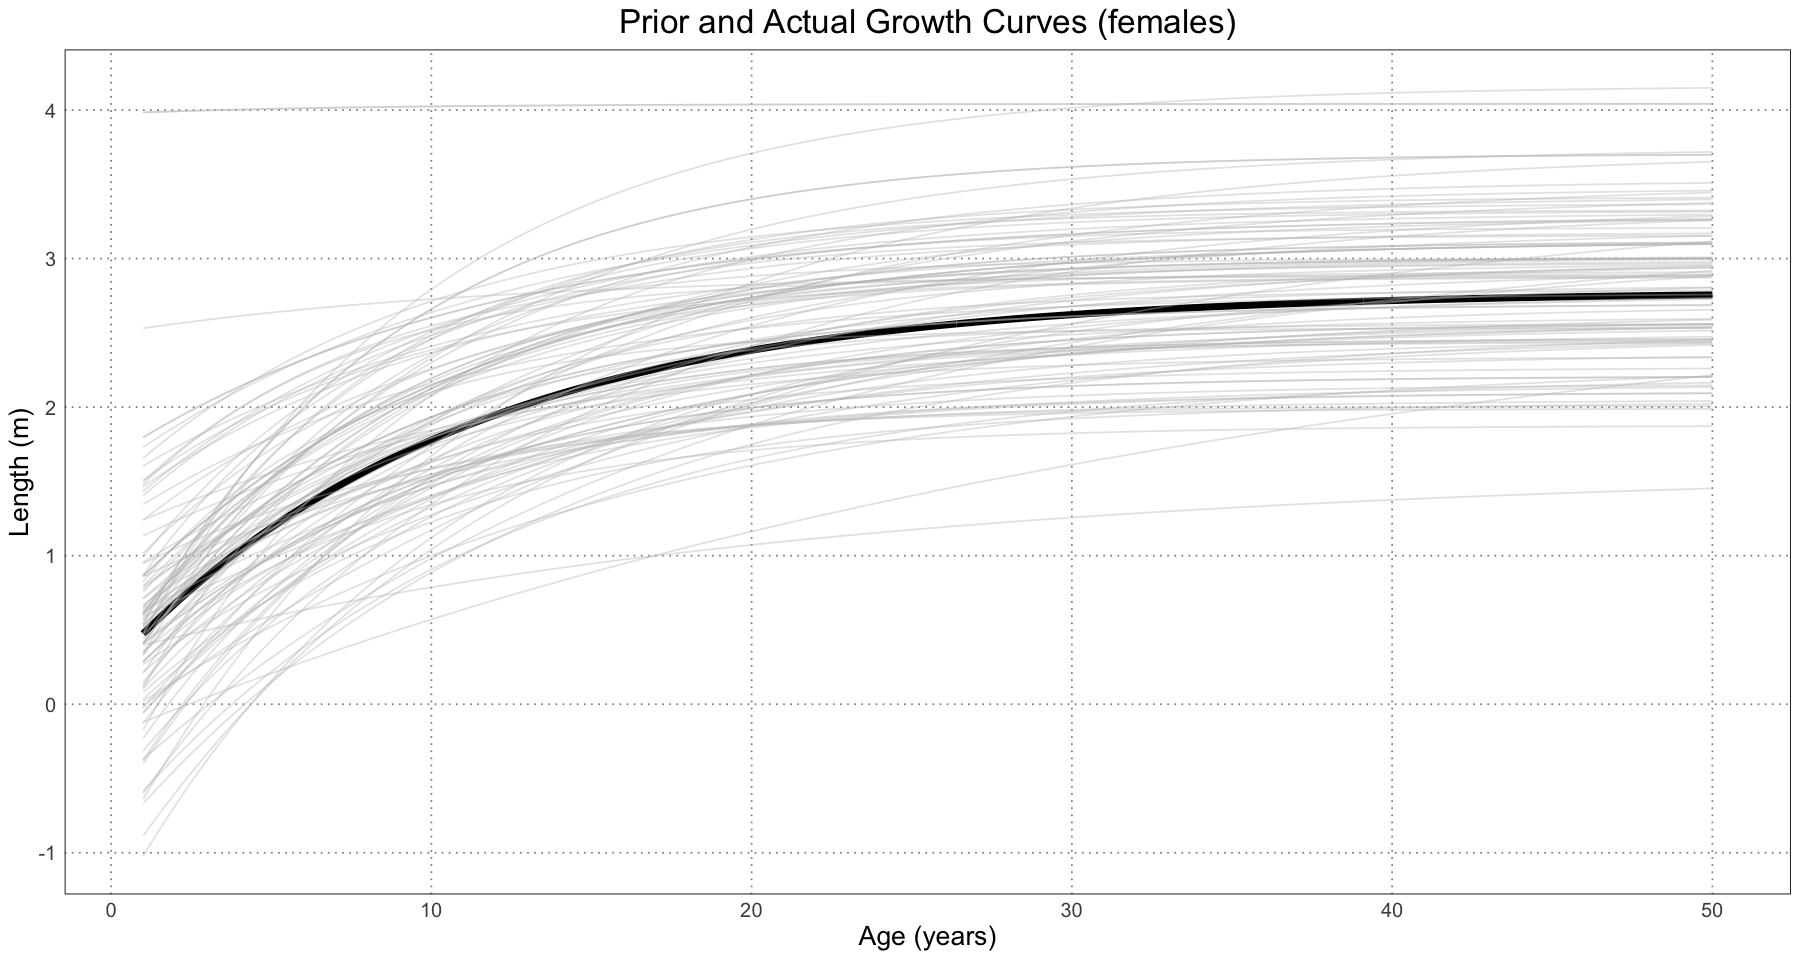

In [49]:
curve_ages <- seq(1, ALLIGATOR_MAX_LIFESPAN, by = 0.1)
curve_lengths <- generalized_von_bertalanffy(curve_ages, L = actual_female_params[['L']], A = actual_female_params[['A']], K = actual_female_params[['K']])

p <- ggplot() +
    geom_line(data = data.frame(age = curve_ages, length = curve_lengths), mapping = aes(age, length), linewidth = 2) +
    labs(x = "Age (years)", y = "Length (m)", title = "Prior and Actual Growth Curves (females)") +
    custom_theme()

    num_samples <- 1e3
Ls <- rnorm(num_samples, 2.78, 0.5)
Ks <- rnorm(num_samples, 0.0926, 0.025)
As <- rnorm(num_samples, 0.91, 0.25)
sigmas <- rnorm(num_samples, 0.25, 0.0625)

for (i in 1:100) {
    index <- sample(1:length(Ls), size = 1)
    L <- Ls[index]
    K <- Ks[index]
    A <- As[index]
    sigma <- sigmas[index]

    sample_curve_lengths <- generalized_von_bertalanffy(curve_ages, L = L, A = A, K = K)

    p <- p + geom_line(data = data.frame(age = curve_ages, length = sample_curve_lengths), mapping = aes(age, length), colour = 'grey', alpha = 0.4)
}

print(p)

This actually looks - not too bad. Obviously the curves that start negative are suspect, as are some of the ones that show very slow growth, but we can probably rely on the data to pull this back. Also, it seems like the model is not great - too many things are allowed to be negative when they shouldn't be.

- [ ] Once the dinosaurs are done, revisit this except actually use the correct formula and generate the priors *first*.

## Dinosaur Analysis

### *Maiasaura*

Let's start by getting the data for the *Maiasaura* and plotting it. The plan is:
- [ ] Plot the data
- [ ] Come up with a model and reasonable priors
- [ ] Find the posterior distributions for the different parameters
- [ ] Find the distribution for the difference (probably this can be done in Stan)

In [50]:
data <- read.csv('data/Maiasaura.csv')
head(data)

Maiasaura.Tibia.Code Tibia.Length..cm. Minimum.Diaphyseal.Circumference..cm.
1 T01                  35.0              13                                   
2 T02                  41.5              14.3                                 
3 T03                  33.8              14.4                                 
4 T04                  39.7              14.4                                 
5 T05                  39.4              14.9                                 
6 T06                  46.0              15                                   
  Calculated.Femur.Length..cm. LAG.Count LAGs.within.EFS Age..years.
1 36.2                         0         NA              0          
2 43.0                         0         NA              0          
3 35.0                         0         NA              0          
4 41.1                         0         NA              0          
5 40.8                         0         NA              0          
6 47.6                         0         NA              0          
  Age.shift..years. ROM.44770.femur.length..cm.
1 0.5               102                        
2 0.5                NA                        
3 0.5                NA                        
4 0.5                NA                        
5 0.5                NA                        
6 0.5                NA                        
  ROM.44770.femur.length.cubed..cm3. ROM.44770.estimated.mass..kg.
1 1061208                            3833                         
2      NA                              NA                         
3      NA                              NA                         
4      NA                              NA                         
5      NA                              NA                         
6      NA                              NA                         
  Femur.length.cubed..cm3.
1  47437.93               
2  79507.00               
3  42875.00               
4  69426.53               
5  67917.31               
6 107850.18               
  Cubed.femur.length.as.a.fraction.of.ROM.44770.cubed.femur.length
1 0.04470182                                                      
2 0.07492122                                                      
3 0.04040207                                                      
4 0.06542217                                                      
5 0.06400000                                                      
6 0.10162963                                                      
  Fraction.multiplied.to.ROM.44770.body.mass..kg.
1 171.3421                                       
2 287.1730                                       
3 154.8611                                       
4 250.7632                                       
5 245.3120                                       
6 389.5464

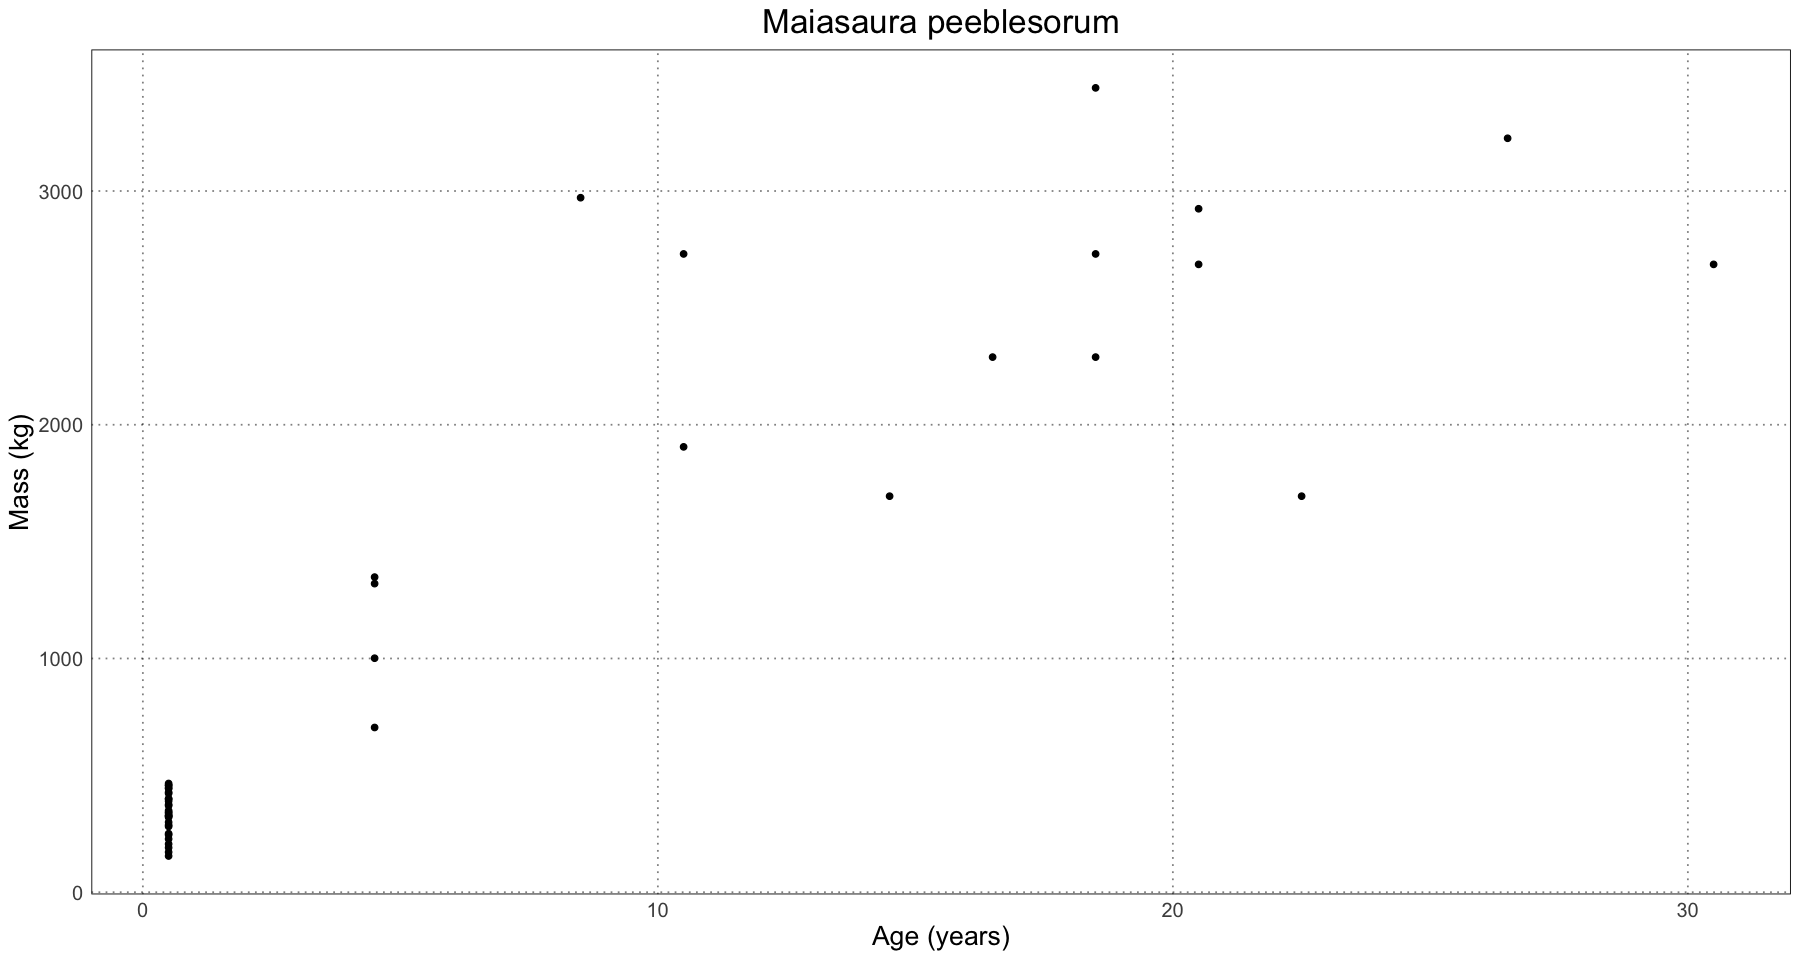

In [59]:
maiasaura <- data.frame(
    age = data$Age..years. + data$Age.shift..years.,
    mass = data$Fraction.multiplied.to.ROM.44770.body.mass..kg.
)

maiasaura_plot <- ggplot(maiasaura, aes(age, mass)) +
    geom_point() +
    labs(x = "Age (years)", y = "Mass (kg)", title = "Maiasaura peeblesorum") +
    custom_theme()

maiasaura_plot

Recall as well that we're going to fit a logistic rather than the von Bertalanffy curve we used for the alligators.

$$
M = \frac{L}{1 + e^{q+kA}}
$$

Where $M$ is the mass and $A$ is the age. In this case, our level of dimorphism is $L_l - L_s$, where where the two sexes are $l$ (the larger one) and $s$ (the smaller one).

In [60]:

generalized_logistic <- function(age, L, q, k) {
    L / (1 + exp(q + k * age))
}

generate_logistic_curve_fit <- function(df, initial_params, debug = FALSE) {
    fit <- tryCatch({ nlsLM(mass ~ generalized_logistic(age, L, q, k), data = df, start = initial_params) }, error = function(e) {
            cat("Error in generate_curve_fit", conditionMessage(e))
            print(df)
            NULL
        }
    )
    fit
}

In [61]:
initial_maiasaura_params <- list(
    L=2500,
    k=0.5,
    q=10
)

population_fit <- generate_logistic_curve_fit(maiasaura, initial_params = initial_maiasaura_params)
population_params <- coef(population_fit)
population_params

L            k            q 
2598.7882374   -0.4635612    2.2053112

Now we want to find some reasonable priors. Basically - let's just play until we get a bunch of curves that seem to roughly fit our data.

But first, I want to understand what each of these parameters does!

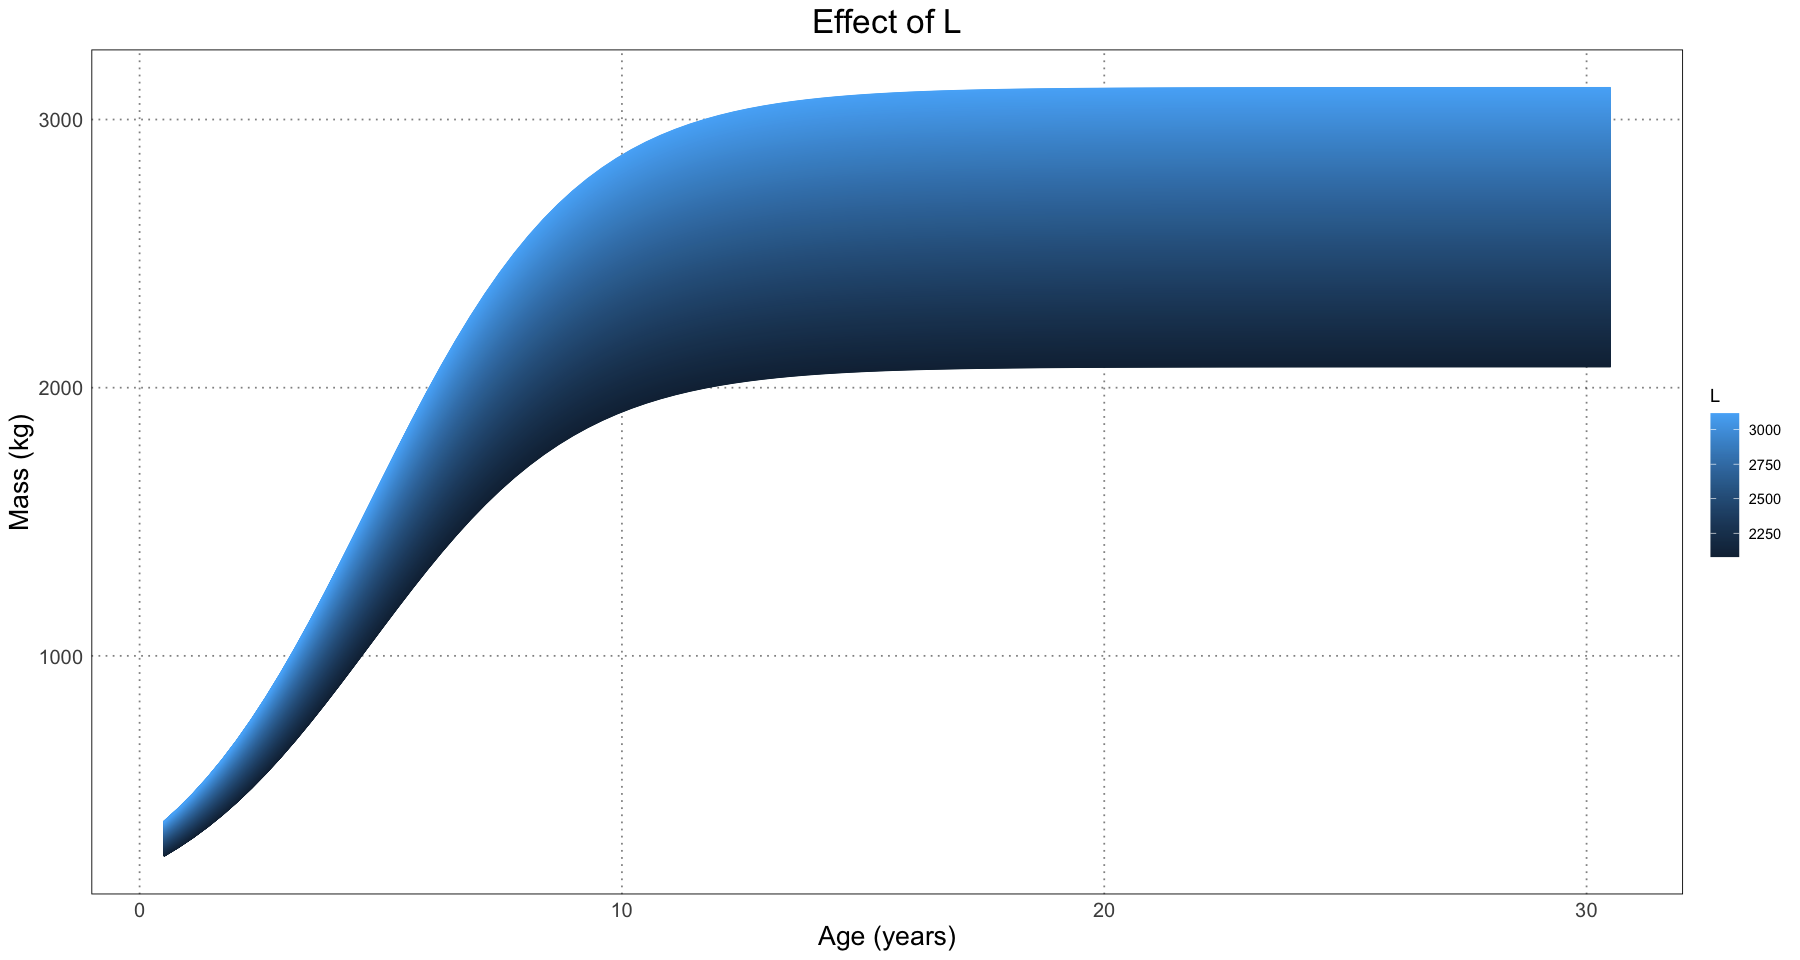

In [69]:
curve_ages <- seq(min(maiasaura$age), max(maiasaura$age), length.out = 100)
param_data <- data.frame(age = numeric(), mass = numeric(), L = numeric())
for (L in seq(0.8 * population_params[['L']], 1.2 * population_params[['L']])) {
    curve_mass <- generalized_logistic(curve_ages, L = L, k = population_params[['k']], q = population_params[['q']])
    param_data <- rbind(
        param_data,
        data.frame(age = curve_ages, mass = curve_mass, L = L)
    )
}

ggplot(param_data, aes(age, mass, group = L, colour = L)) +
    geom_line() +
    labs(x = "Age (years)", y = "Mass (kg)", title = "Effect of L") +
    custom_theme()

So roughly, this controls the asymptotic mass.

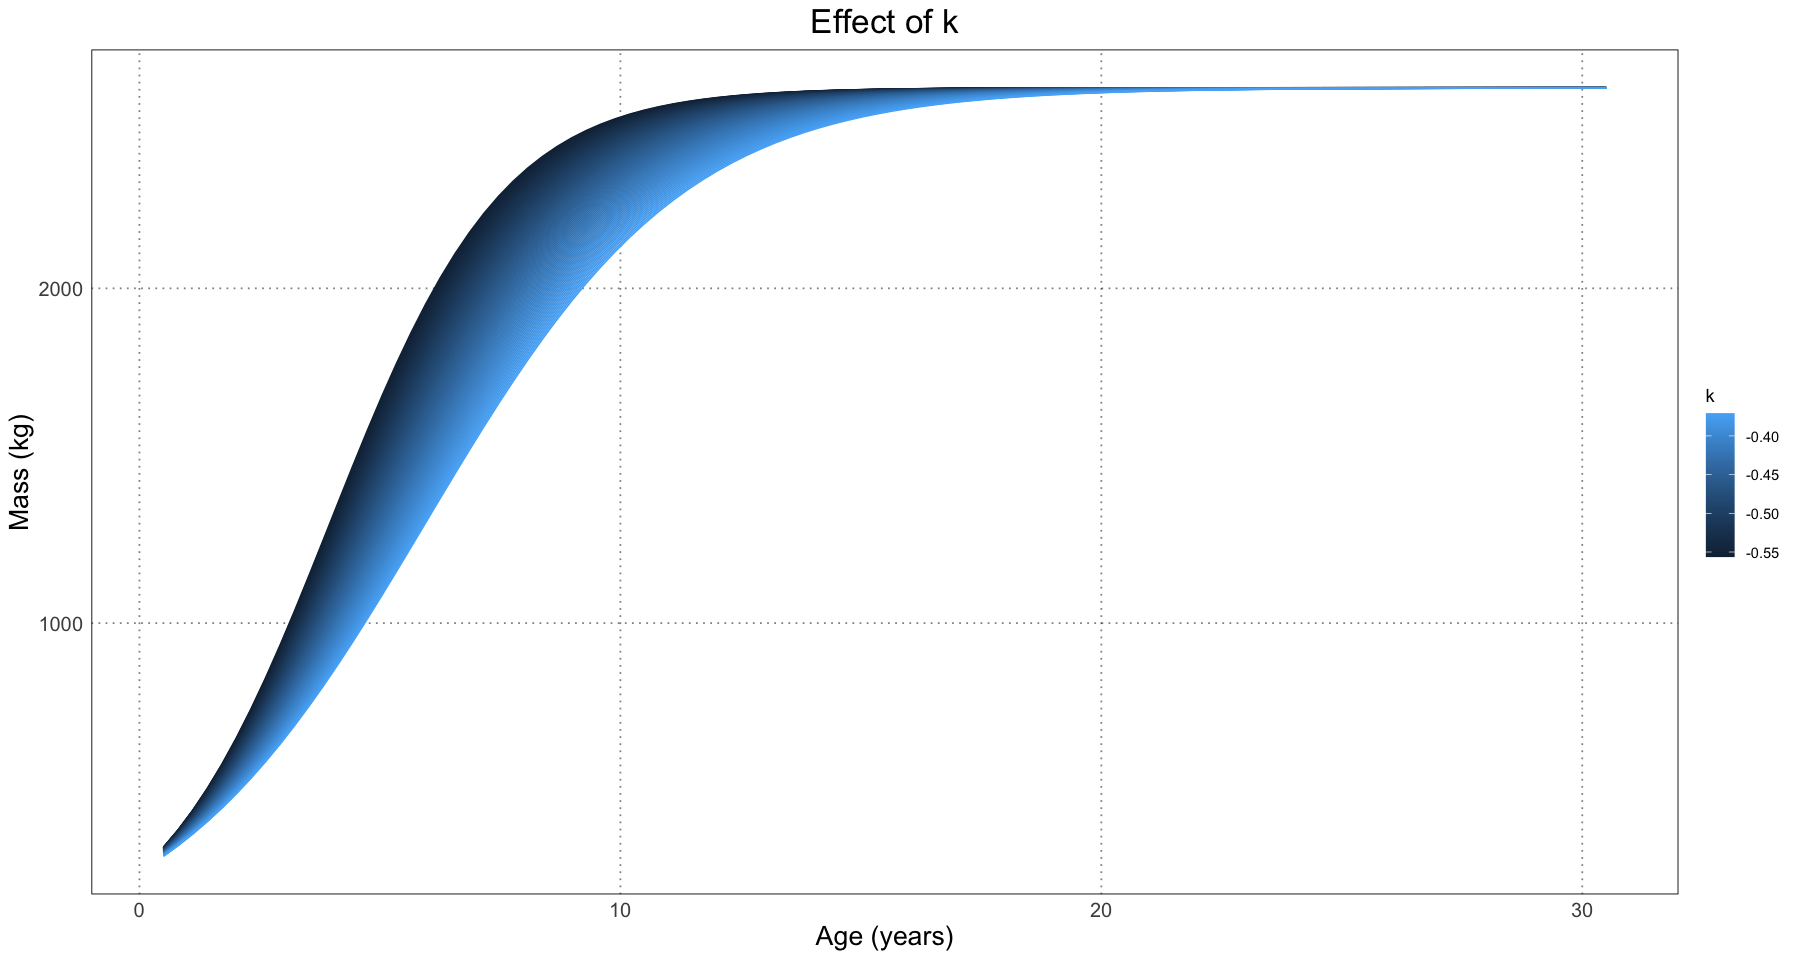

In [71]:
param_data <- data.frame(age = numeric(), mass = numeric(), k = numeric())
for (k in seq(0.8 * population_params[['k']], 1.2 * population_params[['k']], length.out = 100)) {
    curve_mass <- generalized_logistic(curve_ages, L = population_params[['L']], k = k, q = population_params[['q']])
    param_data <- rbind(
        param_data,
        data.frame(age = curve_ages, mass = curve_mass, k = k)
    )
}

ggplot(param_data, aes(age, mass, group = k, colour = k)) +
    geom_line() +
    labs(x = "Age (years)", y = "Mass (kg)", title = "Effect of k") +
    custom_theme()

Roughly, this controls the rate of growth.

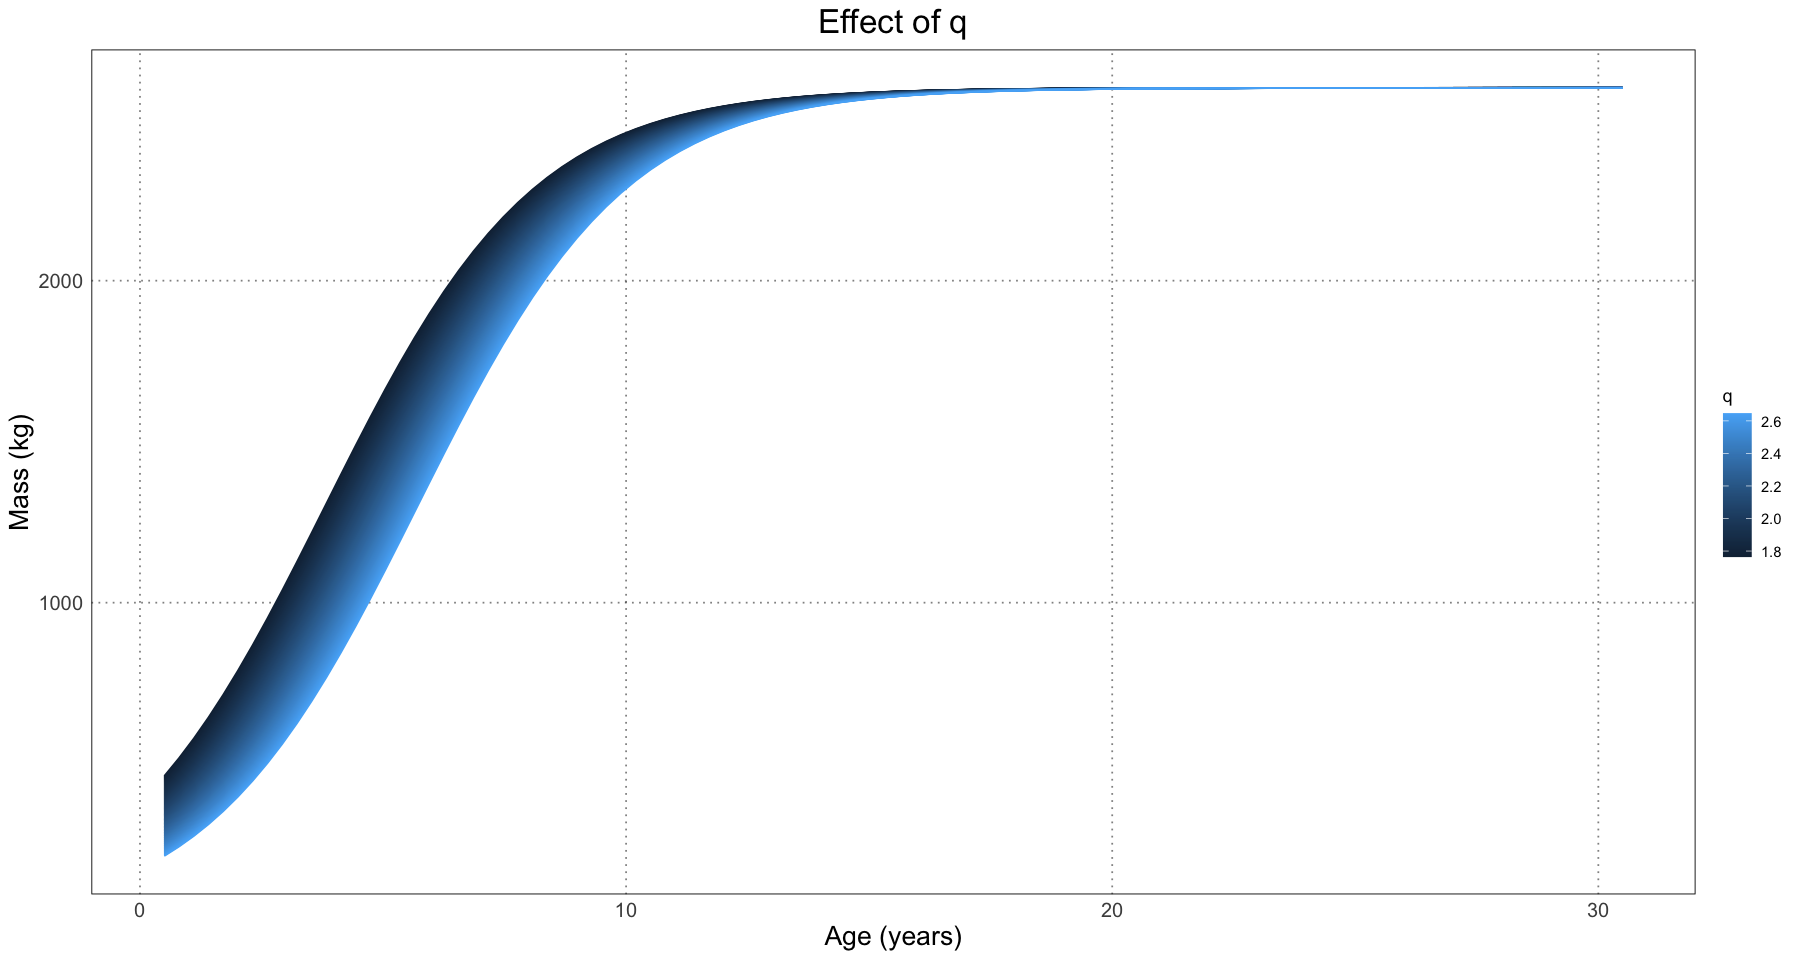

In [72]:
param_data <- data.frame(age = numeric(), mass = numeric(), q = numeric())
for (q in seq(0.8 * population_params[['q']], 1.2 * population_params[['q']], length.out = 100)) {
    curve_mass <- generalized_logistic(curve_ages, L = population_params[['L']], k = population_params[['k']], q = q)
    param_data <- rbind(
        param_data,
        data.frame(age = curve_ages, mass = curve_mass, q = q)
    )
}

ggplot(param_data, aes(age, mass, group = q, colour = q)) +
    geom_line() +
    labs(x = "Age (years)", y = "Mass (kg)", title = "Effect of q") +
    custom_theme()

Roughly, this controls the starting mass

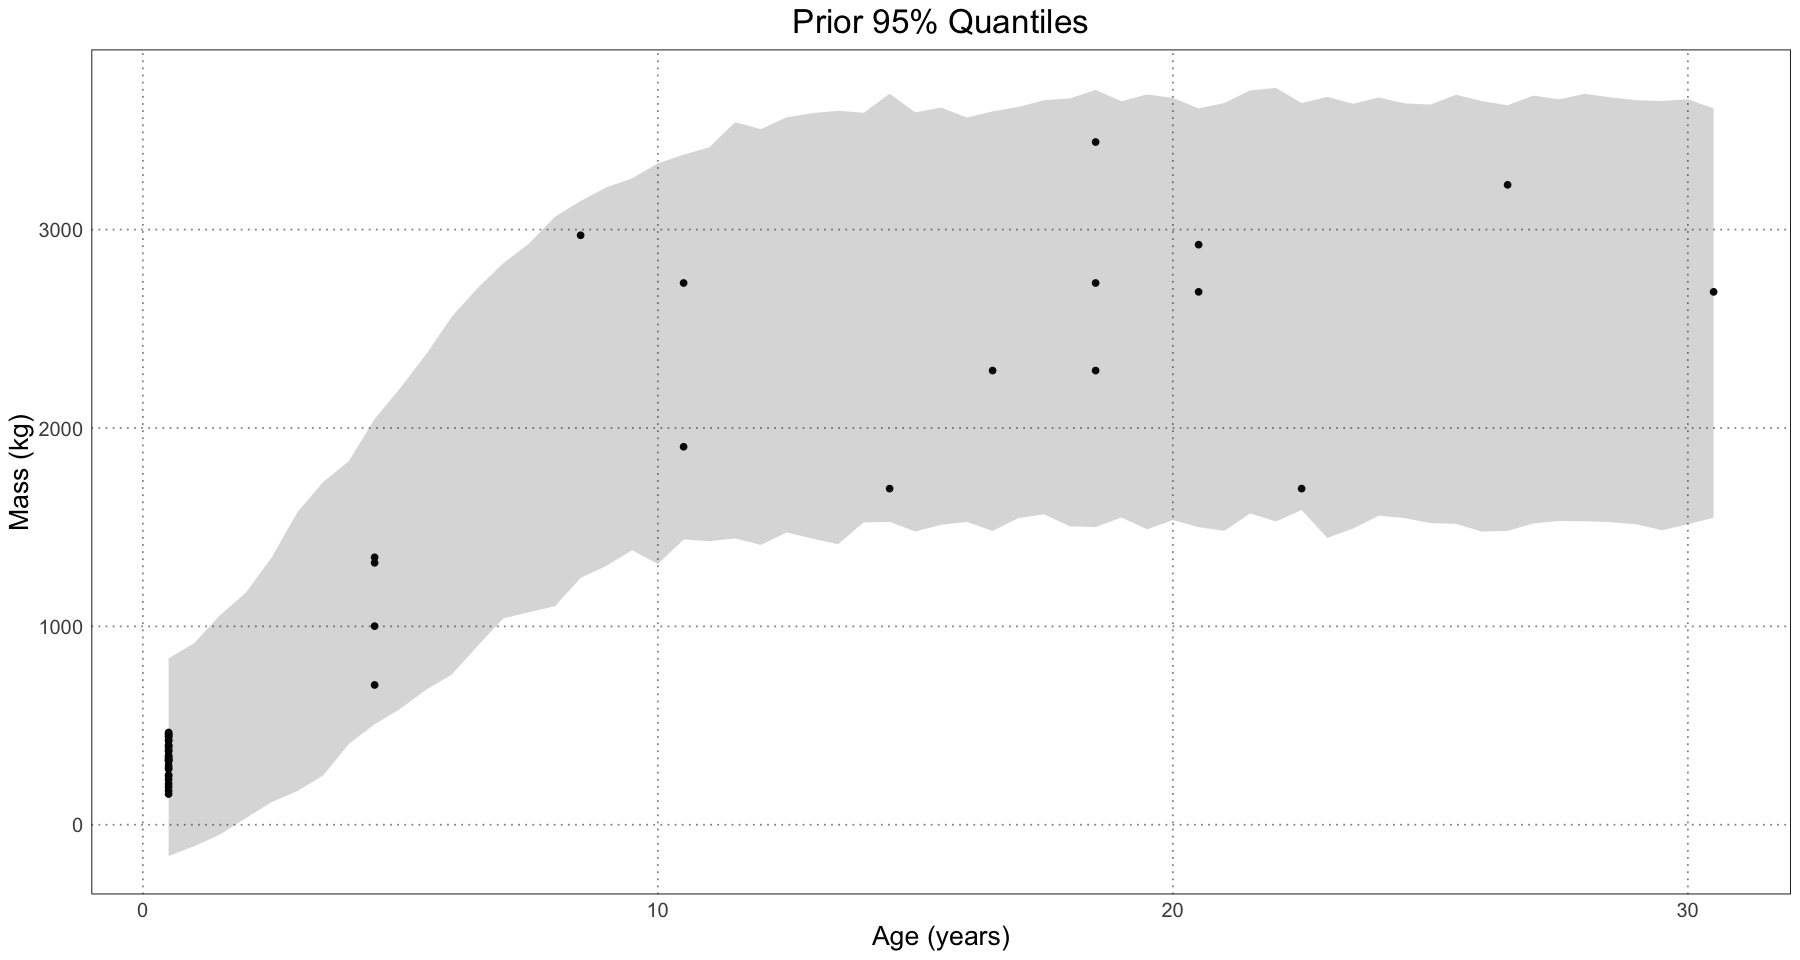

In [100]:
num_samples <- 1e3
Ls <- rnorm(num_samples, population_params[['L']], sd = 500)
ks <- rnorm(num_samples, population_params[['k']], sd = 0.0125)
qs <- rnorm(num_samples, population_params[['q']], sd = 0.4)
sigmas <- rnorm(num_samples, 200, 50)

curve_data <- data.frame(age = numeric(), length = numeric())
curve_ages <- seq(min(maiasaura$age), max(maiasaura$age), by = 0.5)
for (i in 1:1e3) {
    index <- sample(1:num_samples, size = 1)
    L <- Ls[index]
    k <- ks[index]
    q <- qs[index]
    sigma <- sigmas[index]

    curve_mass_mean <- generalized_logistic(curve_ages, L = L, k = k, q = q)
    curve_mass <- rnorm(length(curve_mass_mean), mean = curve_mass_mean, sd = sigma)
    curve_data <- rbind(
        curve_data,
        data.frame(age = curve_ages, mass = curve_mass)
    )
    # plot_with_priors <- plot_with_priors + geom_line(data = data.frame(age = curve_ages, mass = curve_mass), colour = 'grey', alpha = 0.5)
}
# curve_data


range_df <- data.frame(age = numeric(), lower = numeric(), upper = numeric())
for (age in unique(curve_data$age)) {
    relevant <- curve_data[abs(curve_data$age - age) < 0.1, ]
    masses <- relevant$mass
    lower <- quantile(masses, c(0.025))
    upper <- quantile(masses, c(0.975))
    range_df <- rbind(
        range_df,
        data.frame(
            age = age,
            lower = lower,
            upper = upper
        )
    )
}
ggplot() +
    geom_point(data = maiasaura, mapping = aes(age, mass)) +
    geom_ribbon(data = range_df, mapping = aes(x = age, ymin = lower, ymax = upper), alpha = 0.2) +
    labs(x = "Age (years)", y = "Mass (kg)", title = "Prior 95% Quantiles") +
    custom_theme()

This looks reasonable to me. If these are our priors, then the difference in the $L$ parameters is distributed as

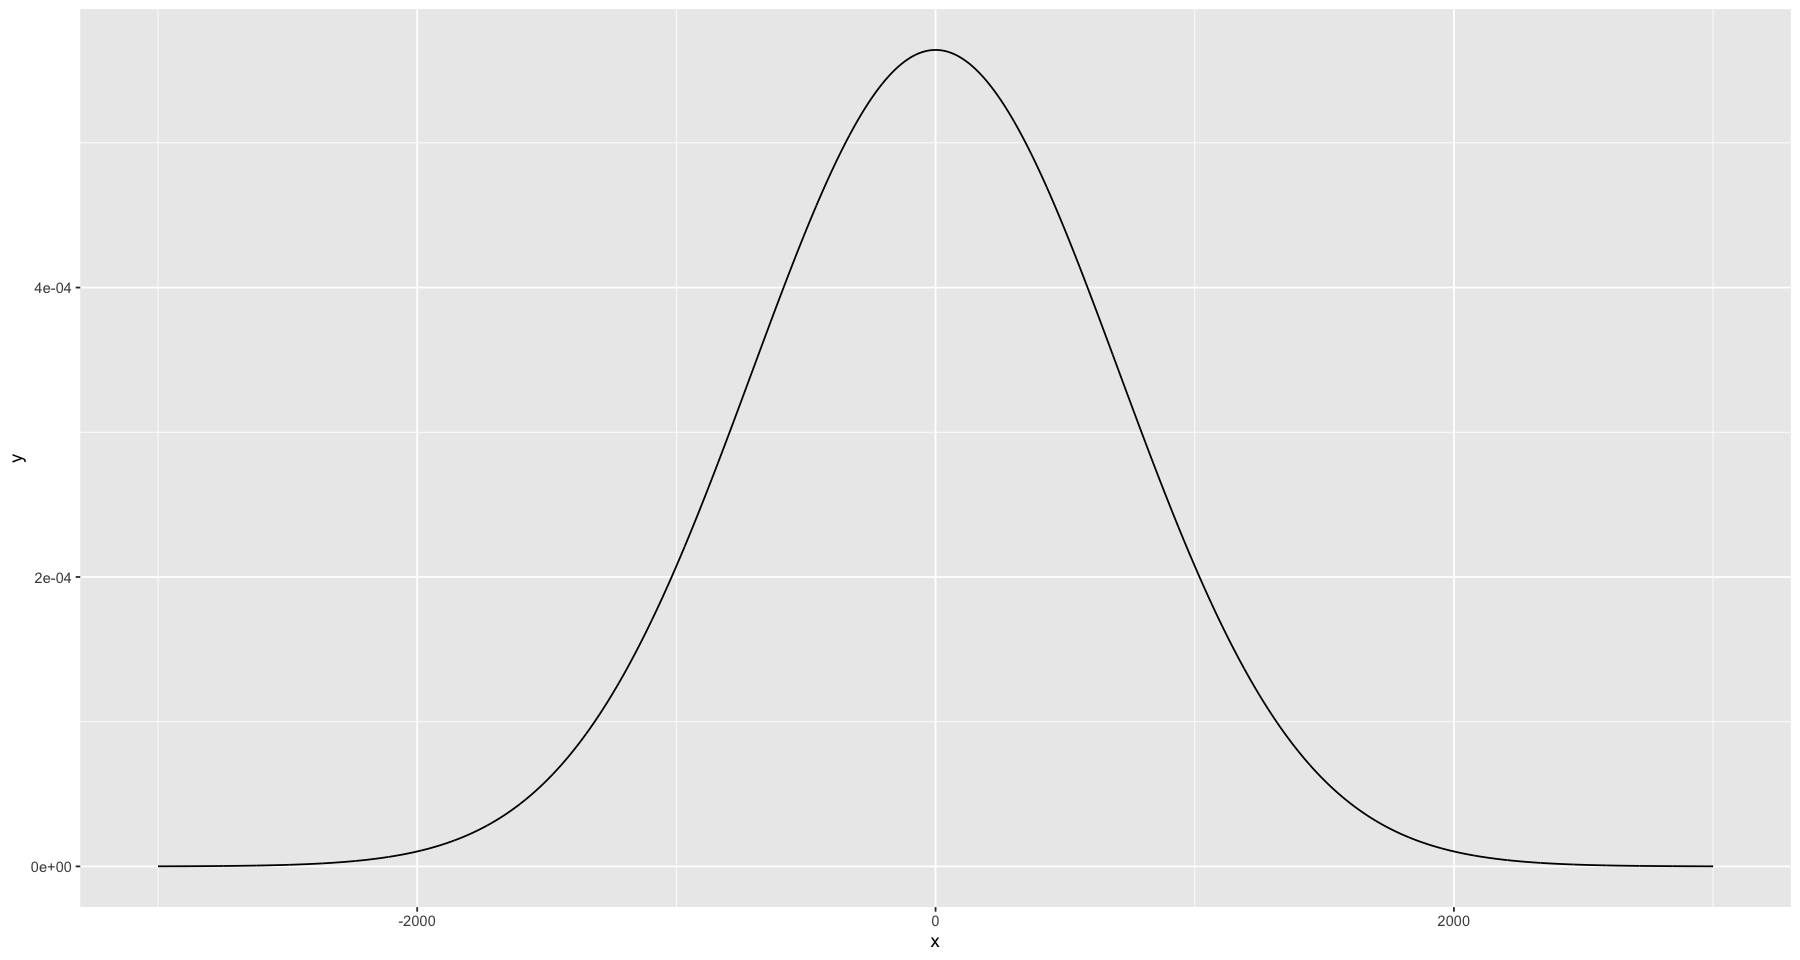

In [77]:
diffs <- seq(-3000, 3000, by = 1)
dens <- dnorm(diffs, mean = 0, sd = sqrt(500^2 + 500^2))
ggplot(data.frame(x = diffs, y = dens), aes(x, y)) +
    geom_line()

Again, this seems roughly reasonable - before looking too much at the data we initially expect there to be no dimorphism, but we wouldn't be surprised if the actual difference was even up to about 2000kg (roughly). Looking at the data, this is about the difference between the largest and smallest adults, so again that all seems within the range of possibilities.

Great! So now let's actually fit the data.

In [195]:
logistic_dimorphism_model <- "
data {
    // large sex data
    int<lower = 0> N_large; // number of males
    vector[N_large] age_large;
    vector[N_large] mass_large;

    // small sex data
    int<lower = 0> N_small;
    vector[N_small] age_small;
    vector[N_small] mass_small;

    // priors
    real prior_L_mean;
    real prior_L_sd;
    real prior_k_mean;
    real prior_k_sd;
    real prior_q_mean;
    real prior_q_sd;
    real prior_sigma_mean;
    real prior_sigma_sd;
}

parameters {
    real L_large;
    real k_large;
    real q_large;

    real L_small;
    real k_small;
    real q_small;

    real mass_sd;
}

model {
    mass_sd ~ normal(prior_sigma_mean, prior_sigma_sd);

    // large sex model
    L_large ~ normal(prior_L_mean, prior_L_sd);
    k_large ~ normal(prior_k_mean, prior_k_sd);
    q_large ~ normal(prior_q_mean, prior_q_sd);
    mass_large ~ normal(L_large * inv((1 + exp(q_large + k_large * age_large))), mass_sd);
    
    // small sex model
    L_small ~ normal(prior_L_mean, prior_L_sd);
    k_small ~ normal(prior_k_mean, prior_k_sd);
    q_small ~ normal(prior_q_mean, prior_q_sd);
    mass_small ~ normal(L_small * inv((1 + exp(q_small + k_small * age_small))), mass_sd);
}

generated quantities {
    real difference;
    difference = L_large - L_small;

    real relative_difference;
    relative_difference = L_large / L_small;
}
"

In [204]:
# now fit the maiasaura data
maiasaura$residual <- resid(population_fit)
maiasaura$sex <- ifelse(maiasaura$residual < 0, "S", "L")
large_sex_data <- subset(maiasaura, sex == "L")
small_sex_data <- subset(maiasaura, sex == "S")

model_data <- list(
    N_large = nrow(large_sex_data),
    age_large = large_sex_data$age,
    mass_large = large_sex_data$mass,
    N_small = nrow(small_sex_data),
    age_small = small_sex_data$age,
    mass_small = small_sex_data$mass,
    prior_L_mean = population_params[['L']],
    prior_L_sd = 500,
    prior_k_mean = population_params[['k']],
    prior_k_sd = 0.0125,
    prior_q_mean = population_params[['q']],
    prior_q_sd = 0.4,
    prior_sigma_mean = 200,
    prior_sigma_sd = 50
)

maiasaura.model <- stan(model_code = logistic_dimorphism_model, data = model_data)

In [205]:
maiasaura.model

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                       mean se_mean     sd    2.5%     25%     50%     75%
L_large             2976.00    0.81  63.08 2855.11 2935.60 2975.53 3017.10
k_large               -0.47    0.00   0.01   -0.49   -0.47   -0.47   -0.46
q_large                2.16    0.00   0.10    1.96    2.09    2.15    2.22
L_small             2020.78    1.10  81.38 1863.78 1966.39 2020.32 2074.46
k_small               -0.46    0.00   0.01   -0.49   -0.47   -0.46   -0.45
q_small                2.33    0.00   0.18    1.98    2.21    2.33    2.45
mass_sd              175.31    0.25  18.37  143.09  162.41  174.09  187.22
difference           955.23    1.36 101.23  755.91  888.08  955.95 1021.23
relative_difference    1.48    0.00   0.07    1.35    1.43    1.47    1.52
lp__                -261.46    0.04   1.94 -266.28 -262.49 -261.15 -260.03
                   

In [206]:
maiasaura_samples <- extract(maiasaura.model)
lapply(maiasaura_samples, head)

$L_large
[1] 3065.267 2885.794 3002.473 2960.744 2943.338 2858.399

$k_large
[1] -0.4723741 -0.4574747 -0.4905492 -0.4782835 -0.4561035 -0.4596555

$q_large
[1] 2.355558 2.103696 2.115266 2.164034 1.976851 1.950714

$L_small
[1] 1921.002 1948.822 2093.527 1975.654 1983.692 2008.904

$k_small
[1] -0.4659103 -0.4486157 -0.4490654 -0.4691871 -0.4671403 -0.4727464

$q_small
[1] 2.525025 1.939984 1.982629 2.181720 2.264600 2.130214

$mass_sd
[1] 159.0948 154.9010 183.2965 193.0164 175.0214 177.2343

$difference
[1] 1144.2647  936.9717  908.9469  985.0908  959.6457  849.4950

$relative_difference
[1] 1.595660 1.480789 1.434170 1.498615 1.483767 1.422865

$lp__
[1] -262.8895 -262.9896 -264.6426 -260.0254 -259.8128 -261.8959

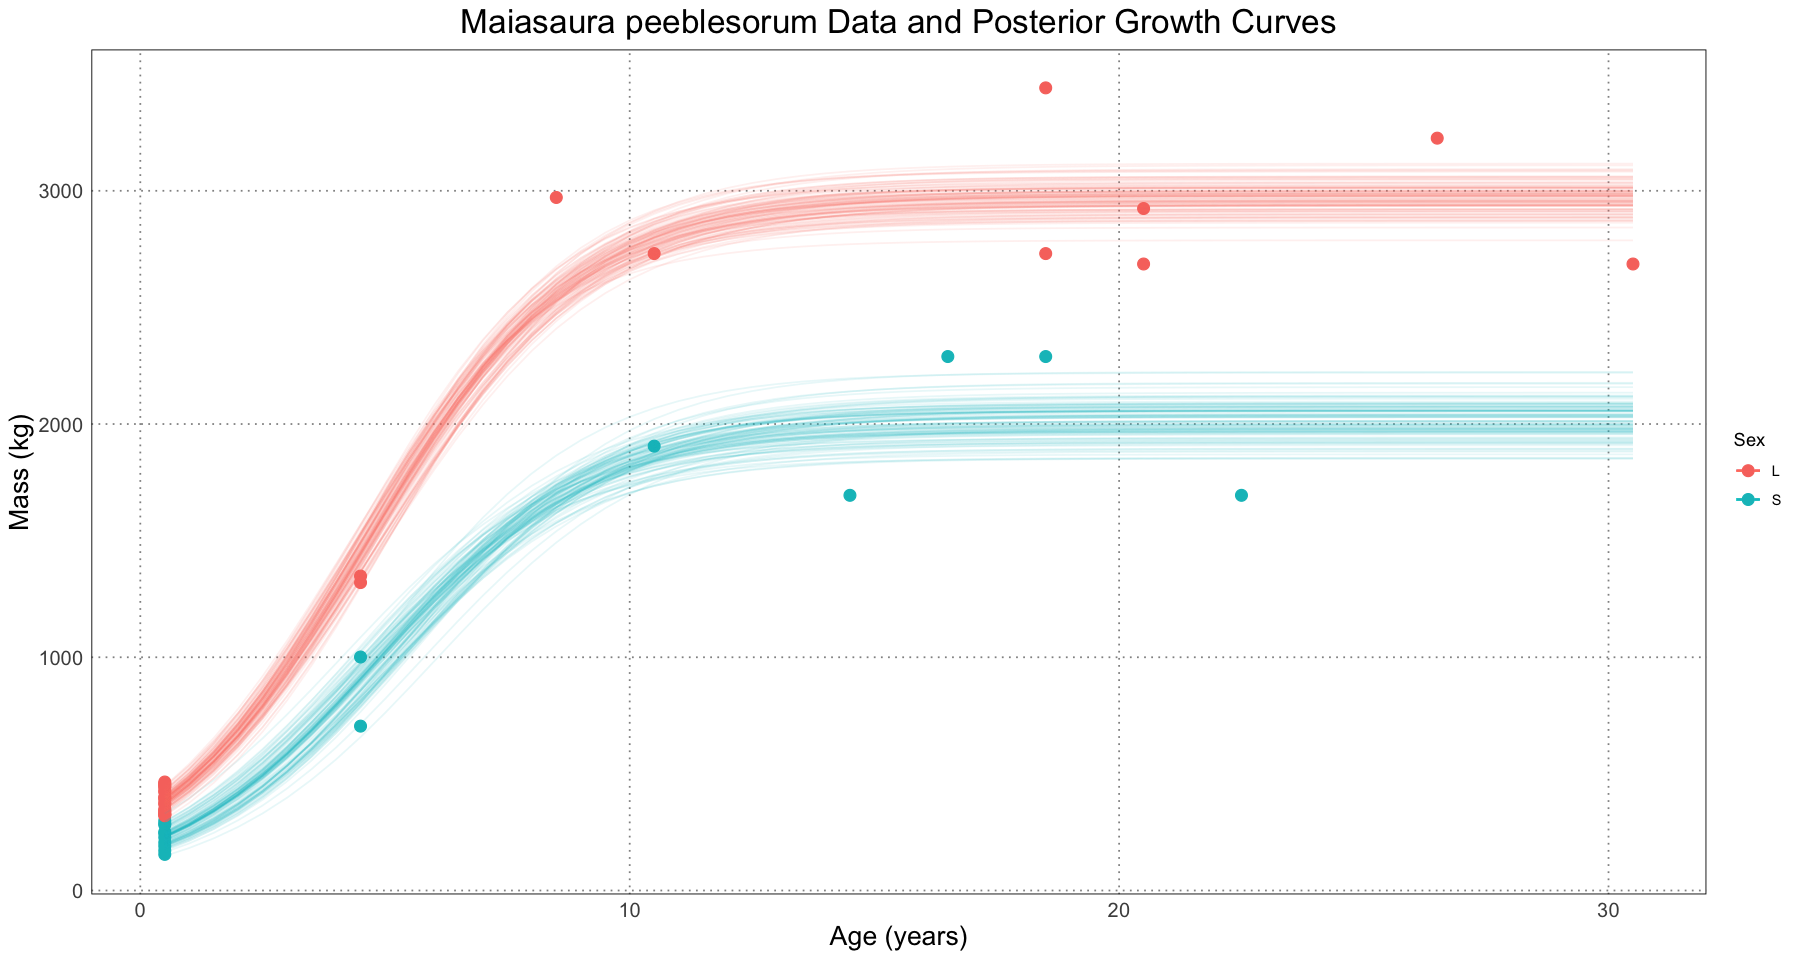

In [213]:
p <- ggplot() +
    custom_theme() +
    geom_point(maiasaura, mapping = aes(age, mass, colour = sex), size = 3) +
    labs(x = "Age (years)", y = "Mass (kg)", colour = "Sex")

# draw in samples from the male and female curves
for (i in 1:100) {
    index <- sample(1:length(maiasaura_samples[[ 'L_small' ]]), size = 1)
    L_small <- maiasaura_samples[['L_small']][index]
    k_small <- maiasaura_samples[['k_small']][index]
    q_small <- maiasaura_samples[['q_small']][index]
    curve_mass_small <- generalized_logistic(curve_ages, L = L_small, k = k_small, q = q_small)

    L_large <- maiasaura_samples[['L_large']][index]
    k_large <- maiasaura_samples[['k_large']][index]
    q_large <- maiasaura_samples[['q_large']][index]
    curve_mass_large <- generalized_logistic(curve_ages, L = L_large, k = k_large, q = q_large)

    p <- p + 
        geom_line(data = data.frame(age = curve_ages, mass = curve_mass_small, sex = "S"), mapping = aes(age, mass, colour = sex), alpha = 0.1) +
        geom_line(data = data.frame(age = curve_ages, mass = curve_mass_large, sex = "L"), mapping = aes(age, mass, colour = sex), alpha = 0.1)

}
p <- p + labs(title = "Maiasaura peeblesorum Data and Posterior Growth Curves")
print(p)

We can also look at the absolute difference in the asymptotic growth curves (the level of dimorphism).

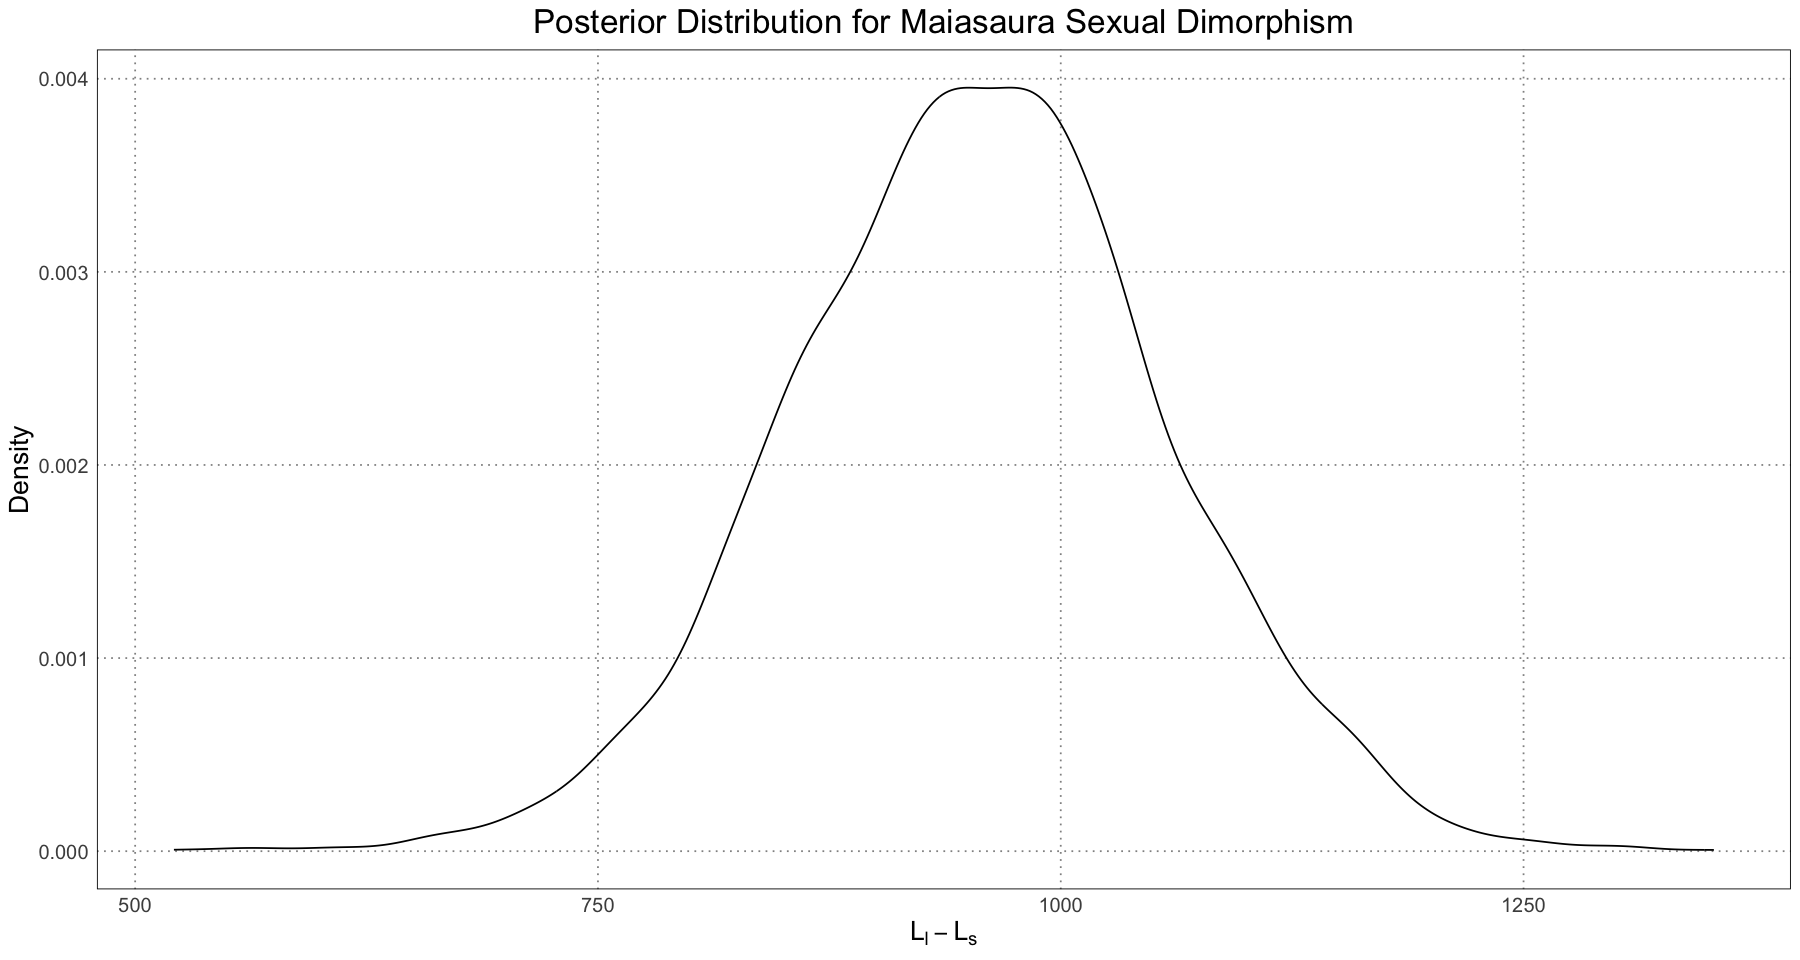

In [208]:
ggplot(data.frame(x = maiasaura_samples[['difference']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    labs(x = expression(L[l] - L[s]), y = "Density", title = "Posterior Distribution for Maiasaura Sexual Dimorphism") +
    custom_theme()

As pointed out the in paper, this works but makes it difficult to compare between different taxa. To make that part easier, we can look at the percent difference between the larger and smaller sex.

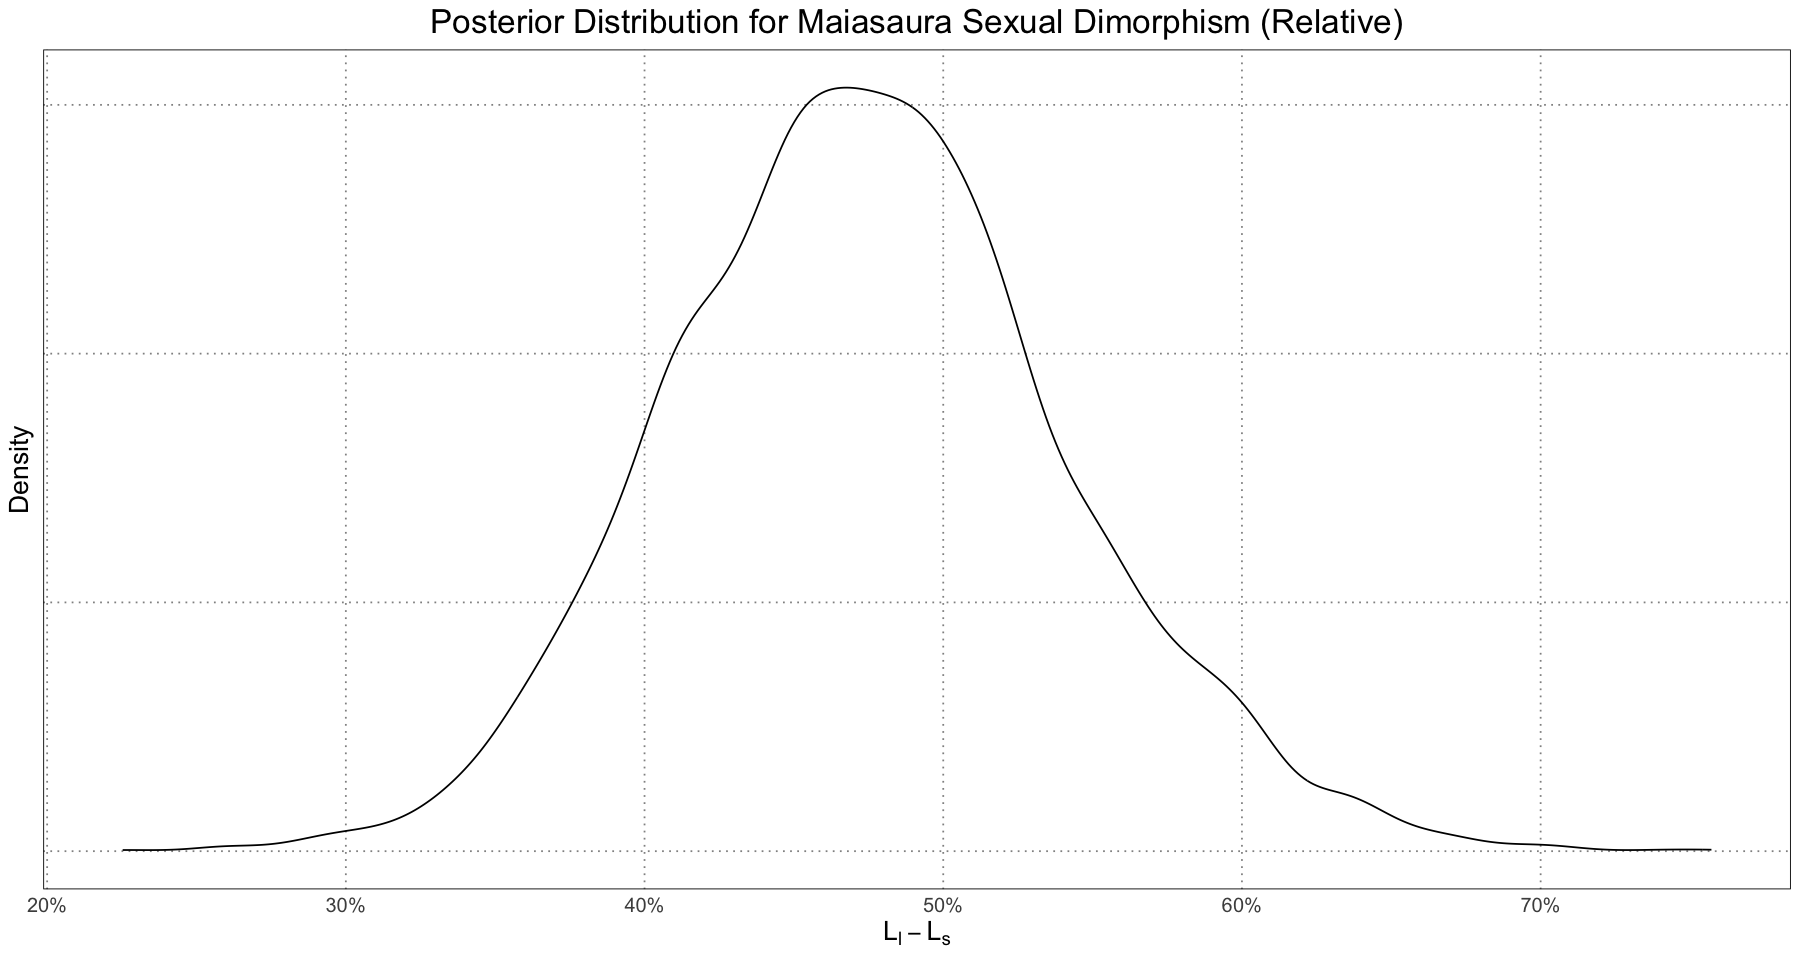

In [242]:
ggplot(data.frame(x = maiasaura_samples[['relative_difference']] - 1), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    labs(x = expression(L[l] - L[s]), y = "Density", title = "Posterior Distribution for Maiasaura Sexual Dimorphism (Relative)") +
    scale_x_continuous(labels = scales::percent) +
    scale_y_continuous(labels = NULL) +
    custom_theme()

## Psittacosaurus lujiatunensis

Let's do the same with the Psittacosaurus data!

In [210]:
data <- read.csv('data/Psittacosaurus.csv')
head(data)

Specimen    Femur.length..mm. Age.estimate..years.
1 IVPP 14155  31.0              0                   
2 D2156       32.5              0                   
3 IVPP 12704  30.0              0                   
4 PKUVP V1058 52.0              0                   
5 PKUVP V1058 52.0              0                   
6 LPM R00142  34.0              1                   
  Age.estimate.shifted..years. Femur.length.cubed..mm3.
1 0.5                           29791.00               
2 0.5                           34328.12               
3 0.5                           27000.00               
4 0.5                          140608.00               
5 0.5                          140608.00               
6 1.5                           39304.00               
  Largest.specimen..ZMNH.M8138..femur.length.cubed..mm3.
1 8120601                                               
2      NA                                               
3      NA                                               
4      NA                                               
5      NA                                               
6      NA                                               
  Largest.specimen..ZMNH.M8138..body.mass..kg.
1 25.96                                       
2    NA                                       
3    NA                                       
4    NA                                       
5    NA                                       
6    NA                                       
  Femur.length.cubed.femur.length.cubed.of.largest.specimen..ZMNH.M8138.
1 0.003668571                                                           
2 0.004227289                                                           
3 0.003324877                                                           
4 0.017314975                                                           
5 0.017314975                                                           
6 0.004840036                                                           
  Estimated.body.mass..kg.
1 0.09523610              
2 0.10974041              
3 0.08631381              
4 0.44949674              
5 0.44949674              
6 0.12564733              
  We.added.0.5.to.all.datapoints.in.order.to.more.easily.fit.the.curve.when.specimens.have.0.LAGs                                                                                                                                                                                                        
1 We used ZMNH M8138 as the largest specimen and calculated LPM R00117 based off of this, even though both have the same circumference, because the femurs appear to be 1 cm different in length. We did this to be consistent with the way we calculated body mass of all the other specimens using DME.
2 Table 1 lists n=34 for this specimen, but lists a range of femur lengths from 31-34 mm, so we coded 1 specimen with a femur length at the midpoint of this range                                                                                                                                       
3 For specimens with age estimates <1, we coded as 0 years prior to shift                                                                                                                                                                                                                                
4 Table 1 lists n=2 for this specimen with both femur lengths in parentheses equalling 52 mm, so we coded 2 specimens with femur lengths of 52 mm                                                                                                                                                        
5                                                                                                                                                                                                                                                                                                        
6 Table 1 lists n=4 for

In [219]:
psittacosaurus <- data.frame(
    age = data$Age.estimate.shifted..years.,
    mass = data$Estimated.body.mass..kg.
)

initial_psittacosaurus_params <- list(
    L=37.38,
    k=0.55,
    q=10
)

fit.population <- generate_logistic_curve_fit(psittacosaurus, initial_params = initial_psittacosaurus_params)
psittacosaurus_population_params <- coef(fit.population)

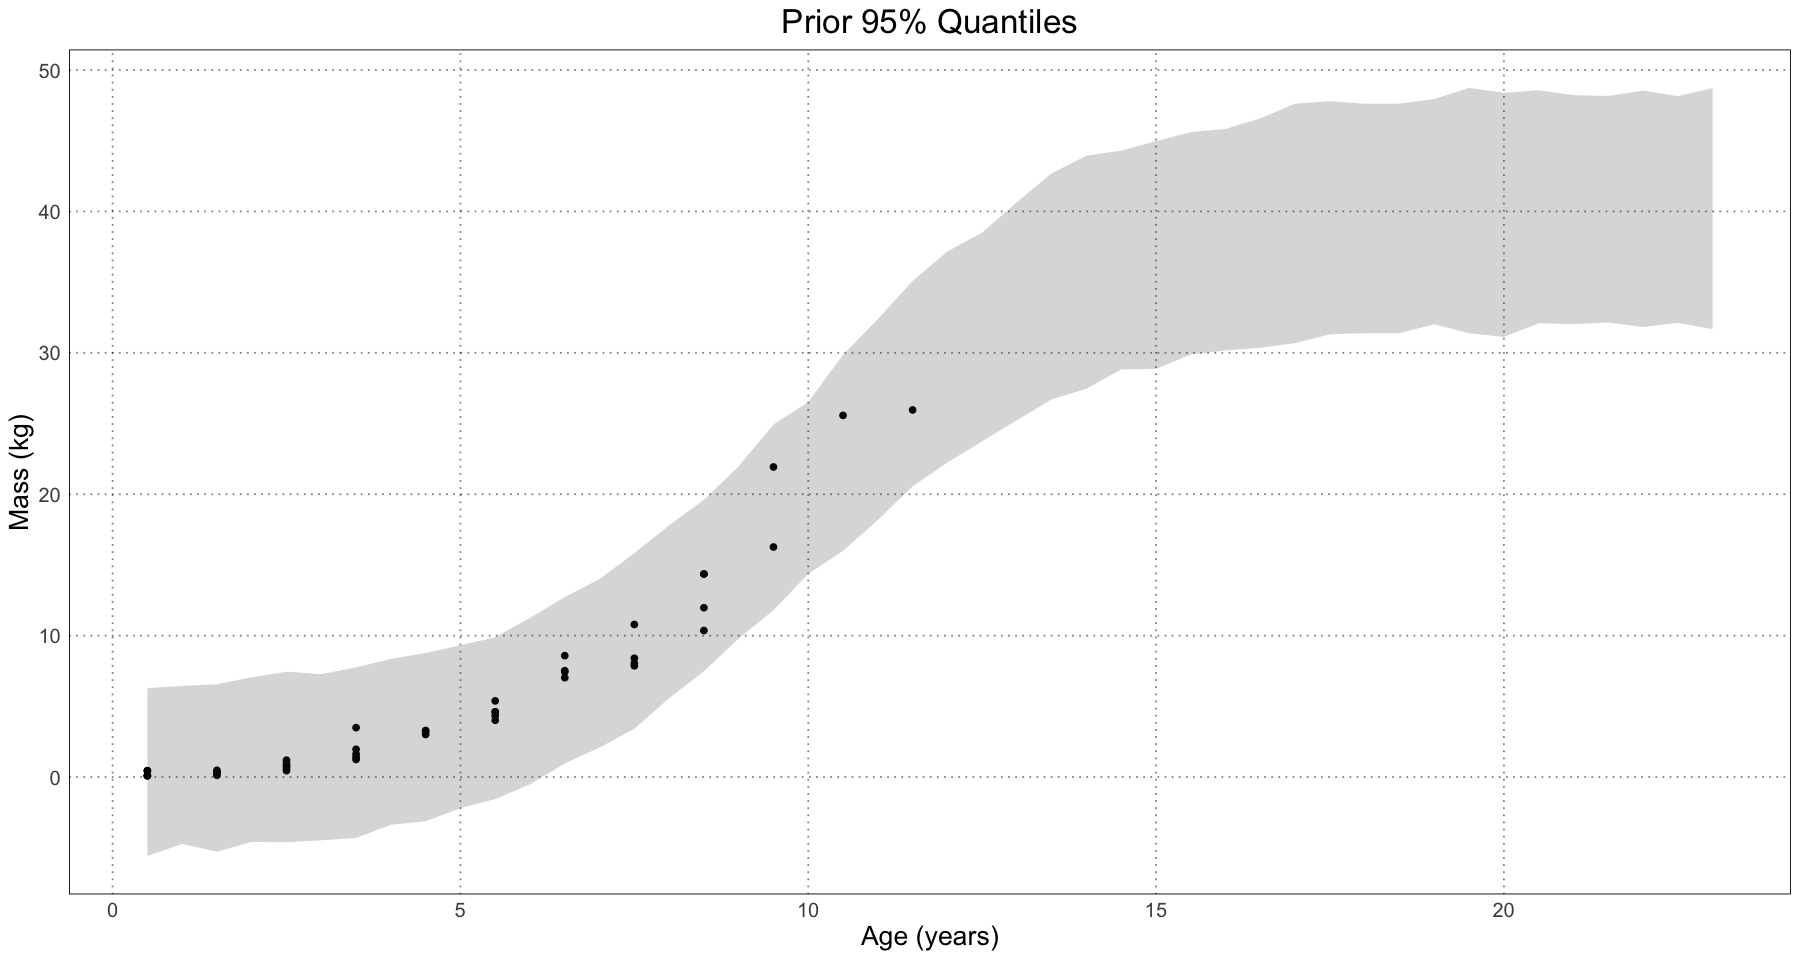

In [230]:
# Find priors
num_samples <- 1e3
prior_L_sd <- 3
Ls <- rnorm(num_samples, psittacosaurus_population_params[['L']], sd = prior_L_sd)
prior_k_sd <- 0.00125
ks <- rnorm(num_samples, psittacosaurus_population_params[['k']], sd = prior_k_sd)
prior_q_sd <- 0.0004
qs <- rnorm(num_samples, psittacosaurus_population_params[['q']], sd = prior_q_sd)
prior_sigma_mean <- 3
prior_sigma_sd <- 0.1
sigmas <- rnorm(num_samples, prior_sigma_mean, prior_sigma_sd)

curve_data <- data.frame(age = numeric(), length = numeric())
curve_ages <- seq(min(psittacosaurus$age), 2 * max(psittacosaurus$age), by = 0.5)
for (i in 1:1e3) {
    index <- sample(1:num_samples, size = 1)
    L <- Ls[index]
    k <- ks[index]
    q <- qs[index]
    sigma <- sigmas[index]

    curve_mass_mean <- generalized_logistic(curve_ages, L = L, k = k, q = q)
    curve_mass <- rnorm(length(curve_mass_mean), mean = curve_mass_mean, sd = sigma)
    curve_data <- rbind(
        curve_data,
        data.frame(age = curve_ages, mass = curve_mass)
    )
}

range_df <- data.frame(age = numeric(), lower = numeric(), upper = numeric())
for (age in unique(curve_data$age)) {
    relevant <- curve_data[abs(curve_data$age - age) < 0.1, ]
    masses <- relevant$mass
    lower <- quantile(masses, c(0.025))
    upper <- quantile(masses, c(0.975))
    range_df <- rbind(
        range_df,
        data.frame(
            age = age,
            lower = lower,
            upper = upper
        )
    )
}
ggplot() +
    geom_point(data = psittacosaurus, mapping = aes(age, mass)) +
    geom_ribbon(data = range_df, mapping = aes(x = age, ymin = lower, ymax = upper), alpha = 0.2) +
    labs(x = "Age (years)", y = "Mass (kg)", title = "Prior 95% Quantiles") +
    custom_theme()

Again, this is roughly OK. Obviously the fact that we have so much negative mass at hatching is problematic, but almost surely that's a model specification problem rather than an actual issue with the parameters.

In [235]:
# now fit the psittacosaurus data
psittacosaurus$residual <- resid(fit.population)
psittacosaurus$sex <- ifelse(psittacosaurus$residual < 0, "S", "L")
large_sex_data <- subset(psittacosaurus, sex == "L")
small_sex_data <- subset(psittacosaurus, sex == "S")

model_data <- list(
    N_large = nrow(large_sex_data),
    age_large = large_sex_data$age,
    mass_large = large_sex_data$mass,
    N_small = nrow(small_sex_data),
    age_small = small_sex_data$age,
    mass_small = small_sex_data$mass,
    prior_L_mean = psittacosaurus_population_params[['L']],
    prior_L_sd = prior_L_sd,
    prior_k_mean = psittacosaurus_population_params[['k']],
    prior_k_sd = prior_k_sd,
    prior_q_mean = psittacosaurus_population_params[['q']],
    prior_q_sd = prior_q_sd,
    prior_sigma_mean = prior_sigma_mean,
    prior_sigma_sd = prior_sigma_sd
)

psittacosaurus.model <- stan(model_code = logistic_dimorphism_model, data = model_data)

In [236]:
psittacosaurus.model

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean   sd   2.5%    25%    50%    75%  97.5%
L_large              42.89    0.05 2.08  38.95  41.46  42.88  44.31  46.94
k_large              -0.48    0.00 0.00  -0.48  -0.48  -0.48  -0.48  -0.48
q_large               4.75    0.00 0.00   4.75   4.75   4.75   4.75   4.75
L_small              37.92    0.04 1.99  34.03  36.57  37.92  39.27  41.93
k_small              -0.48    0.00 0.00  -0.48  -0.48  -0.48  -0.48  -0.48
q_small               4.75    0.00 0.00   4.75   4.75   4.75   4.75   4.75
mass_sd               2.86    0.00 0.10   2.66   2.79   2.86   2.93   3.06
difference            4.97    0.06 2.90  -0.64   2.96   5.00   6.93  10.68
relative_difference   1.13    0.00 0.08   0.98   1.08   1.13   1.19   1.30
lp__                -53.00    0.04 1.81 -57.21 -54.03 -52.71 -51.66 -50.38
                   

In [237]:
psittacosaurus_samples <- extract(psittacosaurus.model)

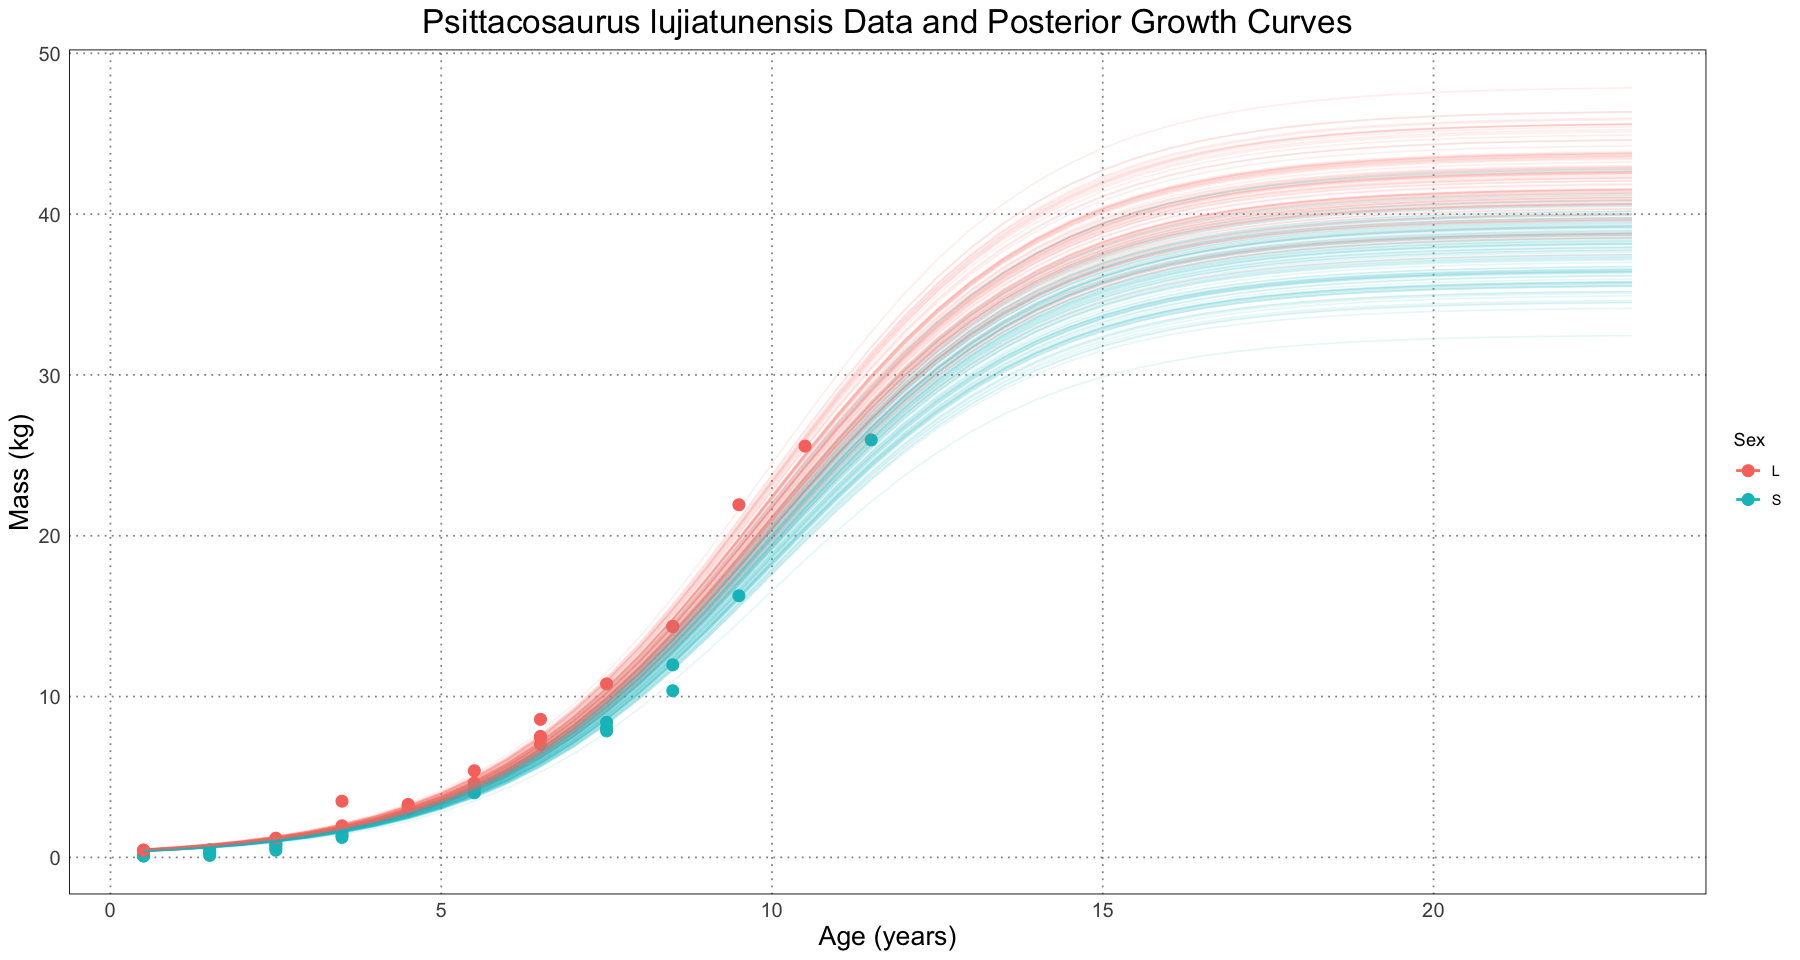

In [238]:
p <- ggplot() +
    custom_theme() +
    geom_point(psittacosaurus, mapping = aes(age, mass, colour = sex), size = 3) +
    labs(x = "Age (years)", y = "Mass (kg)", colour = "Sex")

# draw in samples from the large and small curves
for (i in 1:100) {
    index <- sample(1:length(psittacosaurus_samples[[ 'L_small' ]]), size = 1)
    L_small <- psittacosaurus_samples[['L_small']][index]
    k_small <- psittacosaurus_samples[['k_small']][index]
    q_small <- psittacosaurus_samples[['q_small']][index]
    curve_mass_small <- generalized_logistic(curve_ages, L = L_small, k = k_small, q = q_small)

    L_large <- psittacosaurus_samples[['L_large']][index]
    k_large <- psittacosaurus_samples[['k_large']][index]
    q_large <- psittacosaurus_samples[['q_large']][index]
    curve_mass_large <- generalized_logistic(curve_ages, L = L_large, k = k_large, q = q_large)

    p <- p + 
        geom_line(data = data.frame(age = curve_ages, mass = curve_mass_small, sex = "S"), mapping = aes(age, mass, colour = sex), alpha = 0.1) +
        geom_line(data = data.frame(age = curve_ages, mass = curve_mass_large, sex = "L"), mapping = aes(age, mass, colour = sex), alpha = 0.1)

}
p <- p + labs(title = "Psittacosaurus lujiatunensis Data and Posterior Growth Curves")
print(p)

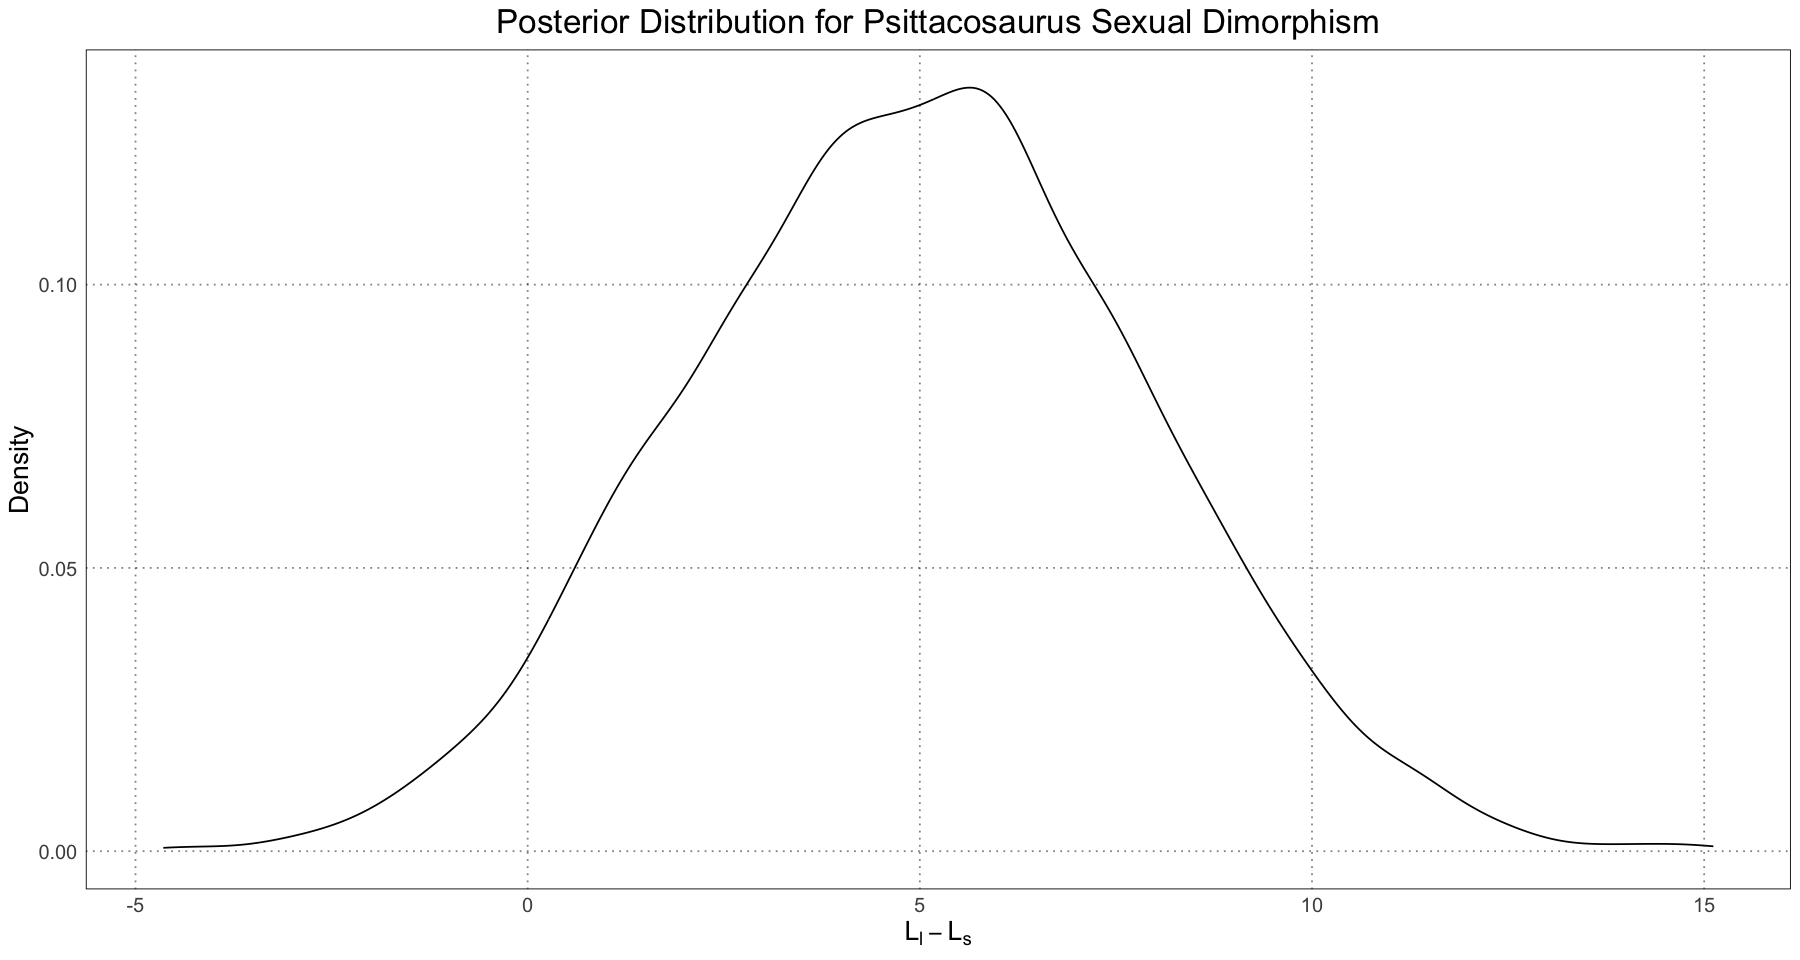

In [239]:
ggplot(data.frame(x = psittacosaurus_samples[['difference']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    labs(x = expression(L[l] - L[s]), y = "Density", title = "Posterior Distribution for Psittacosaurus Sexual Dimorphism") +
    custom_theme()

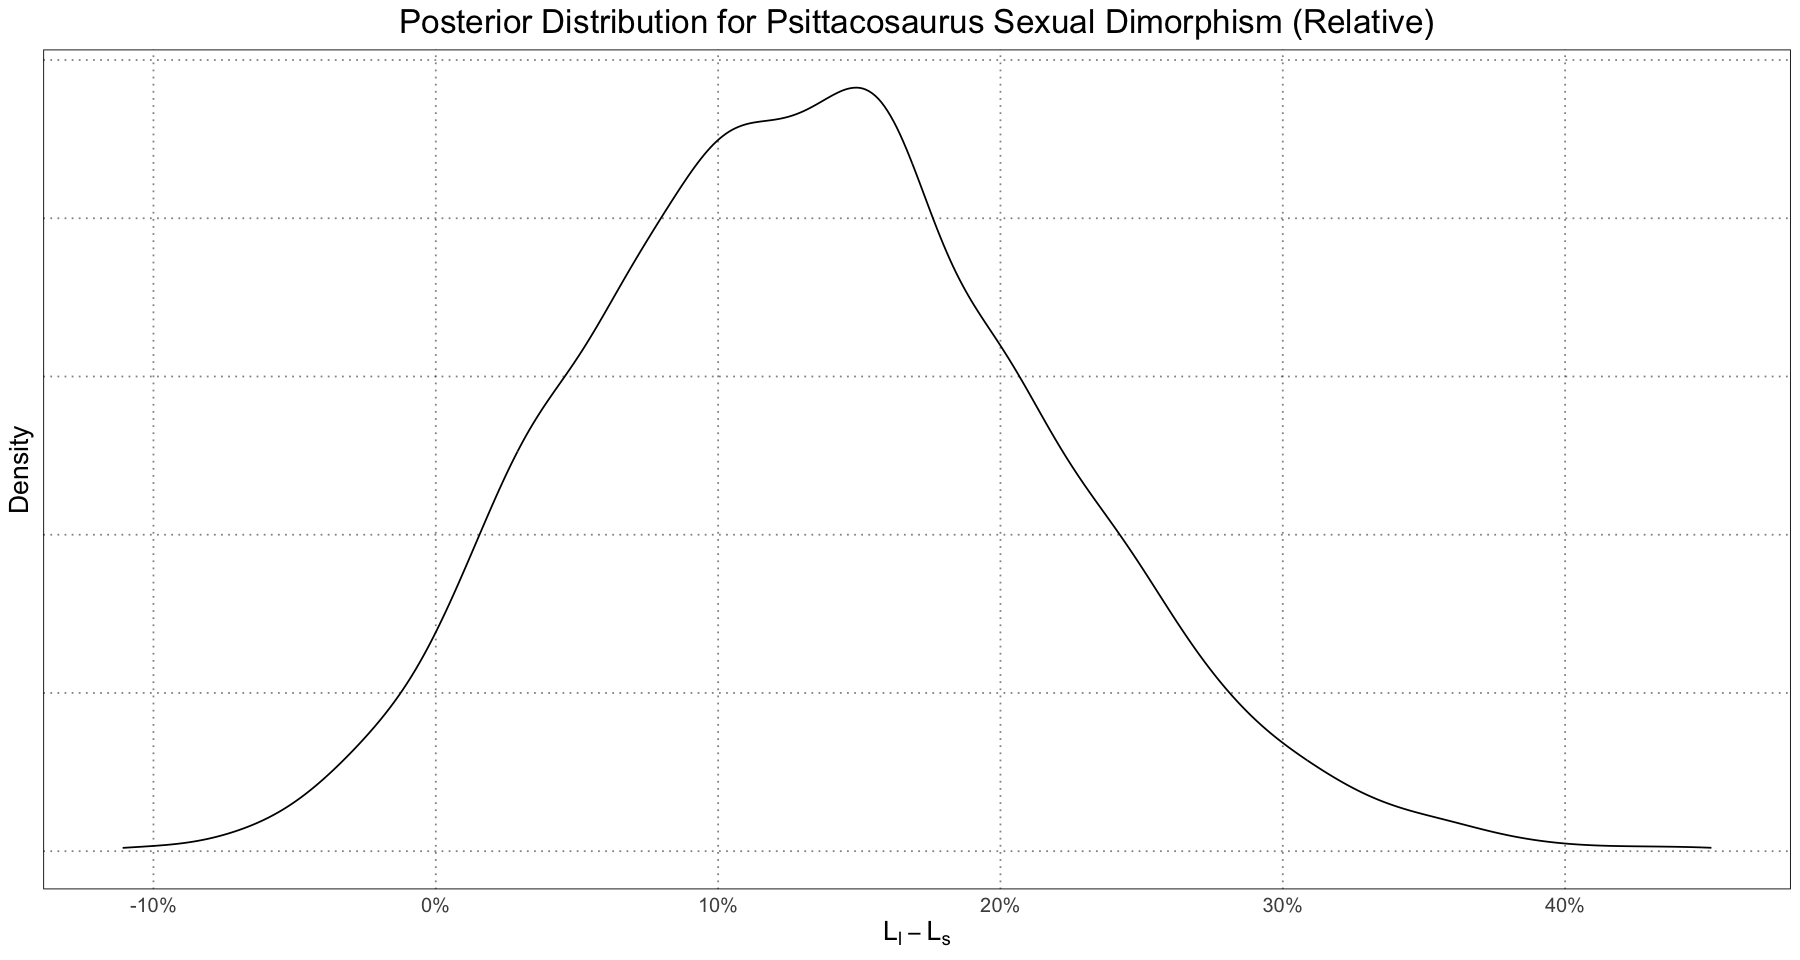

In [241]:
ggplot(data.frame(x = psittacosaurus_samples[['relative_difference']] - 1), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    labs(x = expression(L[l] - L[s]), y = "Density", title = "Posterior Distribution for Psittacosaurus Sexual Dimorphism (Relative)") +
    scale_x_continuous(labels = scales::percent) +
    scale_y_continuous(labels = NULL) +
    custom_theme()

## Tyrannosaurus

In [243]:
data <- read.csv('data/Tyrannosaurus.csv')
head(data)

Specimen      Age..years. Mass..kg.
1 LACM 28471     2            30     
2 AMNH 30564    15          1761     
3 LACM 23845    14          1807     
4 ICM 2001.90.1 16          2984     
5 MOR 1125      18          2522     
6 RTMP 81.6.1   18          3230

In [244]:
tyrannosaurus <- data.frame(
    age = data$Age..years.,
    mass = data$Mass..kg.
)

initial_tyrannosaurus_params <- list(
    L=5000,
    k=0.5,
    q=10
)

fit.population <- generate_logistic_curve_fit(tyrannosaurus, initial_params = initial_tyrannosaurus_params)
tyrannosaurus_population_params <- coef(fit.population)

Warning message in nls.lm(par = start, fn = FCT, jac = jac, control = control, lower = lower, :
“lmdif: info = -1. Number of iterations has reached `maxiter' == 50.
”


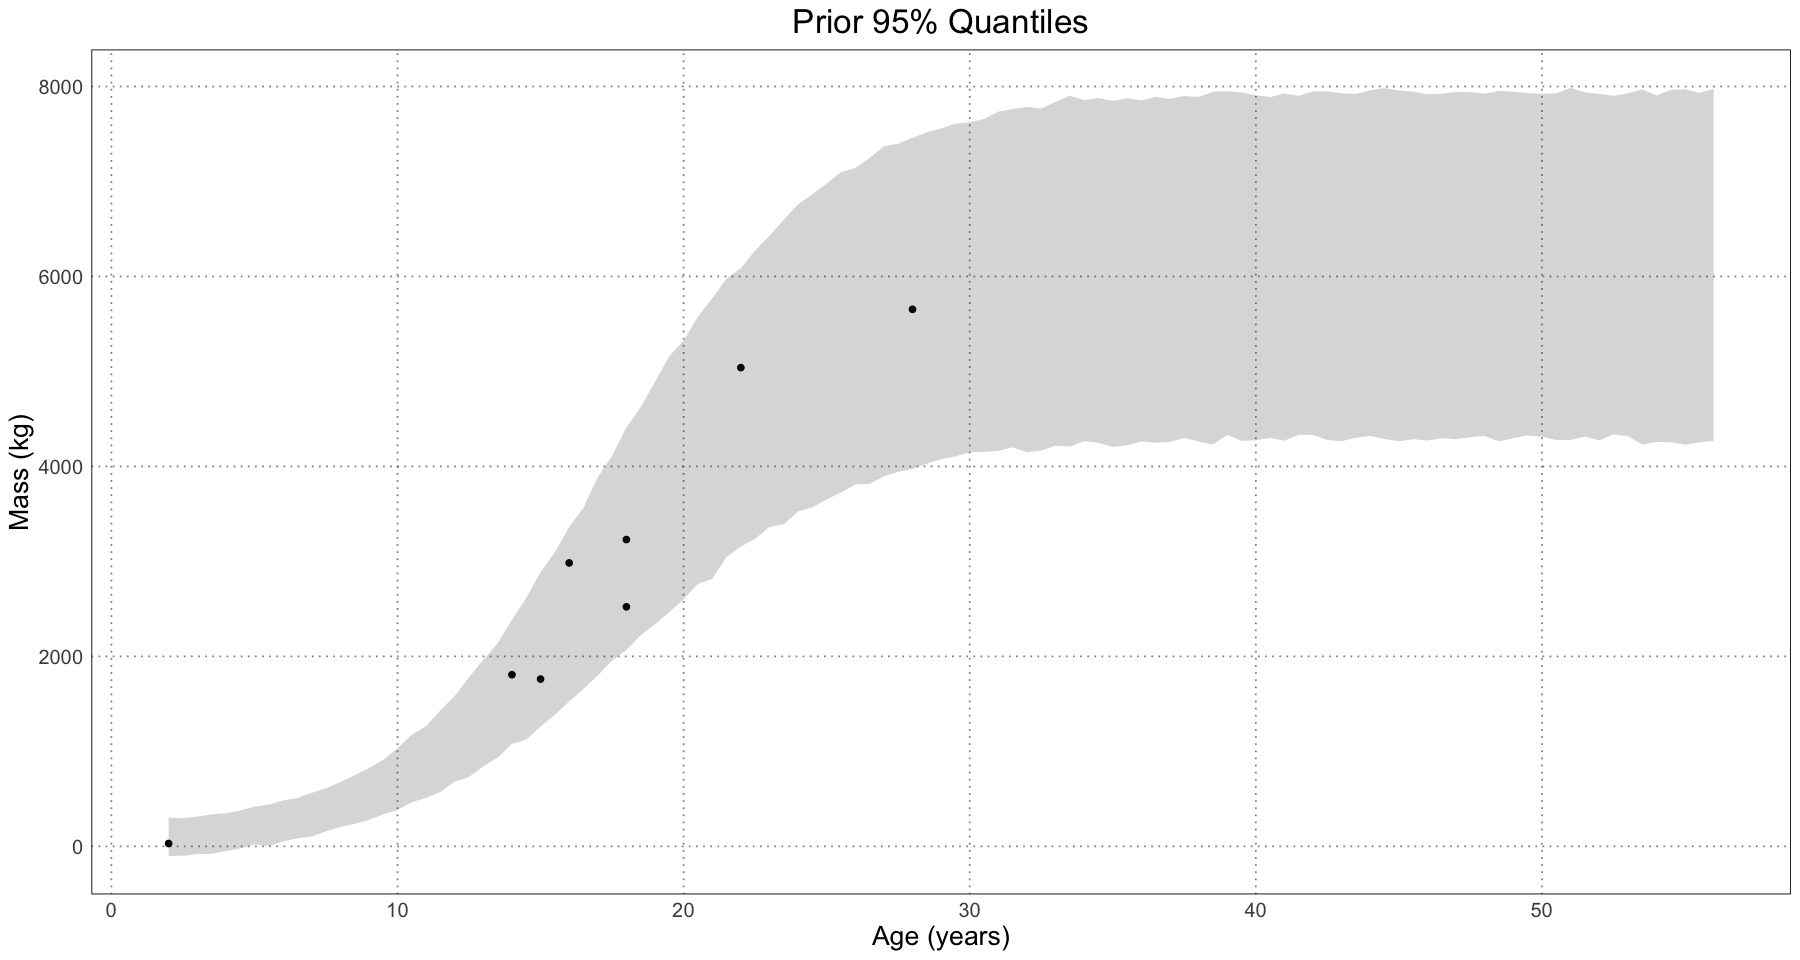

In [246]:
# Find priors
num_samples <- 1e3
prior_L_sd <- 1000
Ls <- rnorm(num_samples, tyrannosaurus_population_params[['L']], sd = prior_L_sd)
prior_k_sd <- 0.0125
ks <- rnorm(num_samples, tyrannosaurus_population_params[['k']], sd = prior_k_sd)
prior_q_sd <- 0.004
qs <- rnorm(num_samples, tyrannosaurus_population_params[['q']], sd = prior_q_sd)
prior_sigma_mean <- 100
prior_sigma_sd <- 1
sigmas <- rnorm(num_samples, prior_sigma_mean, prior_sigma_sd)

curve_data <- data.frame(age = numeric(), length = numeric())
curve_ages <- seq(min(tyrannosaurus$age), 2 * max(tyrannosaurus$age), by = 0.5)
for (i in 1:1e3) {
    index <- sample(1:num_samples, size = 1)
    L <- Ls[index]
    k <- ks[index]
    q <- qs[index]
    sigma <- sigmas[index]

    curve_mass_mean <- generalized_logistic(curve_ages, L = L, k = k, q = q)
    curve_mass <- rnorm(length(curve_mass_mean), mean = curve_mass_mean, sd = sigma)
    curve_data <- rbind(
        curve_data,
        data.frame(age = curve_ages, mass = curve_mass)
    )
}

range_df <- data.frame(age = numeric(), lower = numeric(), upper = numeric())
for (age in unique(curve_data$age)) {
    relevant <- curve_data[abs(curve_data$age - age) < 0.1, ]
    masses <- relevant$mass
    lower <- quantile(masses, c(0.025))
    upper <- quantile(masses, c(0.975))
    range_df <- rbind(
        range_df,
        data.frame(
            age = age,
            lower = lower,
            upper = upper
        )
    )
}
ggplot() +
    geom_point(data = tyrannosaurus, mapping = aes(age, mass)) +
    geom_ribbon(data = range_df, mapping = aes(x = age, ymin = lower, ymax = upper), alpha = 0.2) +
    labs(x = "Age (years)", y = "Mass (kg)", title = "Prior 95% Quantiles") +
    custom_theme()

In [247]:
# now fit the tyrannosaurus data
tyrannosaurus$residual <- resid(fit.population)
tyrannosaurus$sex <- ifelse(tyrannosaurus$residual < 0, "S", "L")
large_sex_data <- subset(tyrannosaurus, sex == "L")
small_sex_data <- subset(tyrannosaurus, sex == "S")

model_data <- list(
    N_large = nrow(large_sex_data),
    age_large = large_sex_data$age,
    mass_large = large_sex_data$mass,
    N_small = nrow(small_sex_data),
    age_small = small_sex_data$age,
    mass_small = small_sex_data$mass,
    prior_L_mean = tyrannosaurus_population_params[['L']],
    prior_L_sd = prior_L_sd,
    prior_k_mean = tyrannosaurus_population_params[['k']],
    prior_k_sd = prior_k_sd,
    prior_q_mean = tyrannosaurus_population_params[['q']],
    prior_q_sd = prior_q_sd,
    prior_sigma_mean = prior_sigma_mean,
    prior_sigma_sd = prior_sigma_sd
)

tyrannosaurus.model <- stan(model_code = logistic_dimorphism_model, data = model_data)

In [248]:
tyrannosaurus.model

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                       mean se_mean     sd    2.5%     25%     50%     75%
L_large             6381.20    5.89 270.15 5882.77 6194.64 6371.93 6550.43
k_large               -0.27    0.00   0.01   -0.29   -0.28   -0.27   -0.27
q_large                4.72    0.00   0.00    4.71    4.71    4.72    4.72
L_small             6269.44    3.50 160.76 5959.69 6162.02 6262.69 6376.70
k_small               -0.25    0.00   0.00   -0.25   -0.25   -0.25   -0.24
q_small                4.72    0.00   0.00    4.71    4.71    4.72    4.72
mass_sd              100.19    0.02   1.01   98.28   99.50  100.21  100.86
difference           111.75    6.93 316.05 -478.54 -103.60  103.51  315.37
relative_difference    1.02    0.00   0.05    0.93    0.98    1.02    1.05
lp__                 -53.88    0.04   1.87  -58.32  -54.94  -53.54  -52.49
                   

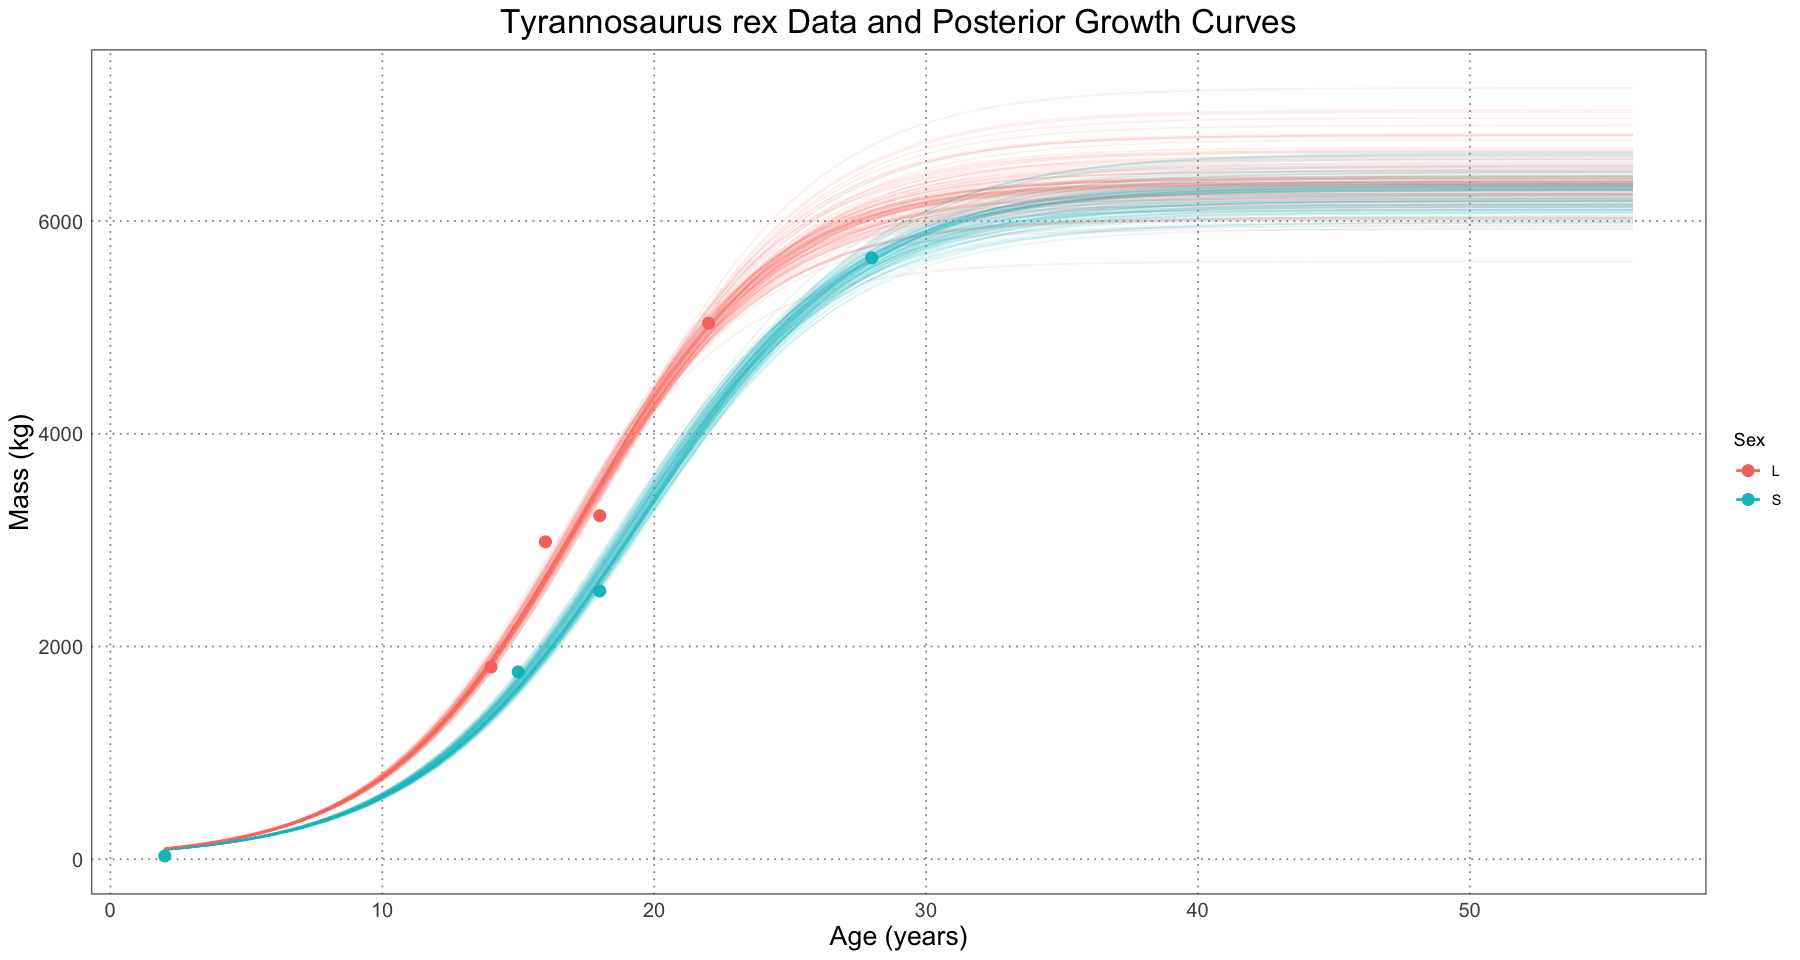

In [249]:
tyrannosaurus_samples <- extract(tyrannosaurus.model)
p <- ggplot() +
    custom_theme() +
    geom_point(tyrannosaurus, mapping = aes(age, mass, colour = sex), size = 3) +
    labs(x = "Age (years)", y = "Mass (kg)", colour = "Sex")

# draw in samples from the large and small curves
for (i in 1:100) {
    index <- sample(1:length(tyrannosaurus_samples[[ 'L_small' ]]), size = 1)
    L_small <- tyrannosaurus_samples[['L_small']][index]
    k_small <- tyrannosaurus_samples[['k_small']][index]
    q_small <- tyrannosaurus_samples[['q_small']][index]
    curve_mass_small <- generalized_logistic(curve_ages, L = L_small, k = k_small, q = q_small)

    L_large <- tyrannosaurus_samples[['L_large']][index]
    k_large <- tyrannosaurus_samples[['k_large']][index]
    q_large <- tyrannosaurus_samples[['q_large']][index]
    curve_mass_large <- generalized_logistic(curve_ages, L = L_large, k = k_large, q = q_large)

    p <- p + 
        geom_line(data = data.frame(age = curve_ages, mass = curve_mass_small, sex = "S"), mapping = aes(age, mass, colour = sex), alpha = 0.1) +
        geom_line(data = data.frame(age = curve_ages, mass = curve_mass_large, sex = "L"), mapping = aes(age, mass, colour = sex), alpha = 0.1)

}
p <- p + labs(title = "Tyrannosaurus rex Data and Posterior Growth Curves")
print(p)

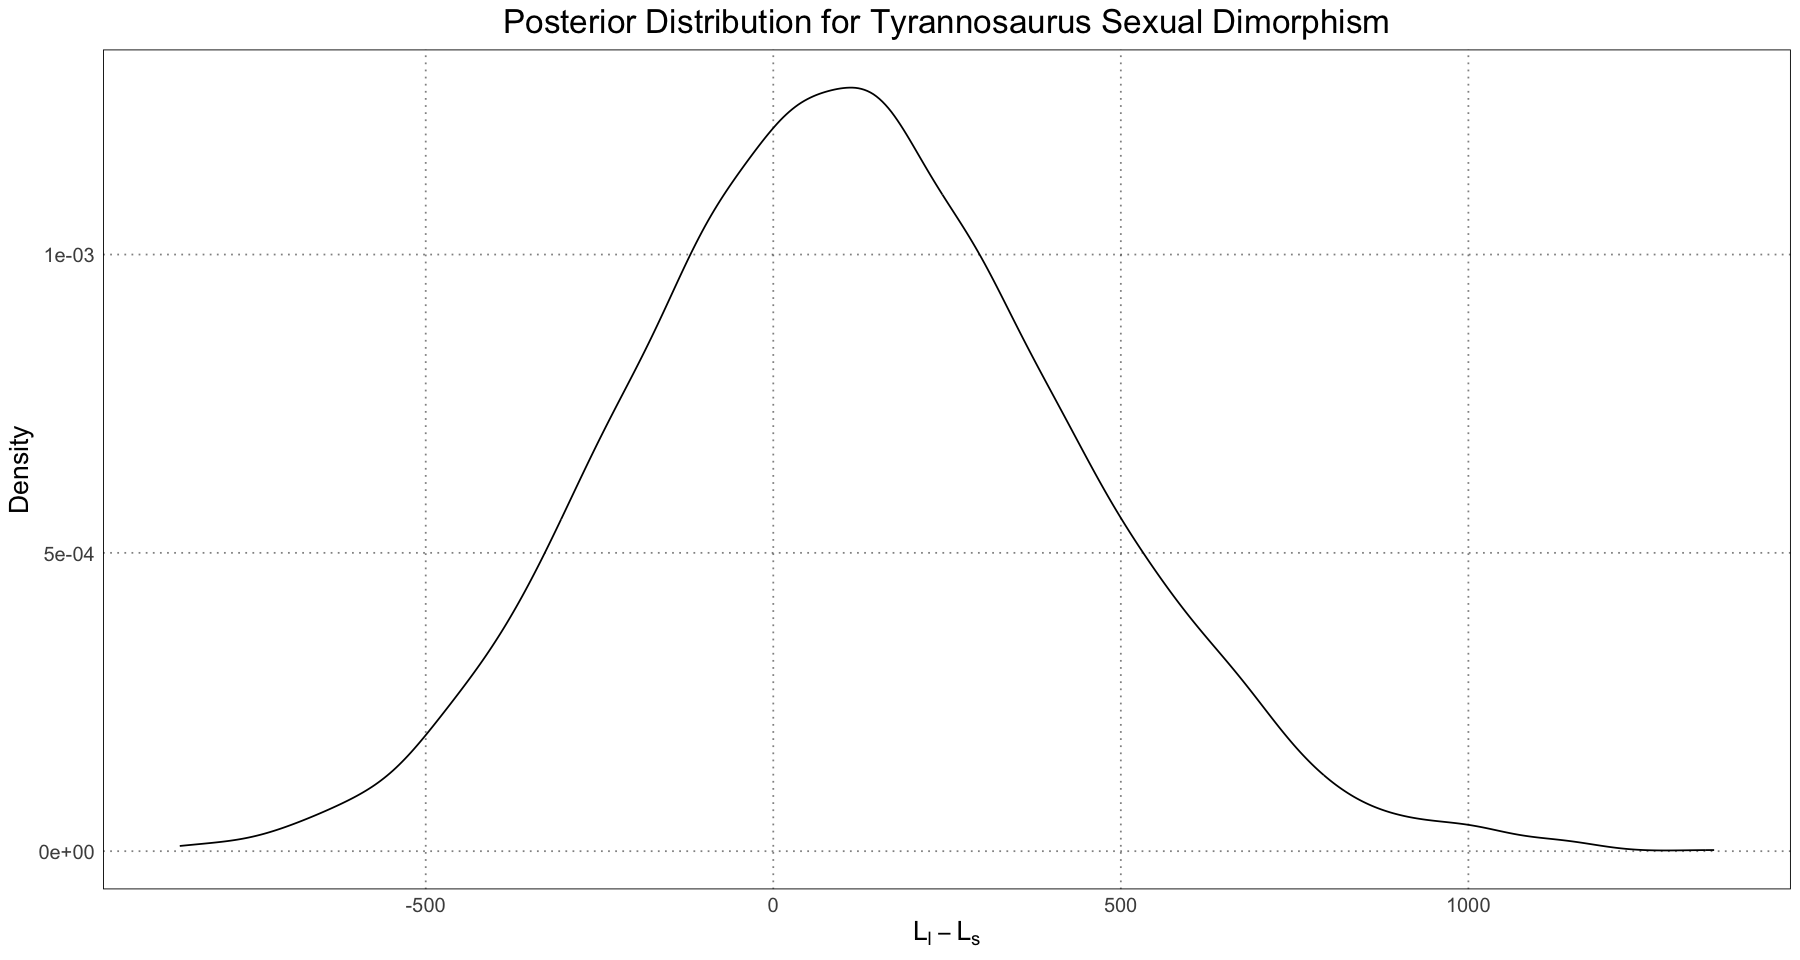

In [250]:
ggplot(data.frame(x = tyrannosaurus_samples[['difference']]), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    labs(x = expression(L[l] - L[s]), y = "Density", title = "Posterior Distribution for Tyrannosaurus Sexual Dimorphism") +
    custom_theme()

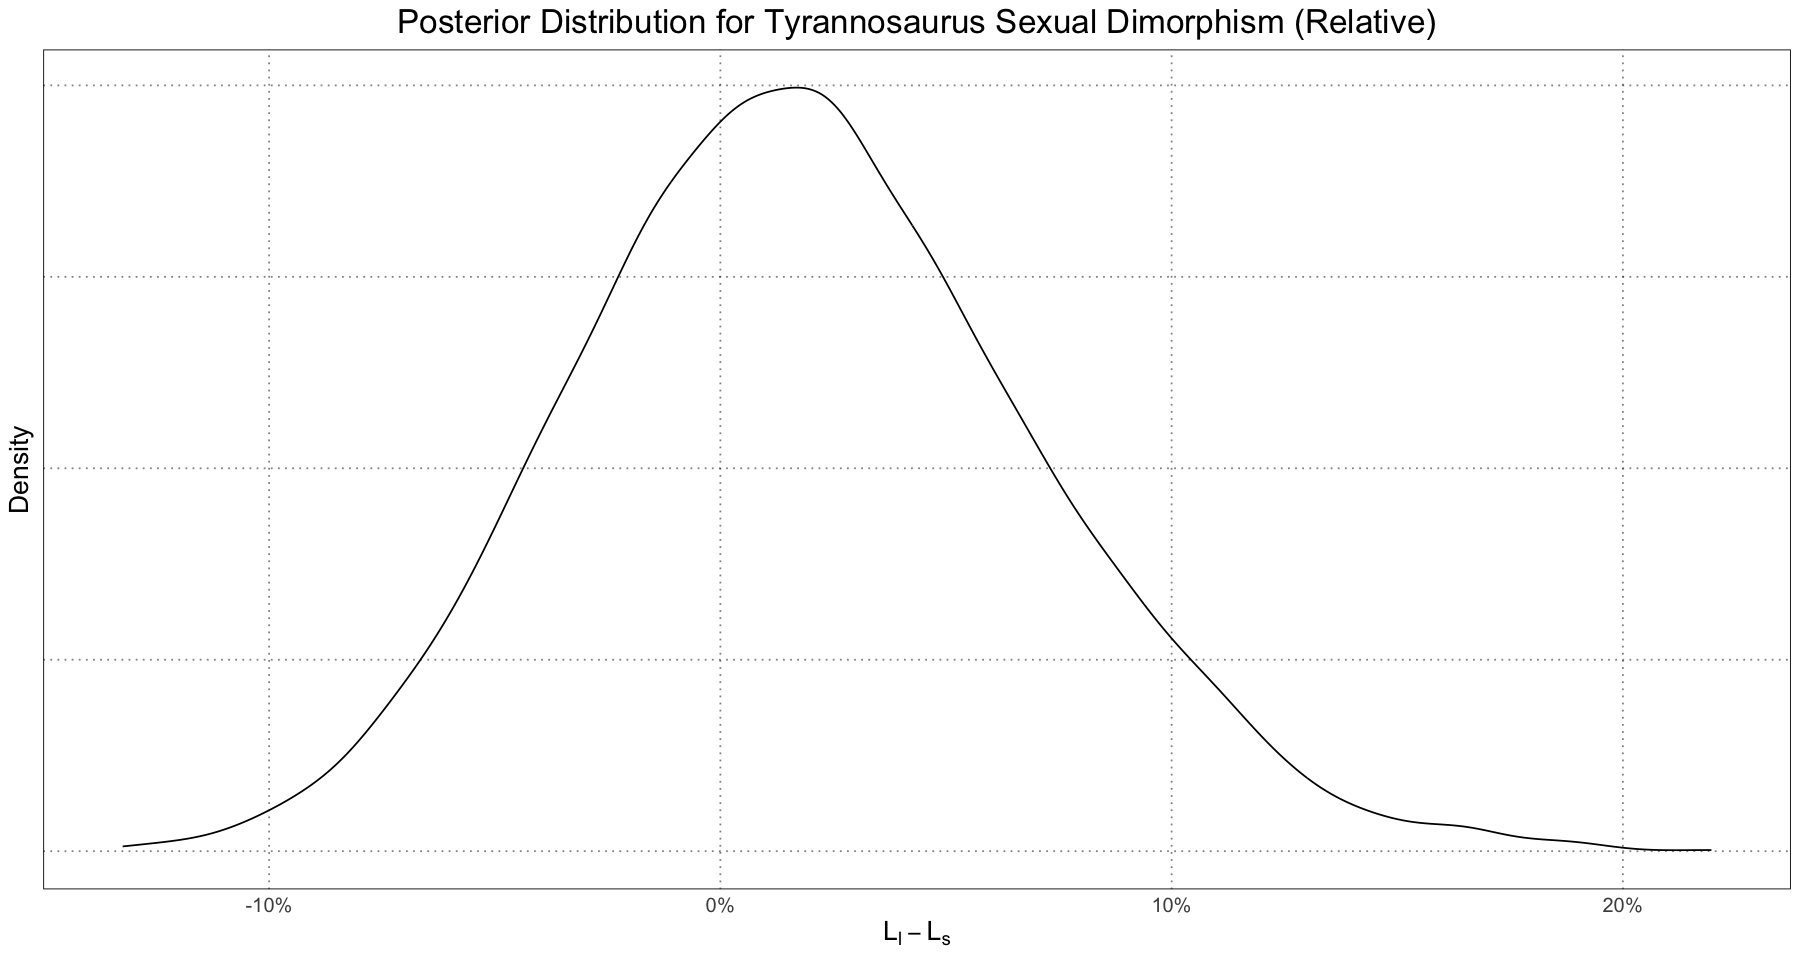

In [251]:
ggplot(data.frame(x = tyrannosaurus_samples[['relative_difference']] - 1), aes(x)) +
    geom_density(aes(y = after_stat(density))) +
    labs(x = expression(L[l] - L[s]), y = "Density", title = "Posterior Distribution for Tyrannosaurus Sexual Dimorphism (Relative)") +
    scale_x_continuous(labels = scales::percent) +
    scale_y_continuous(labels = NULL) +
    custom_theme()

Amazing! So here we have all of our data. For interest, let's see how the distributions compare with each other!

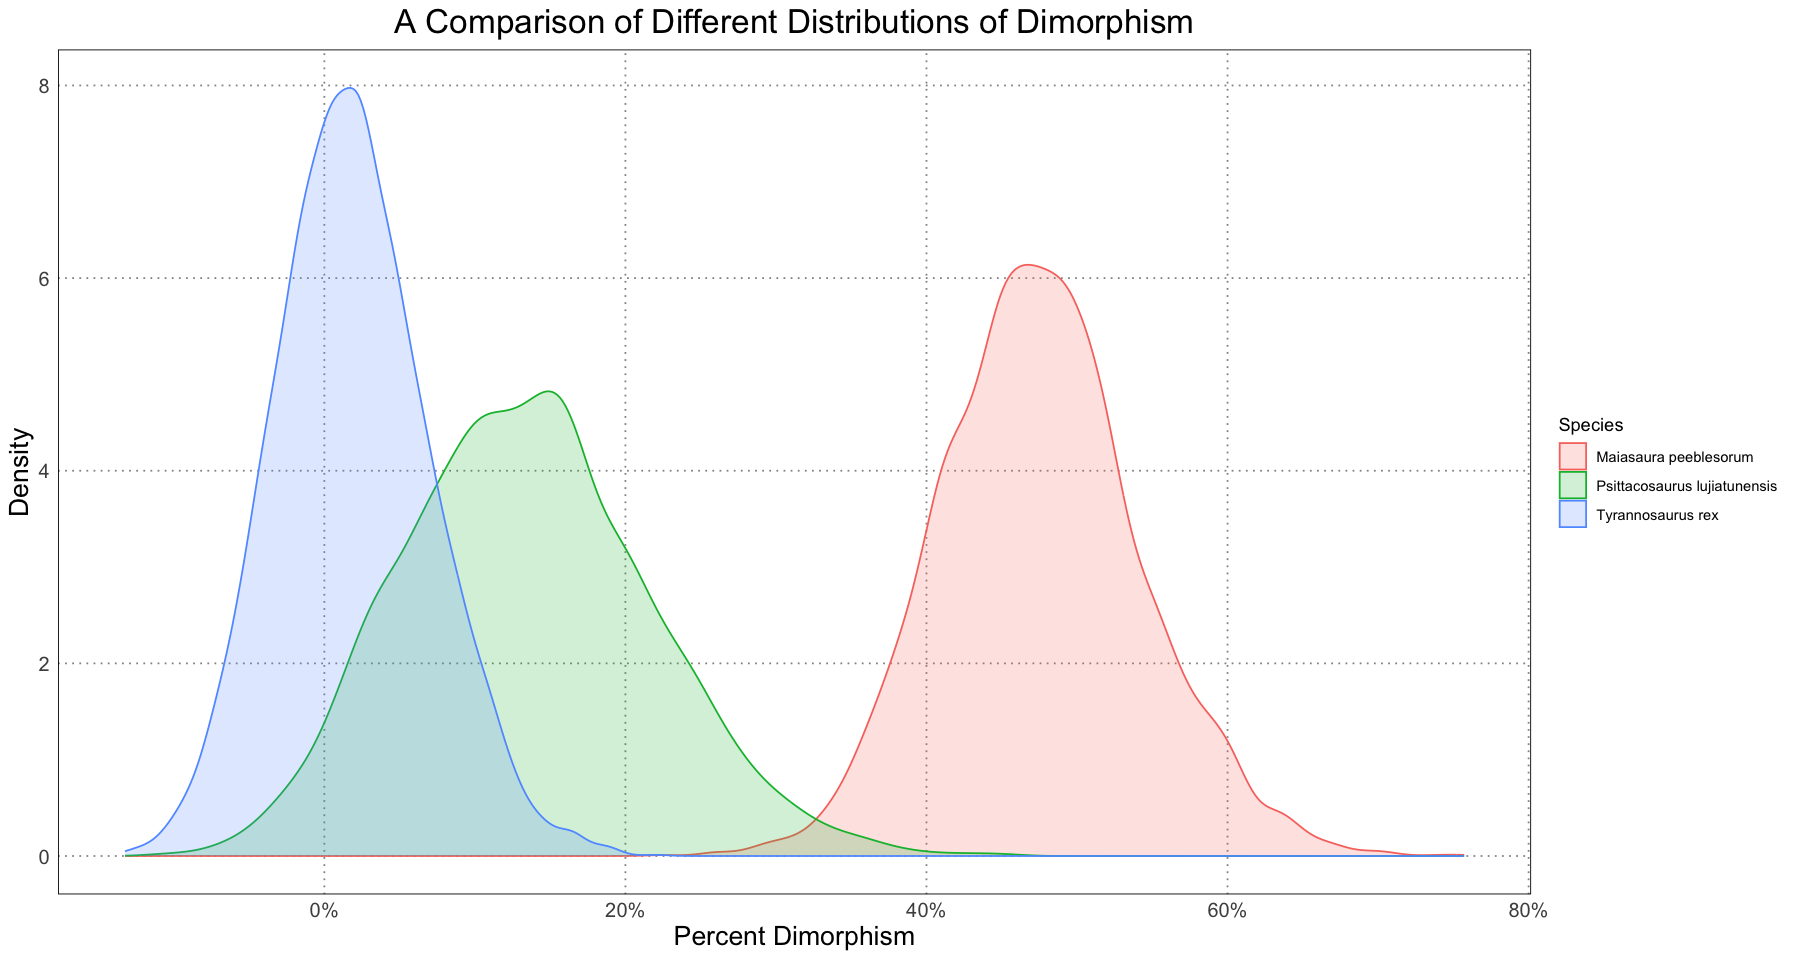

In [258]:
dimorphism_df <- rbind(
    data.frame(
        x = maiasaura_samples[['relative_difference']] - 1,
        species = "Maiasaura peeblesorum"
    ),
    data.frame(
        x = psittacosaurus_samples[['relative_difference']] - 1,
        species = "Psittacosaurus lujiatunensis"
    ),
    data.frame(
        x = tyrannosaurus_samples[['relative_difference']] - 1,
        species = "Tyrannosaurus rex"
    )
)

ggplot(dimorphism_df, aes(x = x, colour = species)) +
    custom_theme() +
    geom_density(aes(y = after_stat(density), fill = species), alpha = 0.2) +
    scale_x_continuous(labels = scales::percent) +
    labs(x = "Percent Dimorphism", y = "Density", title = "A Comparison of Different Distributions of Dimorphism", colour = "Species", fill = "Species")
